# # Buy it again 추천 score 계산 과정.

![title](./그림1.png)
![title](./그림2.png)
![title](./그림3.png)

---

---

### # "241,010,102       : 기저귀" 를 통한, 추천 score 계산 흐름 파악

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import seaborn as sns

In [2]:
import os
os.getcwd()

'/Users/we/Downloads/업무/buy it again_분석 '

./chunk/

---

### # 훈련데이터와 test 데이터 정의

In [3]:
diaper_train = pd.read_excel('diaper_train.xlsx')
diaper_test = pd.read_excel('diaper_test.xlsx')

In [4]:
diaper_train.head(3)

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
105,105,2018-01-01 00:00:26,"6,200,018","34,900","1,472,659","241,010,102",1
212,212,2018-01-01 00:00:52,"2,683,481","32,000","1,597,856","241,010,102",1
2357,2357,2018-01-01 00:03:47,"3,579,286","104,700","1,766,436","241,010,102",1


In [5]:
diaper_train.m_id.nunique()   # 약 20만명(31~32주 동안)

212550

In [6]:
train_mid = diaper_train.m_id.unique()

In [7]:
diaper_train[diaper_train.m_id == train_mid[0]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
105,105,2018-01-01 00:00:26,"6,200,018","34,900","1,472,659","241,010,102",1
3125,3125,2018-01-01 00:04:27,"6,200,018","34,900","1,472,659","241,010,102",1
732522,10732522,2018-01-24 09:44:17,"6,200,018","15,800","3,201,607","241,010,102",1


---

## # Step1. # 카테고리 𝐴_𝑖의 모든 개별 구매고객 𝐶_𝑗의 구매 time-interval 추출.

### #  기저귀 time interval 불러오기

In [ ]:
# 이런식으로 time-interval 뽑아온다. - 여기서는 extracted data 사용


t = np.array([])
for i in range(len(diaper_train.m_id.unique())):
    inter = diaper_train[diaper_train.m_id == diaper_train.m_id.unique()[i]]
    

    t = np.append(t, [j.days for j in inter.biz_dt.diff()]) 

---

In [5]:
#여기서는 저장되어있는 tt(time-interval 사용)

tt = pd.read_csv('diaper_t.csv')

In [6]:
tt.head()

,Unnamed: 0,0
0,0,NaN
1,1,0.0
2,2,23.0
3,3,NaN
4,4,59.0


In [7]:
tt = tt.iloc[:,1:]

---

### # 고객들의 Time-interval 추출 간 구매 이력이 1회이거나, 동일 일자의 중복 구매 이력 제거 (time-interval 제공 x)

In [8]:
tt.shape

(545775, 1)

In [9]:
tt = tt.dropna()  # t값 순수하게 얻은거야

In [10]:
# nan값 제거하고 얻은 shape

tt.shape

(333225, 1)

In [11]:
tt.head()

,0
1,0.0
2,23.0
4,59.0
5,0.0
6,31.0


In [12]:
# time 으로 column명 변경
tt.columns = ['time']

In [13]:
tt.head(5)

,time
1,0.0
2,23.0
4,59.0
5,0.0
6,31.0


In [14]:
#음.. 여기도 0인값이 많구나? - 여러가지 이유로 많이 집계되었겠지만(한번에 여러번 구매했는데, 따로따로 들어가 있을 수 있고!), 그래도 무려 5만개야!

tt.time.value_counts()

0.0      57461
14.0      6597
20.0      6597
21.0      6572
15.0      6335
17.0      6236
18.0      6232
13.0      6209
19.0      6181
27.0      6042
16.0      5940
28.0      5882
22.0      5860
23.0      5682
26.0      5579
24.0      5531
12.0      5476
25.0      5429
29.0      5348
1.0       4994
11.0      4833
30.0      4809
10.0      4765
31.0      4498
9.0       4374
8.0       4236
32.0      4166
7.0       4122
33.0      4075
2.0       4018
         ...  
176.0       45
185.0       38
193.0       37
180.0       35
184.0       34
175.0       34
186.0       30
191.0       27
190.0       26
192.0       26
187.0       25
194.0       24
189.0       24
188.0       24
197.0       21
199.0       21
204.0       18
196.0       16
200.0       15
198.0       13
195.0       13
202.0       13
201.0       12
203.0       11
206.0        9
205.0        7
210.0        6
209.0        5
207.0        5
208.0        3
Name: time, Length: 211, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114beabe0>]],
      dtype=object)

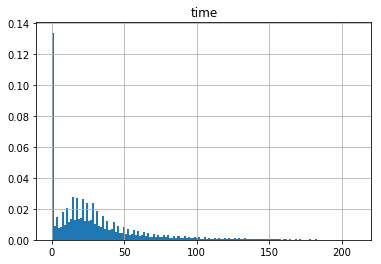

In [15]:
# time=0 인 값이 너무 많아보여서, histogram으로 다시 한번.

pd.DataFrame(tt).hist(bins=150, density = True)

histogram : 와... 0이 너무많아!

In [16]:
tmean = tt.mean()

In [17]:
# 0을 포함했을때의 평균.. 어느정도 될까?

tmean

time    29.54763
dtype: float64

### # drop 0 value 

    : lambda(반복 구매율) 추정에 기여할 수 없다! 어떤 이유로든 같은날 구매한거니깐!

In [18]:
# tt[['time']] 은 데이터프레임 - 0인값을 제거하는 과정

tt_drop0 = tt[tt.time != 0] 

---

In [19]:
tt_drop0.head()

,time
2,23.0
4,59.0
6,31.0
7,23.0
8,60.0


In [20]:
tt_drop0.time.value_counts()

20.0     6597
14.0     6597
21.0     6572
15.0     6335
17.0     6236
18.0     6232
13.0     6209
19.0     6181
27.0     6042
16.0     5940
28.0     5882
22.0     5860
23.0     5682
26.0     5579
24.0     5531
12.0     5476
25.0     5429
29.0     5348
1.0      4994
11.0     4833
30.0     4809
10.0     4765
31.0     4498
9.0      4374
8.0      4236
32.0     4166
7.0      4122
33.0     4075
2.0      4018
34.0     3960
         ... 
176.0      45
185.0      38
193.0      37
180.0      35
184.0      34
175.0      34
186.0      30
191.0      27
190.0      26
192.0      26
187.0      25
194.0      24
189.0      24
188.0      24
197.0      21
199.0      21
204.0      18
196.0      16
200.0      15
198.0      13
195.0      13
202.0      13
201.0      12
203.0      11
206.0       9
205.0       7
210.0       6
209.0       5
207.0       5
208.0       3
Name: time, Length: 210, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114bd9da0>]],
      dtype=object)

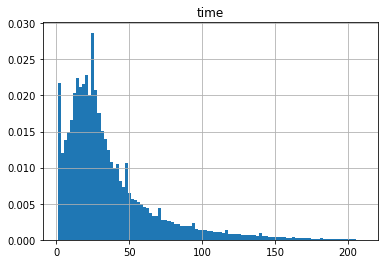

In [21]:
tt_drop0.hist(bins=100, density = True)

In [22]:
tt_drop0.mean()

time    35.704476
dtype: float64

In [23]:
#0인 관측치들 제외하고, 평균 약 35일

tt_drop0.mean()

time    35.704476
dtype: float64

---

---

## # Step2. # ’1/Time-interval’ 을 이용하여, Gamma 분포 MLE 구하기(분포 나타내는 파라미터 추정값).

#### * lambda라는 개념을 다시 잡기.
poisson(lambda) : 이때의 lambda는 단위시간 당 사건의 평균적인 발생 횟수. - 이를 추정하기 위해, 단위 시간 당 사건의 발생횟수의 분포를 본다.

반복구매율(lambda) : 고객들이 반복 구매를 나타내는 정도를 나타내는 수치 -> 1/time-interval 인 <U>'단위 시간 당 사건의 발생횟수'</U>로 본다.

In [1]:
# 예로, 평균적인 repeat purchase daya : 35일 -> 하루마다 약 0.028씩 구매사건이 일어난다!

1/35

0.02857142857142857

In [24]:
tt_drop0.mean()

time    35.704476
dtype: float64

In [25]:
# tt_drop0의 inverse를 사용할 것이다.

tt_inver = 1/tt_drop0

In [26]:
tt_inver

,time
2,0.043478
4,0.016949
6,0.032258
7,0.043478
8,0.016667
9,0.125000
11,0.018868
14,0.006757
15,0.031250
17,0.034483


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1181977b8>]],
      dtype=object)

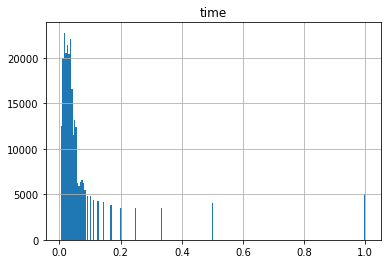

In [27]:
tt_inver.hist(bins=210)

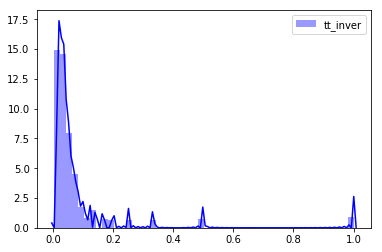

In [28]:
# tt_inver 의 분포를 살펴보는거야

plt.figure()
sns.distplot( tt_inver, color = 'blue', label='tt_inver')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

---

### # step2-(1). gamma.fit으로 parameters 추정

In [29]:
alpha_, _ , scale_ = stats.gamma.fit(tt_inver, floc=0) 

In [30]:
# y_ : tt_inver의 감마 fitting 파라미터를 갖는 Random sample.(확인해보는 과정)

y_ = stats.gamma.rvs(a = alpha_ , scale=scale_ , size = tt_drop0.shape[0])

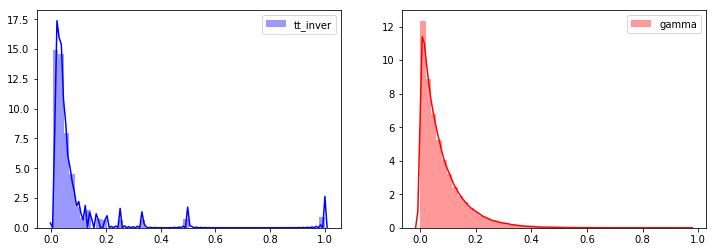

In [39]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.distplot( tt_inver, color = 'blue', label='tt_inver')  ## tt_inver 의 분포
plt.legend()
#plt.xlim(-3,55)

plt.subplot(1,2,2)
sns.distplot( y_, color = 'red', label='gamma')  ## tt_inver로 추정된 Gamma parameter를 갖는 Gamma분포
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

---

### # step2-(2). time-interval 단위를 변환한다면? - 1주일 단위로

In [40]:
# 1주윌 단위로 계산 -> 하루 단위에서 7배 해주면 되지.

tt_inver7 = tt_inver*7

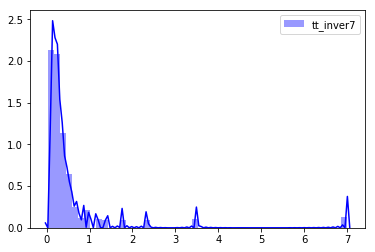

In [43]:
plt.figure()
sns.distplot( tt_inver7, color = 'blue', label='tt_inver7')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

In [128]:
# 이 데이터를 tt_inver7이라 명명

alpha_, _ , scale_ = stats.gamma.fit(tt_inver7, floc=0) 

In [129]:
alpha_, scale_

(0.9303596940492559, 0.5746030840918818)

In [136]:
y_ = stats.gamma.rvs(a = alpha_ , scale=scale_ , size = tt_drop0.shape[0])

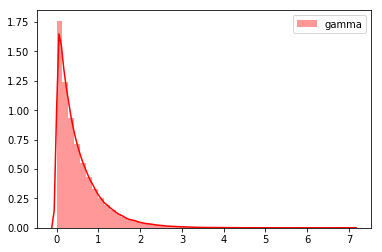

In [138]:
plt.figure()
sns.distplot( y_, color = 'red', label='gamma')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

---

---

## # Step3. # step2의 계산된 𝛼, 𝛽를 통해 ‘고객들의 재구매율’을 나타내는 parameter 𝜆(lambda)를 추정.

In [120]:
# 함수로 정의 : time-interval 단위 '하루'
# 고객의 k, t, t_purch, t_mean, 고객당 lambda 계산 값 계산


def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

In [139]:
# time-interval 단위 '일주일'.
# 고객의 k, t, t_purch, t_mean, 고객당 lambda 계산 값 계산


def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days/7  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days/7
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days/7
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

---

## # Step4. # 계산된 ’𝜆(lambda)’를 이용하여, ‘고객 시점별 제품 구매확률’ 계산.

In [ ]:
# simple하게, '현재 시점'에 의해 lambda값이 계산되기에, 아래 값을 이용하면 현재시점에서 score 계산 가능 

1-stats.poisson.pmf(mu = lamb, k=0)

---

## (Test)# RCP 부분을 제외한, test 진행!

### # (1) test id 정의

In [37]:
# Test_id : 테스트 데이터에서, unique한 id 1000개

test_id = diaper_test.m_id.unique()[:1000]

In [96]:
# test_id 1000개중에서, train기록 가지고있는 애들만 활용해본다!

tf = []
for i in range(len(test_id)):
    tf.append( bool(diaper_train[diaper_train.m_id == test_id[i]].shape[0]) 
              & bool(diaper_test[diaper_test.m_id == test_id[i]].shape[0]) == True) #train, test 둘다 있는 아이디를 밝혀주는 index만들어주는거야.

### # (2) test 기간 정의

In [141]:
# 설정한 current에서 한달 정도의 기간을 만들어준다.

current_l = pd.date_range('2018-08-01', periods=30).tolist()

In [60]:
d = {}

for j in range(len(test_id_[:30])):   # "test_id_" 를 이용해, 결과 살펴보겠다!
    d[j] = []
    for i in range(30):     ## 8월 한달간에 대해서!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current=current_l[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )
    print('------------------------------------------------------------------------')
    print('\n')

user:[0] last order: 2272463   2018-07-17 09:49:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714285714284 t_purch: 0.0
pred: 0.23850961614127175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.2471795141407469 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.7142857142857144 t_purch: 0.0
pred: 0.25649803131475946 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.85714285

current: 2018-08-25 00:00:00 current-last_order: 6.428571428571429 t_purch: 25.714285714285715
pred: 0.22108331573010487 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-26 00:00:00 current-last_order: 6.571428571428571 t_purch: 25.714285714285715
pred: 0.21934517405228993 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-27 00:00:00 current-last_order: 6.714285714285714 t_purch: 25.714285714285715
pred: 0.21763399483991852 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-28 00:00:00 current-last_order: 6.857142857142857 t_purch: 25.714285714285715
pred: 0.2159491595576083 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-29 00:00:00 current-last_order: 7.0 t_purch: 25.714285714285715
pred: 0.21429006830783603 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-30 00:00:00 current-last_order: 7.142857142857143 t_purch: 25.714285714285715
pred: 0.21265613914010706 , tmean_u: 4.285714285714286 , k: 7 

-------------------------------------------------------------

current: 2018-08-15 00:00:00 current-last_order: 11.571428571428571 t_purch: 16.857142857142858
pred: 0.1488238364800467 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-16 00:00:00 current-last_order: 11.714285714285714 t_purch: 16.857142857142858
pred: 0.14755400513601558 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-17 00:00:00 current-last_order: 11.857142857142858 t_purch: 16.857142857142858
pred: 0.14630561136978426 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-18 00:00:00 current-last_order: 12.0 t_purch: 16.857142857142858
pred: 0.14507811815803495 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-19 00:00:00 current-last_order: 12.142857142857142 t_purch: 16.857142857142858
pred: 0.14387100621962223 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-20 00:00:00 current-last_order: 12.285714285714286 t_purch: 16.857142857142858
pred: 0.1426837732909063 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-21 00:00:00 current-last_order: 12.4285

current: 2018-08-06 00:00:00 current-last_order: 5.857142857142857 t_purch: 16.285714285714285
pred: 0.22979443517822062 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 6.0 t_purch: 16.285714285714285
pred: 0.2267911957748805 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 6.142857142857143 t_purch: 16.285714285714285
pred: 0.22386496956423974 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-09 00:00:00 current-last_order: 6.285714285714286 t_purch: 16.285714285714285
pred: 0.22101285182925257 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-10 00:00:00 current-last_order: 6.428571428571429 t_purch: 16.285714285714285
pred: 0.21823208099017766 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-11 00:00:00 current-last_order: 6.571428571428571 t_purch: 16.285714285714285
pred: 0.21552002997325448 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-12 00:00:00 current-last_order: 6.7142857142

current: 2018-08-28 00:00:00 current-last_order: 8.142857142857142 t_purch: 8.714285714285714
pred: 0.19452526540592474 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-29 00:00:00 current-last_order: 8.285714285714286 t_purch: 8.714285714285714
pred: 0.19182311280546016 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-30 00:00:00 current-last_order: 8.428571428571429 t_purch: 8.714285714285714
pred: 0.1891946997020817 , tmean_u: 4.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[7] last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 21.714285714285715 t_purch: 8.428571428571429
pred: 0.083084893532409 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 21.857142857142858 t_purch: 8.428571428571429
pred: 0.08258639982038929 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order

current: 2018-08-19 00:00:00 current-last_order: 6.857142857142857 t_purch: 4.285714285714286
pred: 0.23077189079694926 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-20 00:00:00 current-last_order: 7.0 t_purch: 4.285714285714286
pred: 0.2257213397709218 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-21 00:00:00 current-last_order: 7.142857142857143 t_purch: 4.285714285714286
pred: 0.22088583491366898 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-22 00:00:00 current-last_order: 7.285714285714286 t_purch: 4.285714285714286
pred: 0.21625201597269927 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-23 00:00:00 current-last_order: 7.428571428571429 t_purch: 4.285714285714286
pred: 0.211807599065008 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-24 00:00:00 current-last_order: 7.571428571428571 t_purch: 4.285714285714286
pred: 0.2075412712901059 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-25 00:00:00 current-last_order: 7.714285714285714 t_p

current: 2018-08-11 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-14 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-15 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-16 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-17 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

cu

current: 2018-08-03 00:00:00 current-last_order: 0.5714285714285714 t_purch: 25.857142857142858
pred: 0.3144769824623592 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-04 00:00:00 current-last_order: 0.7142857142857143 t_purch: 25.857142857142858
pred: 0.31683474333735806 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-05 00:00:00 current-last_order: 0.8571428571428571 t_purch: 25.857142857142858
pred: 0.3192275943390589 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-06 00:00:00 current-last_order: 1.0 t_purch: 25.857142857142858
pred: 0.3216563096355093 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-07 00:00:00 current-last_order: 1.1428571428571428 t_purch: 25.857142857142858
pred: 0.32412168575435574 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-08 00:00:00 current-last_order: 1.2857142857142858 t_purch: 25.857142857142858
pred: 0.3266245423670687 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-09 00:00:00 current-last_order

current: 2018-08-26 00:00:00 current-last_order: 24.0 t_purch: 0.0
pred: 0.047648982723065836 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 24.142857142857142 t_purch: 0.0
pred: 0.047315353721247844 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-28 00:00:00 current-last_order: 24.285714285714285 t_purch: 0.0
pred: 0.04698636332859574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-29 00:00:00 current-last_order: 24.428571428571427 t_purch: 0.0
pred: 0.04666191549286214 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-30 00:00:00 current-last_order: 24.571428571428573 t_purch: 0.0
pred: 0.046341916795042404 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[14] last order: 7058820   2018-07-26 23:17:51
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 0.7142857142857143 t_purch: 25.571428571428573
pred: 0.03732917756071052

current: 2018-08-17 00:00:00 current-last_order: 13.142857142857142 t_purch: 18.857142857142858
pred: 0.1308499822524236 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-18 00:00:00 current-last_order: 13.285714285714286 t_purch: 18.857142857142858
pred: 0.12961904009001934 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-19 00:00:00 current-last_order: 13.428571428571429 t_purch: 18.857142857142858
pred: 0.128411002934969 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-20 00:00:00 current-last_order: 13.571428571428571 t_purch: 18.857142857142858
pred: 0.12722523849638234 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-21 00:00:00 current-last_order: 13.714285714285714 t_purch: 18.857142857142858
pred: 0.12606113750007453 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-22 00:00:00 current-last_order: 13.857142857142858 t_purch: 18.857142857142858
pred: 0.12491811265277208 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-23 00:00:00 current-last_o

current: 2018-08-07 00:00:00 current-last_order: 13.857142857142858 t_purch: 4.142857142857143
pred: 0.10932054907942412 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 14.0 t_purch: 4.142857142857143
pred: 0.10816885938707221 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-09 00:00:00 current-last_order: 14.142857142857142 t_purch: 4.142857142857143
pred: 0.1070411555672327 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-10 00:00:00 current-last_order: 14.285714285714286 t_purch: 4.142857142857143
pred: 0.10593669689625018 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-11 00:00:00 current-last_order: 14.428571428571429 t_purch: 4.142857142857143
pred: 0.1048547728024215 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-12 00:00:00 current-last_order: 14.571428571428571 t_purch: 4.142857142857143
pred: 0.10379470134918267 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-13 00:00:00 current-last_order: 14.7142857142

current: 2018-08-29 00:00:00 current-last_order: 4.285714285714286 t_purch: 1.5714285714285714
pred: 0.3133598059470979 , tmean_u: 0.7142857142857143 , k: 3 

current: 2018-08-30 00:00:00 current-last_order: 4.428571428571429 t_purch: 1.5714285714285714
pred: 0.3064583438739217 , tmean_u: 0.7142857142857143 , k: 3 

------------------------------------------------------------------------


user:[19] last order: 6118967   2018-05-24 01:48:24
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.16138643536417574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.857142857142858 t_purch: 0.0
pred: 0.15763058023858967 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 10.0 t_purch: 0.0
pred: 0.15404512871147058 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 10.142857142857142 t_purch: 0.0
pred: 0.150618771

current: 2018-08-24 00:00:00 current-last_order: 24.714285714285715 t_purch: 0.0
pred: 0.04602627635977008 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-25 00:00:00 current-last_order: 24.857142857142858 t_purch: 0.0
pred: 0.04571490576934589 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-26 00:00:00 current-last_order: 25.0 t_purch: 0.0
pred: 0.04540771898122953 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 25.142857142857142 t_purch: 0.0
pred: 0.045104632248832766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-28 00:00:00 current-last_order: 25.285714285714285 t_purch: 0.0
pred: 0.04480556404545999 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-29 00:00:00 current-last_order: 25.428571428571427 t_purch: 0.0
pred: 0.04451043499125251 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-30 00:00:00 current-last_order: 25.571428571428573 t_purch: 0.0
pred: 0.04421916778299795 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-20 00:00:00 current-last_order: 7.857142857142857 t_purch: 20.428571428571427
pred: 0.20698647177054175 , tmean_u: 4.0 , k: 6 

current: 2018-08-21 00:00:00 current-last_order: 8.0 t_purch: 20.428571428571427
pred: 0.20524282349749323 , tmean_u: 4.0 , k: 6 

current: 2018-08-22 00:00:00 current-last_order: 8.142857142857142 t_purch: 20.428571428571427
pred: 0.20352816520056605 , tmean_u: 4.0 , k: 6 

current: 2018-08-23 00:00:00 current-last_order: 8.285714285714286 t_purch: 20.428571428571427
pred: 0.20184178374207962 , tmean_u: 4.0 , k: 6 

current: 2018-08-24 00:00:00 current-last_order: 8.428571428571429 t_purch: 20.428571428571427
pred: 0.20018298904304133 , tmean_u: 4.0 , k: 6 

current: 2018-08-25 00:00:00 current-last_order: 8.571428571428571 t_purch: 20.428571428571427
pred: 0.19855111316505347 , tmean_u: 4.0 , k: 6 

current: 2018-08-26 00:00:00 current-last_order: 8.714285714285714 t_purch: 20.428571428571427
pred: 0.19694550943539146 , tmean_u: 4.0 , k: 6 


current: 2018-08-14 00:00:00 current-last_order: 11.0 t_purch: 20.571428571428573
pred: 0.15994576872209798 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-15 00:00:00 current-last_order: 11.142857142857142 t_purch: 20.571428571428573
pred: 0.15872570921235918 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-16 00:00:00 current-last_order: 11.285714285714286 t_purch: 20.571428571428573
pred: 0.15752407250250733 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-17 00:00:00 current-last_order: 11.428571428571429 t_purch: 20.571428571428573
pred: 0.1563404456419779 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-18 00:00:00 current-last_order: 11.571428571428571 t_purch: 20.571428571428573
pred: 0.15517442789207436 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-19 00:00:00 current-last_order: 11.714285714285714 t_purch: 20.571428571428573
pred: 0.15402563027939908 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-20 00:00:00 current-last_order: 11.857

current: 2018-08-11 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-14 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-15 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.5993446293530069 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-16 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-17 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-

current: 2018-08-07 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-09 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-10 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-11 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 

---

---

In [181]:
# user[10] 에 대해서만 해볼게.
d={}

j=10

d[j] = []
for i in range(len(current_l)):     ## 8월 한달간에 대해서!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current=current_l[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )

user:[10] last order: 9109044   2018-07-31 23:58:04
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 0.0
pred: 0.1492609718844462 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.1677444745267762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 0.857142

current: 2018-09-28 00:00:00 current-last_order: 8.285714285714286 t_purch: 0.0
pred: 0.21180363281332593 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-09-29 00:00:00 current-last_order: 8.428571428571429 t_purch: 0.0
pred: 0.20539396797631326 , tmean_u: 5.100639366580533 , k: 1 



In [182]:
d[10]

[0.1492609718844462,
 0.15262529603615016,
 0.1561443769006401,
 0.1598291112140694,
 0.16369143967784472,
 0.1677444745267762,
 0.17200264617917482,
 0.17648187236424762,
 0.18119975382558728,
 0.1861758015698215,
 0.19143170171122925,
 0.19699162531428416,
 0.20288259233225814,
 0.20913490088036135,
 0.21578263579715118,
 0.2228642739113429,
 0.23042340787342663,
 0.23850961614127175,
 0.2471795141407469,
 0.25649803131475946,
 0.2665399714805564,
 0.2773919306514404,
 0.28915466860830186,
 0.3019460598372986,
 0.31590478832886815,
 0.33119500206795227,
 0.34801221009911987,
 0.3665907905949457,
 0.38721358216748103,
 0.41022414283976094,
 0.43604234487844873,
 0.46518392158465083,
 0.4982841026378889,
 0.536123793055775,
 0.5796517947398971,
 0.6299826662205766,
 0.6528041377417765,
 0.5993446293530069,
 0.5531773153814906,
 0.5131359972593814,
 0.47820111146735467,
 0.4475251015359182,
 0.42041633831105507,
 0.39631328709607805,
 0.37475947433076273,
 0.35538223047649276,
 0.337875

---

---

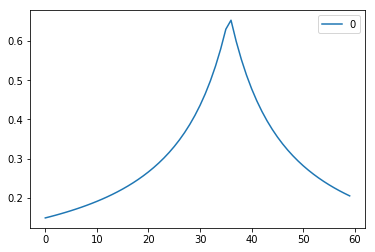

In [104]:
# user[10] : last-order가 7월 31일이다. 

sns.lineplot(data = pd.DataFrame(d[10]), color = 'red')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

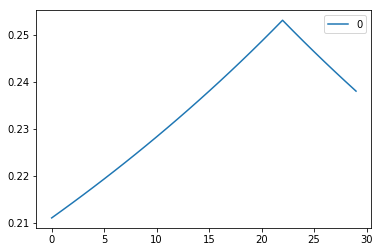

In [93]:
sns.lineplot(data = pd.DataFrame(d[9]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

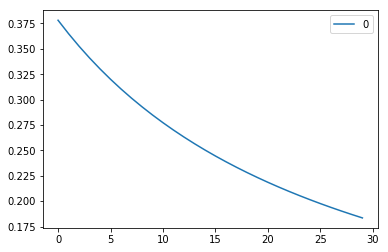

In [88]:
sns.lineplot(data = pd.DataFrame(d[4]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

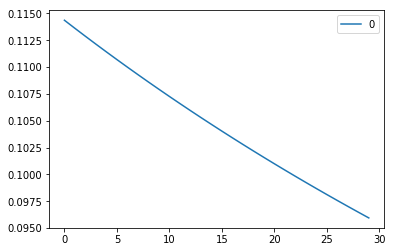

In [85]:
sns.lineplot(data = pd.DataFrame(d[2]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

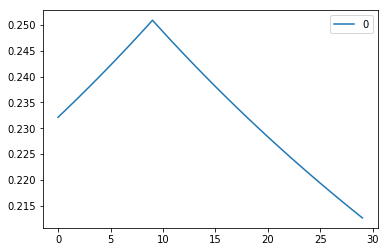

In [84]:
sns.lineplot(data = pd.DataFrame(d[1]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

---

## # 7월 29일~8월4일 (실 구매  : 8월 1일)

In [ ]:
import numpy as np
from scipy.signal import find_peaks

In [192]:
current_week = pd.date_range('2018-07-29', periods=7).tolist()

In [193]:
current_week

[Timestamp('2018-07-29 00:00:00', freq='D'),
 Timestamp('2018-07-30 00:00:00', freq='D'),
 Timestamp('2018-07-31 00:00:00', freq='D'),
 Timestamp('2018-08-01 00:00:00', freq='D'),
 Timestamp('2018-08-02 00:00:00', freq='D'),
 Timestamp('2018-08-03 00:00:00', freq='D'),
 Timestamp('2018-08-04 00:00:00', freq='D')]

In [194]:
current_week[6]+1

Timestamp('2018-08-05 00:00:00', freq='D')

---

In [197]:
current_week

[Timestamp('2018-07-29 00:00:00', freq='D'),
 Timestamp('2018-07-30 00:00:00', freq='D'),
 Timestamp('2018-07-31 00:00:00', freq='D'),
 Timestamp('2018-08-01 00:00:00', freq='D'),
 Timestamp('2018-08-02 00:00:00', freq='D'),
 Timestamp('2018-08-03 00:00:00', freq='D'),
 Timestamp('2018-08-04 00:00:00', freq='D')]

In [198]:
d = {}

for j in range(len(test_id_)):   # "test_id_" 를 이용해, 결과 살펴보겠다!
    d[j] = []
    for i in range(len(current_week)):     ## 8월1일 기준 1주일!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current = current_week[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_week[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )
    print('------------------------------------------------------------------------')
    print('\n')

user:[0] last order: 2272463   2018-07-17 09:49:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 8.714285714285714
pred: 0.299850495791268 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 8.714285714285714
pred: 0.29351819397229884 , tmean_u: 4.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[7] last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 21.285714285714285 t_purch: 8.428571428571429
pred: 0.0846171226191823 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 21.428571428571427 t_purch: 8.428571428571429
pred: 0.08410014282545131 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 21.571428571428573 t_purch: 8.428571428571429
pred: 0.0835894376182178 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-01 00:00:00 current-last_order

current: 2018-07-31 00:00:00 current-last_order: 20.285714285714285 t_purch: 0.0
pred: 0.058344880188835435 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 20.428571428571427 t_purch: 0.0
pred: 0.05784549418453089 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 20.571428571428573 t_purch: 0.0
pred: 0.05735458178883546 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 20.714285714285715 t_purch: 0.0
pred: 0.05687192921008788 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 20.857142857142858 t_purch: 0.0
pred: 0.05639732978648615 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[14] last order: 7058820   2018-07-26 23:17:51
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.2857142857142857 t_purch: 25.571428571428573
pred: 0.03692

user:[20] last order: 7410712   2018-03-03 20:37:56
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 21.0 t_purch: 0.0
pred: 0.05593058369141468 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 21.142857142857142 t_purch: 0.0
pred: 0.055471497653262314 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 21.285714285714285 t_purch: 0.0
pred: 0.05501988468890495 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 21.428571428571427 t_purch: 0.0
pred: 0.05457556385008333 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 21.571428571428573 t_purch: 0.0
pred: 0.05413835998195382 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 21.714285714285715 t_purch: 0.0
pred: 0.05370810349313537 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 21.8

current: 2018-07-30 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.35538223047649276 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.571428571428571 t_purch: 0.0
pred: 0.3378755410020098 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[28] last order: 2998918   2018-06-29 23:42:54
Name: biz_dt, dtype: date

user:[34] last order: 7243049   2018-07-07 20:08:24
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.0 t_purch: 2.2857142857142856
pred: 0.398167820929029 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 3.142857142857143 t_purch: 2.2857142857142856
pred: 0.38719016770697123 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 3.2857142857142856 t_purch: 2.2857142857142856
pred: 0.37678723585822704 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 3.4285714285714284 t_purch: 2.2857142857142856
pred: 0.3669164096607369 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.5714285714285716 t_purch: 2.2857142857142856
pred: 0.357539013292438 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.7142857142857144 t_purch: 2.2857142857142856
pred: 0.3486198927515841 , tme

user:[41] last order: 8042679   2018-07-29 19:09:16
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.14285714285714285 t_purch: 0.0
pred: 0.14604144036425737 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 0.0 t_purch: 0.0
pred: 0.1492609718844462 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 0.714

current: 2018-08-04 00:00:00 current-last_order: 28.571428571428573 t_purch: 0.0
pred: 0.03887663345197778 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[48] last order: 3221455   2018-06-30 17:40:35
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.0 t_purch: 20.428571428571427
pred: 0.2684694266825426 , tmean_u: 4.0 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 4.142857142857143 t_purch: 20.428571428571427
pred: 0.26555378339614233 , tmean_u: 4.0 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 4.285714285714286 t_purch: 20.428571428571427
pred: 0.2627002195298813 , tmean_u: 4.0 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 4.428571428571429 t_purch: 20.428571428571427
pred: 0.2599067940791737 , tmean_u: 4.0 , k: 6 

current: 2018-08-02 00:00:00 current-last_order: 4.571428571428571 t_purch: 20.428571428571427
pred: 0.2571716451150492 , tmean

current: 2018-08-03 00:00:00 current-last_order: 11.571428571428571 t_purch: 0.0
pred: 0.12320212275879072 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 11.714285714285714 t_purch: 0.0
pred: 0.12099879376168166 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[55] last order: 9024555   2018-07-10 13:37:32
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.5714285714285716 t_purch: 2.0
pred: 0.4512385258470172 , tmean_u: 2.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 2.7142857142857144 t_purch: 2.0
pred: 0.4327306169594909 , tmean_u: 2.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 2.0
pred: 0.41563267731600384 , tmean_u: 2.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 3.0 t_purch: 2.0
pred: 0.39979626351191366 , tmean_u: 2.0 , k: 2 

current: 2018-08-02 00:00:00 current-la

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 25.857142857142858
pred: 0.0856703739195086 , tmean_u: 12.857142857142858 , k: 3 

------------------------------------------------------------------------


user:[62] last order: 3376297   2018-07-01 00:34:09
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 21.428571428571427
pred: 0.2037662586881407 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 21.428571428571427
pred: 0.20577758313267314 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 21.428571428571427
pred: 0.20782880666405268 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 21.428571428571427
pred: 0.20992112133836738 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 4.4285

current: 2018-08-02 00:00:00 current-last_order: 8.857142857142858 t_purch: 19.285714285714285
pred: 0.27184353392129146 , tmean_u: 2.142857142857143 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 9.0 t_purch: 19.285714285714285
pred: 0.2699412453432565 , tmean_u: 2.142857142857143 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 9.142857142857142 t_purch: 19.285714285714285
pred: 0.2680651427899218 , tmean_u: 2.142857142857143 , k: 10 

------------------------------------------------------------------------


user:[69] last order: 8142181   2018-03-05 08:26:09
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 20.714285714285715 t_purch: 2.142857142857143
pred: 0.06893558251058762 , tmean_u: 2.142857142857143 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 20.857142857142858 t_purch: 2.142857142857143
pred: 0.06847553093083991 , tmean_u: 2.142857142857143 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 21.0

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 9.714285714285714
pred: 0.10024731818082488 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 9.714285714285714
pred: 0.10123589471241268 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 9.714285714285714
pred: 0.1022441427616072 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 9.714285714285714
pred: 0.10327265473477543 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 9.714285714285714
pred: 0.10432204703779413 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 2.2857142857142856 t_purch: 9.714285714285714
pred: 0.10539296130222242 , tmean_u: 9.714285714285714 , k: 2 

---------------------------------------------------------------

user:[82] last order: 492146   2018-06-24 12:58:15
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.14285714285714285
pred: 0.28744479653438815 , tmean_u: 0.0 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 5.0 t_purch: 0.14285714285714285
pred: 0.28161495268463543 , tmean_u: 0.0 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.14285714285714285
pred: 0.2760144825145969 , tmean_u: 0.0 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.14285714285714285
pred: 0.2706302696181655 , tmean_u: 0.0 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.14285714285714285
pred: 0.26545016502258534 , tmean_u: 0.0 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.14285714285714285
pred: 0.2604629011117362 , tmean_u: 0.0 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 5.7

current: 2018-08-04 00:00:00 current-last_order: 8.285714285714286 t_purch: 20.714285714285715
pred: 0.1864458342345936 , tmean_u: 5.142857142857143 , k: 5 

------------------------------------------------------------------------


user:[89] last order: 9103051   2018-07-31 23:47:52
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 28.142857142857142
pred: 0.23212095417037437 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 28.142857142857142
pred: 0.23367243433471352 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 28.142857142857142
pred: 0.23524465109279757 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 28.142857142857142
pred: 0.23683801959649553 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-08-02 00:00:00 current-last_o

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 25.857142857142858
pred: 0.24975703081785128 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 25.857142857142858
pred: 0.24754467721930018 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.857142857142858
pred: 0.24537087637002997 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 25.857142857142858
pred: 0.24323463805105117 , tmean_u: 4.285714285714286 , k: 7 

------------------------------------------------------------------------


user:[96] last order: 6093616   2018-07-25 01:01:22
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.42857142857142855 t_purch: 23.714285714285715
pred: 0.30755501510776984 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-30 00:00:00 current

current: 2018-07-31 00:00:00 current-last_order: 13.857142857142858 t_purch: 16.0
pred: 0.12491811265277208 , tmean_u: 8.0 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 14.0 t_purch: 16.0
pred: 0.12379559766163717 , tmean_u: 8.0 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 14.142857142857142 t_purch: 16.0
pred: 0.12269304630570121 , tmean_u: 8.0 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 14.285714285714286 t_purch: 16.0
pred: 0.12160993155603605 , tmean_u: 8.0 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 14.428571428571429 t_purch: 16.0
pred: 0.12054574474171176 , tmean_u: 8.0 , k: 3 

------------------------------------------------------------------------


user:[103] last order: 3793714   2018-07-01 21:36:13
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 23.571428571428573
pred: 0.22619286511787062 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-30 00:00:00 

current: 2018-07-31 00:00:00 current-last_order: 0.0 t_purch: 20.714285714285715
pred: 0.12743216482132902 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 0.14285714285714285 t_purch: 20.714285714285715
pred: 0.1283787238928551 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 20.714285714285715
pred: 0.12933942593140368 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 20.714285714285715
pred: 0.13031458969999554 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 0.5714285714285714 t_purch: 20.714285714285715
pred: 0.13130454359364419 , tmean_u: 6.857142857142857 , k: 4 

------------------------------------------------------------------------


user:[110] last order: 6993934   2018-05-26 10:44:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order:

current: 2018-07-30 00:00:00 current-last_order: 19.142857142857142 t_purch: 6.714285714285714
pred: 0.12717945273740527 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 19.285714285714285 t_purch: 6.714285714285714
pred: 0.126406112216784 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 19.428571428571427 t_purch: 6.714285714285714
pred: 0.12564210471679593 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 19.571428571428573 t_purch: 6.714285714285714
pred: 0.12488726258491134 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 19.714285714285715 t_purch: 6.714285714285714
pred: 0.12414142215292412 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 19.857142857142858 t_purch: 6.714285714285714
pred: 0.12340442361951776 , tmean_u: 1.5714285714285714 , k: 5 

------------------------------------------

user:[123] last order: 5242780   2018-07-04 10:35:15
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.4285714285714284 t_purch: 22.857142857142858
pred: 0.3369830964712943 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-07-30 00:00:00 current-last_order: 3.5714285714285716 t_purch: 22.857142857142858
pred: 0.3340809549553846 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-07-31 00:00:00 current-last_order: 3.7142857142857144 t_purch: 22.857142857142858
pred: 0.33122754773554997 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-01 00:00:00 current-last_order: 3.857142857142857 t_purch: 22.857142857142858
pred: 0.32842168291551477 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-02 00:00:00 current-last_order: 4.0 t_purch: 22.857142857142858
pred: 0.32566220610268537 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 4.142857142857143 t_purch: 22.857142857142858
pred: 0.32294799899910

user:[130] last order: 9496727   2018-02-11 20:51:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 23.857142857142858 t_purch: 0.0
pred: 0.047987349112957545 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 24.0 t_purch: 0.0
pred: 0.047648982723065836 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 24.142857142857142 t_purch: 0.0
pred: 0.047315353721247844 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 24.285714285714285 t_purch: 0.0
pred: 0.04698636332859574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 24.428571428571427 t_purch: 0.0
pred: 0.04666191549286214 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 24.571428571428573 t_purch: 0.0
pred: 0.046341916795042404 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 

current: 2018-08-03 00:00:00 current-last_order: 3.7142857142857144 t_purch: 23.428571428571427
pred: 0.22724659986227724 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 3.857142857142857 t_purch: 23.428571428571427
pred: 0.22938360844585493 , tmean_u: 4.571428571428571 , k: 6 

------------------------------------------------------------------------


user:[137] last order: 2702992   2018-07-18 00:24:03
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 23.857142857142858
pred: 0.12033350236046558 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 23.857142857142858
pred: 0.12117734613035502 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 23.857142857142858
pred: 0.12203309052417599 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-08-01 00:00:00 curren

current: 2018-08-01 00:00:00 current-last_order: 3.7142857142857144 t_purch: 18.428571428571427
pred: 0.23738404375346867 , tmean_u: 4.571428571428571 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 3.857142857142857 t_purch: 18.428571428571427
pred: 0.24011319144269727 , tmean_u: 4.571428571428571 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 4.0 t_purch: 18.428571428571427
pred: 0.24290535259772794 , tmean_u: 4.571428571428571 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 4.142857142857143 t_purch: 18.428571428571427
pred: 0.24576271549672835 , tmean_u: 4.571428571428571 , k: 5 

------------------------------------------------------------------------


user:[144] last order: 272617   2018-04-01 10:59:42
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 16.857142857142858 t_purch: 0.0
pred: 0.07359130037832562 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 17.0 t_purch: 0.0


current: 2018-07-31 00:00:00 current-last_order: 0.7142857142857143 t_purch: 27.714285714285715
pred: 0.4922299721056458 , tmean_u: 1.4285714285714286 , k: 20 

current: 2018-08-01 00:00:00 current-last_order: 0.8571428571428571 t_purch: 27.714285714285715
pred: 0.49543324911329234 , tmean_u: 1.4285714285714286 , k: 20 

current: 2018-08-02 00:00:00 current-last_order: 1.0 t_purch: 27.714285714285715
pred: 0.4986761312444039 , tmean_u: 1.4285714285714286 , k: 20 

current: 2018-08-03 00:00:00 current-last_order: 1.1428571428571428 t_purch: 27.714285714285715
pred: 0.5019592888968268 , tmean_u: 1.4285714285714286 , k: 20 

current: 2018-08-04 00:00:00 current-last_order: 1.2857142857142858 t_purch: 27.714285714285715
pred: 0.5052834048565653 , tmean_u: 1.4285714285714286 , k: 20 

------------------------------------------------------------------------


user:[151] last order: 5285701   2018-06-11 19:25:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_o

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 21.428571428571427
pred: 0.30350933895397947 , tmean_u: 2.5714285714285716 , k: 9 

------------------------------------------------------------------------


user:[157] last order: 9027251   2018-07-31 21:18:00
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 28.428571428571427
pred: 0.2045368519967259 , tmean_u: 4.0 , k: 8 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 28.428571428571427
pred: 0.20587818517146284 , tmean_u: 4.0 , k: 8 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 28.428571428571427
pred: 0.2072371378711314 , tmean_u: 4.0 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 28.428571428571427
pred: 0.20861405752849227 , tmean_u: 4.0 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 28.428571428571427
pred:

current: 2018-08-02 00:00:00 current-last_order: 2.7142857142857144 t_purch: 12.714285714285714
pred: 0.4681445260090248 , tmean_u: 1.2857142857142858 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 2.857142857142857 t_purch: 12.714285714285714
pred: 0.4626643262872554 , tmean_u: 1.2857142857142858 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 3.0 t_purch: 12.714285714285714
pred: 0.4573054535246369 , tmean_u: 1.2857142857142858 , k: 10 

------------------------------------------------------------------------


user:[164] last order: 4479058   2018-07-02 23:22:21
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.34801221009911987 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721

current: 2018-08-01 00:00:00 current-last_order: 5.142857142857143 t_purch: 16.714285714285715
pred: 0.22531864102562182 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 5.285714285714286 t_purch: 16.714285714285715
pred: 0.22828300144195524 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 5.428571428571429 t_purch: 16.714285714285715
pred: 0.23132588396346632 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 5.571428571428571 t_purch: 16.714285714285715
pred: 0.2344504256671277 , tmean_u: 5.571428571428571 , k: 4 

------------------------------------------------------------------------


user:[171] last order: 3864376   2018-07-01 23:12:15
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.857142857142858
pred: 0.28973626896357785 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-30 00:00:00 current-las

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 25.714285714285715
pred: 0.20786939654493952 , tmean_u: 5.142857142857143 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.714285714285715
pred: 0.2096579197397398 , tmean_u: 5.142857142857143 , k: 6 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 25.714285714285715
pred: 0.21147732308071665 , tmean_u: 5.142857142857143 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 25.714285714285715
pred: 0.21332840832431665 , tmean_u: 5.142857142857143 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.714285714285715
pred: 0.21521200502174032 , tmean_u: 5.142857142857143 , k: 6 

------------------------------------------------------------------------


user:[178] last order: 210373   2018-05-10 21:14:20
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 11.285

user:[184] last order: 1722045   2018-07-16 11:02:48
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.7142857142857142 t_purch: 1.4285714285714286
pred: 0.5431723702376557 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 1.8571428571428572 t_purch: 1.4285714285714286
pred: 0.5170540399280432 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 2.0 t_purch: 1.4285714285714286
pred: 0.4931905898429907 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 2.142857142857143 t_purch: 1.4285714285714286
pred: 0.47132670995608605 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 2.2857142857142856 t_purch: 1.4285714285714286
pred: 0.4512385258470173 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 2.4285714285714284 t_purch: 1.4285714285714286
pred: 0.4327306169594909 , t

current: 2018-08-03 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.428571428571427
pred: 0.09840014831134258 , tmean_u: 9.428571428571429 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.428571428571427
pred: 0.09896396190867573 , tmean_u: 9.428571428571429 , k: 4 

------------------------------------------------------------------------


user:[191] last order: 2250188   2018-06-28 02:48:07
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.285714285714286 t_purch: 20.714285714285715
pred: 0.1078076456340804 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 4.428571428571429 t_purch: 20.714285714285715
pred: 0.10865826872359541 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 4.571428571428571 t_purch: 20.714285714285715
pred: 0.10952240566795579 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 curren

current: 2018-08-03 00:00:00 current-last_order: 5.285714285714286 t_purch: 23.857142857142858
pred: 0.19890508699121456 , tmean_u: 5.857142857142857 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 5.428571428571429 t_purch: 23.857142857142858
pred: 0.20082158634339675 , tmean_u: 5.857142857142857 , k: 5 

------------------------------------------------------------------------


user:[198] last order: 2780317   2018-06-29 12:21:17
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred

current: 2018-08-01 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[205] last order: 310741   2018-07-12 23:39:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.2857142857142856 t_purch: 27.285714285714285
pred: 0.21184843322169755 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 2.4285714285714284 t_purch: 27.285714285714285

user:[211] last order: 9100939   2018-04-17 22:01:08
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 14.571428571428571 t_purch: 9.857142857142858
pred: 0.13436658225384246 , tmean_u: 3.2857142857142856 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 14.714285714285714 t_purch: 9.857142857142858
pred: 0.13333018570737476 , tmean_u: 3.2857142857142856 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 14.857142857142858 t_purch: 9.857142857142858
pred: 0.13230962600510499 , tmean_u: 3.2857142857142856 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 15.0 t_purch: 9.857142857142858
pred: 0.13130454359364419 , tmean_u: 3.2857142857142856 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 15.142857142857142 t_purch: 9.857142857142858
pred: 0.13031458969999554 , tmean_u: 3.2857142857142856 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 15.285714285714286 t_purch: 9.857142857142858
pred: 0.12933942593140368 , 

current: 2018-08-03 00:00:00 current-last_order: 10.857142857142858 t_purch: 19.0
pred: 0.21430868040264106 , tmean_u: 2.7142857142857144 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 11.0 t_purch: 19.0
pred: 0.21285623137138943 , tmean_u: 2.7142857142857144 , k: 8 

------------------------------------------------------------------------


user:[218] last order: 8827977   2018-07-31 12:13:20
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 15.0
pred: 0.11405751977447931 , tmean_u: 7.428571428571429 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 15.0
pred: 0.11500992876801519 , tmean_u: 7.428571428571429 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 15.0
pred: 0.11597835582991467 , tmean_u: 7.428571428571429 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 15.0
pred: 0.11696320789102288 , tmean_u: 7.42857

current: 2018-08-02 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[225] last order: 9754279   2018-07-11 22:03:16
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.4285714285714284 t_purch: 25.571428571428573
pred: 0.22738853431119288 , tmean_u: 4.142857142857143 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 2.5714285714285716 t_purch: 25.571428571428573
pred: 0.22925619872093939 , tmean_u: 4.142857142857143 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 2.7142857142857144 t_purch: 25.5714

current: 2018-07-31 00:00:00 current-last_order: 5.714285714285714 t_purch: 14.0
pred: 0.23929762712723246 , tmean_u: 4.571428571428571 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 5.857142857142857 t_purch: 14.0
pred: 0.2360443446183621 , tmean_u: 4.571428571428571 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 6.0 t_purch: 14.0
pred: 0.23287774492467628 , tmean_u: 4.571428571428571 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 6.142857142857143 t_purch: 14.0
pred: 0.2297944351782205 , tmean_u: 4.571428571428571 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 6.285714285714286 t_purch: 14.0
pred: 0.22679119577488038 , tmean_u: 4.571428571428571 , k: 4 

------------------------------------------------------------------------


user:[232] last order: 8584445   2018-03-06 01:47:13
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 20.571428571428573 t_purch: 7.714285714285714
pred: 0.08757801378931984 , tm

current: 2018-07-30 00:00:00 current-last_order: 1.2857142857142858 t_purch: 27.428571428571427
pred: 0.2291574199295121 , tmean_u: 3.857142857142857 , k: 8 

current: 2018-07-31 00:00:00 current-last_order: 1.4285714285714286 t_purch: 27.428571428571427
pred: 0.2308402398111402 , tmean_u: 3.857142857142857 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 1.5714285714285714 t_purch: 27.428571428571427
pred: 0.2325477924871241 , tmean_u: 3.857142857142857 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 1.7142857142857142 t_purch: 27.428571428571427
pred: 0.2342806229375003 , tmean_u: 3.857142857142857 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 1.8571428571428572 t_purch: 27.428571428571427
pred: 0.23603929212030839 , tmean_u: 3.857142857142857 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 2.0 t_purch: 27.428571428571427
pred: 0.23782437755469665 , tmean_u: 3.857142857142857 , k: 8 

-----------------------------------------------------------

user:[245] last order: 9023428   2018-07-31 21:08:19
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 27.142857142857142
pred: 0.06676224024784139 , tmean_u: 13.571428571428571 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 27.142857142857142
pred: 0.06708770190167568 , tmean_u: 13.571428571428571 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 27.142857142857142
pred: 0.06741635097006116 , tmean_u: 13.571428571428571 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 27.142857142857142
pred: 0.06774823448671063 , tmean_u: 13.571428571428571 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 27.142857142857142
pred: 0.06808340041485961 , tmean_u: 13.571428571428571 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 27.142857142857142
pred: 0.068421897

user:[252] last order: 3438239   2018-07-01 04:54:52
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 13.0
pred: 0.2710133570551736 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 13.0
pred: 0.2753005254036708 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 13.0
pred: 0.2797240640512708 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 13.0
pred: 0.2842904978124233 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 13.0
pred: 0.2797240640512708 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 13.0
pred: 0.2753005254036708 , tmean_u: 4.285714285714286 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 4.71428571

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 25.857142857142858
pred: 0.3216075316565373 , tmean_u: 2.857142857142857 , k: 10 

------------------------------------------------------------------------


user:[259] last order: 6503050   2018-07-25 21:18:30
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.42857142857142855 t_purch: 21.142857142857142
pred: 0.20438191572462217 , tmean_u: 4.142857142857143 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 0.5714285714285714 t_purch: 21.142857142857142
pred: 0.20611097838913828 , tmean_u: 4.142857142857143 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 0.7142857142857143 t_purch: 21.142857142857142
pred: 0.20786939654493952 , tmean_u: 4.142857142857143 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 0.8571428571428571 t_purch: 21.142857142857142
pred: 0.2096579197397398 , tmean_u: 4.142857142857143 , k: 6 

current: 2018-08-02 00:00:00 curren

current: 2018-08-02 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.34801221009911987 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[266] last order: 5522277   2018-07-04 21:21:43
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.285714285714285
pred: 0.3370280238283474 , tmean_u: 2.4285714285714284 , k: 11 

current: 2018-07-30 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.285714285714285
pred: 0.3343665564009932 , tmean_u: 2.4285714285714284 , k: 11 

current: 2018-07-31 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.28571428571428

current: 2018-07-30 00:00:00 current-last_order: 12.142857142857142 t_purch: 0.0
pred: 0.11483698111365803 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 12.285714285714286 t_purch: 0.0
pred: 0.11292000170007388 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 12.428571428571429 t_purch: 0.0
pred: 0.11106589453688231 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 12.571428571428571 t_purch: 0.0
pred: 0.10927162029412563 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 12.714285714285714 t_purch: 0.0
pred: 0.10753433218415764 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 12.857142857142858 t_purch: 0.0
pred: 0.10585136097257619 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[273] last order: 8167788   2018-07-30 00:02:37
Na

user:[279] last order: 3366741   2018-07-01 00:18:24
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 21.285714285714285
pred: 0.10220645296075814 , tmean_u: 10.571428571428571 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 21.285714285714285
pred: 0.10297076010858974 , tmean_u: 10.571428571428571 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 21.285714285714285
pred: 0.10374657231905071 , tmean_u: 10.571428571428571 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 21.285714285714285
pred: 0.10453415104246044 , tmean_u: 10.571428571428571 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 21.285714285714285
pred: 0.1053337657017086 , tmean_u: 10.571428571428571 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 21.285714285714285
pred: 0.10614569399807494 , t

current: 2018-08-04 00:00:00 current-last_order: 1.1428571428571428 t_purch: 24.285714285714285
pred: 0.28387612381823146 , tmean_u: 3.0 , k: 9 

------------------------------------------------------------------------


user:[286] last order: 189194   2018-01-01 04:55:16
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 29.714285714285715 t_purch: 0.0
pred: 0.0371659741603978 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 29.857142857142858 t_purch: 0.0
pred: 0.03696266782138735 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 30.0 t_purch: 0.0
pred: 0.03676157338166408 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 30.142857142857142 t_purch: 0.0
pred: 0.03656265494384525 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 30.285714285714285 t_purch: 0.0
pred: 0.036365877383056744 , tmean_u: 5.100

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 11.142857142857142
pred: 0.41604900877044093 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 11.142857142857142
pred: 0.40919368484964913 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714285714284 t_purch: 11.142857142857142
pred: 0.40255410057377194 , tmean_u: 2.142857142857143 , k: 6 

------------------------------------------------------------------------


user:[293] last order: 1206204   2018-06-25 23:15:33
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.714285714285714 t_purch: 20.714285714285715
pred: 0.2715849316507607 , tmean_u: 3.4285714285714284 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 4.857142857142857 t_purch: 20.714285714285715
pred: 0.26897477768878153 , tmean_u: 3.4285714285714284 , k: 7 

current: 2018-07-31 00:00:00 current

current: 2018-07-30 00:00:00 current-last_order: 14.714285714285714 t_purch: 0.0
pred: 0.08973133756388563 , tmean_u: 0.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 14.857142857142858 t_purch: 0.0
pred: 0.08895365564177138 , tmean_u: 0.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 15.0 t_purch: 0.0
pred: 0.08818932793861867 , tmean_u: 0.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 15.142857142857142 t_purch: 0.0
pred: 0.08743801367010418 , tmean_u: 0.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 15.285714285714286 t_purch: 0.0
pred: 0.08669938354021933 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 15.428571428571429 t_purch: 0.0
pred: 0.0859731192616009 , tmean_u: 0.0 , k: 2 

------------------------------------------------------------------------


user:[300] last order: 9944512   2018-05-10 09:36:06
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 11.28571428571

current: 2018-07-30 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.35538223047649276 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[307] last order: 451876   2018-06-02 22:38:26
Name: biz_dt, dtype: dat

current: 2018-07-30 00:00:00 current-last_order: 2.857142857142857 t_purch: 10.428571428571429
pred: 0.30952549990300127 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 3.0 t_purch: 10.428571428571429
pred: 0.31511209537937057 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 3.142857142857143 t_purch: 10.428571428571429
pred: 0.32090097898596226 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 3.2857142857142856 t_purch: 10.428571428571429
pred: 0.3269031200223613 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 10.428571428571429
pred: 0.3331302736960565 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 10.428571428571429
pred: 0.3269031200223613 , tmean_u: 3.4285714285714284 , k: 4 

------------------------------------------------------

user:[320] last order: 6523027   2018-04-12 08:28:18
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 15.285714285714286 t_purch: 0.0
pred: 0.08360261807880776 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 15.428571428571429 t_purch: 0.0
pred: 0.08258138834212425 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 15.571428571428571 t_purch: 0.0
pred: 0.08158479119198137 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 15.714285714285714 t_purch: 0.0
pred: 0.08061194658945758 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 15.857142857142858 t_purch: 0.0
pred: 0.07966201589613553 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 16.0 t_purch: 0.0
pred: 0.07873419946946436 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 16.1

user:[327] last order: 8290683   2018-07-30 10:03:32
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: -0.2857142857142857 t_purch: 13.857142857142858
pred: 0.31775344421731544 , tmean_u: 2.2857142857142856 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: -0.14285714285714285 t_purch: 13.857142857142858
pred: 0.32138756935396506 , tmean_u: 2.2857142857142856 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 0.0 t_purch: 13.857142857142858
pred: 0.3251044697650336 , tmean_u: 2.2857142857142856 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 0.14285714285714285 t_purch: 13.857142857142858
pred: 0.3289069480811675 , tmean_u: 2.2857142857142856 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 13.857142857142858
pred: 0.33279793138438796 , tmean_u: 2.2857142857142856 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 13.857142857142858
pred: 0.336780477918

current: 2018-08-04 00:00:00 current-last_order: 8.285714285714286 t_purch: 21.0
pred: 0.3217328856176067 , tmean_u: 1.7142857142857142 , k: 13 

------------------------------------------------------------------------


user:[334] last order: 2870712   2018-06-06 22:08:53
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 7.428571428571429 t_purch: 9.0
pred: 0.20925825718244329 , tmean_u: 4.428571428571429 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 7.571428571428571 t_purch: 9.0
pred: 0.20613665988648922 , tmean_u: 4.428571428571429 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 7.714285714285714 t_purch: 9.0
pred: 0.20310638149489935 , tmean_u: 4.428571428571429 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 7.857142857142857 t_purch: 9.0
pred: 0.20016349368544273 , tmean_u: 4.428571428571429 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 8.0 t_purch: 9.0
pred: 0.19730428895206542 , tmean_u: 4.4285714

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 8.428571428571429
pred: 0.31511209537937057 , tmean_u: 2.7142857142857144 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 8.428571428571429
pred: 0.32090097898596226 , tmean_u: 2.7142857142857144 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 1.5714285714285714 t_purch: 8.428571428571429
pred: 0.3269031200223613 , tmean_u: 2.7142857142857144 , k: 4 

------------------------------------------------------------------------


user:[341] last order: 3751189   2018-05-18 12:40:22
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 10.142857142857142 t_purch: 2.5714285714285716
pred: 0.16342696695931125 , tmean_u: 1.2857142857142858 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 10.285714285714286 t_purch: 2.5714285714285716
pred: 0.1615131781111735 , tmean_u: 1.2857142857142858 , k: 3 

current: 2018-07-31 00:00:00 curre

current: 2018-07-31 00:00:00 current-last_order: 3.4285714285714284 t_purch: 17.571428571428573
pred: 0.1232418599084002 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 3.5714285714285716 t_purch: 17.571428571428573
pred: 0.12435432602388763 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.7142857142857144 t_purch: 17.571428571428573
pred: 0.12548702643217058 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.857142857142857 t_purch: 17.571428571428573
pred: 0.12664051727719938 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 17.571428571428573
pred: 0.1278153752327913 , tmean_u: 8.714285714285714 , k: 3 

------------------------------------------------------------------------


user:[348] last order: 8522066   2018-03-05 23:26:16
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 20.

current: 2018-07-31 00:00:00 current-last_order: 6.285714285714286 t_purch: 4.571428571428571
pred: 0.25980975446396726 , tmean_u: 4.571428571428571 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 6.428571428571429 t_purch: 4.571428571428571
pred: 0.2534365800315853 , tmean_u: 4.571428571428571 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 6.571428571428571 t_purch: 4.571428571428571
pred: 0.2473661873624191 , tmean_u: 4.571428571428571 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 6.714285714285714 t_purch: 4.571428571428571
pred: 0.24157768562597548 , tmean_u: 4.571428571428571 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 6.857142857142857 t_purch: 4.571428571428571
pred: 0.2360520438516288 , tmean_u: 4.571428571428571 , k: 2 

------------------------------------------------------------------------


user:[355] last order: 5991503   2018-06-13 12:13:41
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 12.714285714285714
pred: 0.2842904978124233 , tmean_u: 4.142857142857143 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 12.714285714285714
pred: 0.28900676731914376 , tmean_u: 4.142857142857143 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 12.714285714285714
pred: 0.2842904978124233 , tmean_u: 4.142857142857143 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 12.714285714285714
pred: 0.2797240640512708 , tmean_u: 4.142857142857143 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 12.714285714285714
pred: 0.2753005254036708 , tmean_u: 4.142857142857143 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 12.714285714285714
pred: 0.2710133570551737 , tmean_u: 4.142857142857143 , k: 4 

-----------------------------------------------------------------

user:[368] last order: 8570422   2018-05-29 21:10:28
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 8.571428571428571 t_purch: 0.0
pred: 0.19935909410100916 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 8.714285714285714 t_purch: 0.0
pred: 0.19366723100224925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 8.857142857142858 t_purch: 0.0
pred: 0.18829007415019594 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 9.0 t_purch: 0.0
pred: 0.18320233483604154 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.17838135101248032 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 9.285714285714286 t_purch: 0.0
pred: 0.17380675653828026 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 9.42857142

current: 2018-08-04 00:00:00 current-last_order: 5.714285714285714 t_purch: 10.285714285714286
pred: 0.25803828510616345 , tmean_u: 5.142857142857143 , k: 3 

------------------------------------------------------------------------


user:[375] last order: 3475343   2018-07-01 09:18:59
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 4.142857142857143
pred: 0.3360312517859503 , tmean_u: 2.0 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 4.142857142857143
pred: 0.32812389861764135 , tmean_u: 2.0 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 4.142857142857143
pred: 0.3205745268573963 , tmean_u: 2.0 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 4.142857142857143
pred: 0.3133598059470978 , tmean_u: 2.0 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 4.142857142857143
pred: 0.30645834387392

current: 2018-08-03 00:00:00 current-last_order: 12.0 t_purch: 17.428571428571427
pred: 0.32270984383665346 , tmean_u: 1.1428571428571428 , k: 15 

current: 2018-08-04 00:00:00 current-last_order: 12.142857142857142 t_purch: 17.428571428571427
pred: 0.3208758174113554 , tmean_u: 1.1428571428571428 , k: 15 

------------------------------------------------------------------------


user:[382] last order: 8696657   2018-06-19 19:34:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 5.571428571428571 t_purch: 22.285714285714285
pred: 0.24864597169752223 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 5.714285714285714 t_purch: 22.285714285714285
pred: 0.24645302038611683 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 5.857142857142857 t_purch: 22.285714285714285
pred: 0.24429812246671057 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-01 00:00:00 current-last_ord

current: 2018-07-31 00:00:00 current-last_order: 0.42857142857142855 t_purch: 27.571428571428573
pred: 0.03444596062984939 , tmean_u: 27.571428571428573 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 0.5714285714285714 t_purch: 27.571428571428573
pred: 0.03456202633116623 , tmean_u: 27.571428571428573 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 0.7142857142857143 t_purch: 27.571428571428573
pred: 0.03467887676100834 , tmean_u: 27.571428571428573 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 0.8571428571428571 t_purch: 27.571428571428573
pred: 0.03479651990391475 , tmean_u: 27.571428571428573 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 1.0 t_purch: 27.571428571428573
pred: 0.03491496385310355 , tmean_u: 27.571428571428573 , k: 2 

------------------------------------------------------------------------


user:[389] last order: 7041597   2018-06-15 19:19:09
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_o

current: 2018-07-30 00:00:00 current-last_order: 5.857142857142857 t_purch: 10.571428571428571
pred: 0.29253512713985985 , tmean_u: 2.0 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 6.0 t_purch: 10.571428571428571
pred: 0.289082836695564 , tmean_u: 2.0 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 6.142857142857143 t_purch: 10.571428571428571
pred: 0.2857101707355074 , tmean_u: 2.0 , k: 6 

current: 2018-08-02 00:00:00 current-last_order: 6.285714285714286 t_purch: 10.571428571428571
pred: 0.2824144424529651 , tmean_u: 2.0 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 6.428571428571429 t_purch: 10.571428571428571
pred: 0.27919308262985143 , tmean_u: 2.0 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 6.571428571428571 t_purch: 10.571428571428571
pred: 0.27604363340347315 , tmean_u: 2.0 , k: 6 

------------------------------------------------------------------------


user:[396] last order: 4949751   2018-07-03 20:55:03
Name: biz_dt, dtype:

user:[402] last order: 7484846   2018-07-28 00:10:07
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.0 t_purch: 16.285714285714285
pred: 0.4308319190159544 , tmean_u: 1.5714285714285714 , k: 11 

current: 2018-07-30 00:00:00 current-last_order: 0.14285714285714285 t_purch: 16.285714285714285
pred: 0.4352036918608295 , tmean_u: 1.5714285714285714 , k: 11 

current: 2018-07-31 00:00:00 current-last_order: 0.2857142857142857 t_purch: 16.285714285714285
pred: 0.43966176193627915 , tmean_u: 1.5714285714285714 , k: 11 

current: 2018-08-01 00:00:00 current-last_order: 0.42857142857142855 t_purch: 16.285714285714285
pred: 0.44420856568295697 , tmean_u: 1.5714285714285714 , k: 11 

current: 2018-08-02 00:00:00 current-last_order: 0.5714285714285714 t_purch: 16.285714285714285
pred: 0.4488466234210817 , tmean_u: 1.5714285714285714 , k: 11 

current: 2018-08-03 00:00:00 current-last_order: 0.7142857142857143 t_purch: 16.285714285714285
pred: 0.45357854228

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 22.428571428571427
pred: 0.189844113939188 , tmean_u: 5.571428571428571 , k: 5 

------------------------------------------------------------------------


user:[409] last order: 3257509   2018-07-19 00:34:15
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.2857142857142858 t_purch: 23.714285714285715
pred: 0.3524429526439431 , tmean_u: 2.2857142857142856 , k: 11 

current: 2018-07-30 00:00:00 current-last_order: 1.4285714285714286 t_purch: 23.714285714285715
pred: 0.3553954130385574 , tmean_u: 2.2857142857142856 , k: 11 

current: 2018-07-31 00:00:00 current-last_order: 1.5714285714285714 t_purch: 23.714285714285715
pred: 0.3583967376859408 , tmean_u: 2.2857142857142856 , k: 11 

current: 2018-08-01 00:00:00 current-last_order: 1.7142857142857142 t_purch: 23.714285714285715
pred: 0.36144811627413176 , tmean_u: 2.2857142857142856 , k: 11 

current: 2018-08-02 00:00:00 cu

current: 2018-08-02 00:00:00 current-last_order: 13.142857142857142 t_purch: 4.285714285714286
pred: 0.11611986014748132 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 13.285714285714286 t_purch: 4.285714285714286
pred: 0.11482149767385996 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 13.428571428571429 t_purch: 4.285714285714286
pred: 0.11355181170197504 , tmean_u: 4.285714285714286 , k: 2 

------------------------------------------------------------------------


user:[416] last order: 2891173   2018-07-18 11:21:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 23.428571428571427
pred: 0.19774506689111293 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 23.428571428571427
pred: 0.1993637271569073 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-31 00:00:00 current-l

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 25.714285714285715
pred: 0.16767779084134493 , tmean_u: 6.428571428571429 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.714285714285715
pred: 0.1690395020989225 , tmean_u: 6.428571428571429 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 25.714285714285715
pred: 0.17042344024836364 , tmean_u: 6.428571428571429 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 25.714285714285715
pred: 0.17183015200355822 , tmean_u: 6.428571428571429 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.714285714285715
pred: 0.17326020208292947 , tmean_u: 6.428571428571429 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 25.714285714285715
pred: 0.17471417395326294 , tmean_u: 6.428571428571429 , k: 5 

-------------------------------------------------------------

current: 2018-08-04 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.0
pred: 0.31590478832886815 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[429] last order: 6286764   2018-04-11 20:37:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 15.428571428571429 t_purch: 5.857142857142857
pred: 0.10379470134918256 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 15.571428571428571 t_purch: 5.857142857142857
pred: 0.10275582780882753 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 15.714285714285714 t_purch: 5.857142857142857
pred: 0.10173752332052599 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 15.857142857142858 t_purch: 5.857142857142857
pred: 0.10073918362689105 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 16.0

current: 2018-08-02 00:00:00 current-last_order: 2.4285714285714284 t_purch: 23.285714285714285
pred: 0.41276190909520794 , tmean_u: 1.8571428571428572 , k: 13 

current: 2018-08-03 00:00:00 current-last_order: 2.5714285714285716 t_purch: 23.285714285714285
pred: 0.4093760372354407 , tmean_u: 1.8571428571428572 , k: 13 

current: 2018-08-04 00:00:00 current-last_order: 2.7142857142857144 t_purch: 23.285714285714285
pred: 0.40604361987026016 , tmean_u: 1.8571428571428572 , k: 13 

------------------------------------------------------------------------


user:[436] last order: 4247319   2018-07-02 16:00:39
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 22.571428571428573
pred: 0.19071304798295485 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 22.571428571428573
pred: 0.1924748977763161 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-31 00:00:00 cu

current: 2018-07-30 00:00:00 current-last_order: 2.7142857142857144 t_purch: 25.428571428571427
pred: 0.2659578600853938 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 25.428571428571427
pred: 0.26822187073300974 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 3.0 t_purch: 25.428571428571427
pred: 0.27052438130897705 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 3.142857142857143 t_purch: 25.428571428571427
pred: 0.27286637055089524 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.428571428571427
pred: 0.2752488501585548 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.428571428571427
pred: 0.27767286616655795 , tmean_u: 3.5714285714285716 , k: 8 

-----------------------------------------------------

user:[449] last order: 3134825   2018-07-18 20:32:21
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 10.571428571428571
pred: 0.26085264332419555 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 10.571428571428571
pred: 0.26482496816179446 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 10.571428571428571
pred: 0.2689189789747539 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 10.571428571428571
pred: 0.27314028734135476 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 10.571428571428571
pred: 0.27749485001907825 , tmean_u: 3.4285714285714284 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 10.571428571428571
pred: 0.281988995370125 ,

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 23.428571428571427
pred: 0.13281794898028143 , tmean_u: 7.714285714285714 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 23.428571428571427
pred: 0.13384638147056915 , tmean_u: 7.714285714285714 , k: 4 

------------------------------------------------------------------------


user:[456] last order: 3848081   2018-04-06 15:08:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 16.142857142857142 t_purch: 0.0
pred: 0.07782773442368263 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 16.285714285714285 t_purch: 0.0
pred: 0.07694189254316586 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 16.428571428571427 t_purch: 0.0
pred: 0.07607597833623525 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 16.571428571428573 t_purch: 0.0
pred: 0.075229

current: 2018-07-31 00:00:00 current-last_order: 0.0 t_purch: 5.142857142857143
pred: 0.2787868894132346 , tmean_u: 2.5714285714285716 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 0.14285714285714285 t_purch: 5.142857142857143
pred: 0.2845003427807793 , tmean_u: 2.5714285714285716 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 5.142857142857143
pred: 0.29045012041494633 , tmean_u: 2.5714285714285716 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 5.142857142857143
pred: 0.2966509734799805 , tmean_u: 2.5714285714285716 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 0.5714285714285714 t_purch: 5.142857142857143
pred: 0.3031188824218437 , tmean_u: 2.5714285714285716 , k: 3 

------------------------------------------------------------------------


user:[463] last order: 8559146   2018-06-19 13:28:45
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 5.

user:[469] last order: 8472815   2018-06-19 10:25:40
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 5.571428571428571 t_purch: 3.7142857142857144
pred: 0.27355872064928133 , tmean_u: 3.7142857142857144 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 5.714285714285714 t_purch: 3.7142857142857144
pred: 0.2665086905812465 , tmean_u: 3.7142857142857144 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 5.857142857142857 t_purch: 3.7142857142857144
pred: 0.25980975446396726 , tmean_u: 3.7142857142857144 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 6.0 t_purch: 3.7142857142857144
pred: 0.2534365800315854 , tmean_u: 3.7142857142857144 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 6.142857142857143 t_purch: 3.7142857142857144
pred: 0.247366187362419 , tmean_u: 3.7142857142857144 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 6.285714285714286 t_purch: 3.7142857142857144
pred: 0.24157768562597548 , tmea

current: 2018-08-03 00:00:00 current-last_order: 21.428571428571427 t_purch: 0.0
pred: 0.05457556385008333 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 21.571428571428573 t_purch: 0.0
pred: 0.05413835998195382 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[476] last order: 3487590   2018-05-17 21:54:58
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 10.285714285714286 t_purch: 0.0
pred: 0.1473411754254199 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 10.428571428571429 t_purch: 0.0
pred: 0.14420288124451452 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 10.571428571428571 t_purch: 0.0
pred: 0.14119521283525394 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 10.714285714285714 t_purch: 0.0
pred: 0.13831019828957136 , t

current: 2018-08-01 00:00:00 current-last_order: 13.142857142857142 t_purch: 4.857142857142857
pred: 0.1308499822524236 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 13.285714285714286 t_purch: 4.857142857142857
pred: 0.12961904009001934 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 13.428571428571429 t_purch: 4.857142857142857
pred: 0.128411002934969 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 13.571428571428571 t_purch: 4.857142857142857
pred: 0.12722523849638234 , tmean_u: 2.4285714285714284 , k: 3 

------------------------------------------------------------------------


user:[483] last order: 6671093   2018-07-06 22:19:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.142857142857143 t_purch: 2.2857142857142856
pred: 0.38719016770697123 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-30 00:00:00 current-

user:[489] last order: 2244777   2018-07-17 08:48:44
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 3.0
pred: 0.3200267415795811 , tmean_u: 3.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 1.7142857142857142 t_purch: 3.0
pred: 0.330198238030716 , tmean_u: 3.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 1.8571428571428572 t_purch: 3.0
pred: 0.3410258352355362 , tmean_u: 3.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 3.0
pred: 0.3525735405998788 , tmean_u: 3.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 3.0
pred: 0.3649136614708097 , tmean_u: 3.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 3.0
pred: 0.3781281168695815 , tmean_u: 3.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714285714284 t_purch: 3.0
pred: 0.39230997974654513 , tmean_u: 3.0 , k: 2 

---------------

user:[496] last order: 9244800   2018-05-31 08:46:12
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 8.285714285714286 t_purch: 19.285714285714285
pred: 0.18984411393918788 , tmean_u: 4.714285714285714 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 8.428571428571429 t_purch: 19.285714285714285
pred: 0.18812969084465025 , tmean_u: 4.714285714285714 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 8.571428571428571 t_purch: 19.285714285714285
pred: 0.1864458342345936 , tmean_u: 4.714285714285714 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 8.714285714285714 t_purch: 19.285714285714285
pred: 0.18479173739578736 , tmean_u: 4.714285714285714 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 8.857142857142858 t_purch: 19.285714285714285
pred: 0.18316662161984087 , tmean_u: 4.714285714285714 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 9.0 t_purch: 19.285714285714285
pred: 0.18156973500490559 , tmean_

current: 2018-08-04 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[503] last order: 5187868   2018-07-23 12:38:54
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.0
pred: 0.4105960204609105 , tmean_u: 1.8571428571428572 , k: 16 

current: 2018-07-30 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.0
pred: 0.41339412220234206 , tmean_u: 1.8571428571428572 , k: 16 

current: 2018-07-31 00:00:00 current-last_order: 1.0 t_purch: 28.0
pred: 0.41622940907302286 , tmean_u: 1.8571428571428572 , k: 16 

current: 2018-08-01 00:00:00 current-last_order: 1.1428571428571428 t_purch: 28.0
pred: 0.419102593328987 , tmean_u: 1.8571428571428572 , k: 16 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 28.0
pred: 0.4220144042195487 , tmean_u:

current: 2018-08-02 00:00:00 current-last_order: 5.142857142857143 t_purch: 23.857142857142858
pred: 0.24537087637002997 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 5.285714285714286 t_purch: 23.857142857142858
pred: 0.24323463805105117 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 5.428571428571429 t_purch: 23.857142857142858
pred: 0.24113500531965526 , tmean_u: 3.857142857142857 , k: 7 

------------------------------------------------------------------------


user:[510] last order: 4830498   2018-07-03 16:08:23
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.5714285714285716 t_purch: 24.142857142857142
pred: 0.17545031821127655 , tmean_u: 6.0 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 3.7142857142857144 t_purch: 24.142857142857142
pred: 0.17694130971143085 , tmean_u: 6.0 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 3.85714285714285

current: 2018-07-31 00:00:00 current-last_order: 13.714285714285714 t_purch: 0.0
pred: 0.09676389684131115 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 13.857142857142858 t_purch: 0.0
pred: 0.09539874650566305 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 14.0 t_purch: 0.0
pred: 0.09407154699021225 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 14.142857142857142 t_purch: 0.0
pred: 0.09278073882500626 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 14.285714285714286 t_purch: 0.0
pred: 0.0915248467518518 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[517] last order: 9427176   2018-06-21 09:04:19
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 5.285714285714286 t_purch: 19.714285714285715
pred: 0.2852051387029325 , tm

user:[523] last order: 6487310   2018-07-06 14:59:33
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.142857142857143 t_purch: 0.0
pred: 0.305877113788772 , tmean_u: 0.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 3.2857142857142856 t_purch: 0.0
pred: 0.2971106845537943 , tmean_u: 0.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.0
pred: 0.28882701908082964 , tmean_u: 0.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 3.5714285714285716 t_purch: 0.0
pred: 0.2809878324105125 , tmean_u: 0.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.27355872064928133 , tmean_u: 0.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.2665086905812465 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.25980975446396726 , tmean_u: 0.0 , k: 2 

--------------

current: 2018-08-03 00:00:00 current-last_order: 2.0 t_purch: 22.428571428571427
pred: 0.35387309911706843 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 2.142857142857143 t_purch: 22.428571428571427
pred: 0.357123909660819 , tmean_u: 2.4285714285714284 , k: 10 

------------------------------------------------------------------------


user:[530] last order: 2293853   2018-07-17 10:23:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 ,

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.24157768562597548 , tmean_u: 0.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.2360520438516288 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.23077189079694926 , tmean_u: 0.0 , k: 2 

------------------------------------------------------------------------


user:[537] last order: 7280847   2018-07-27 13:01:00
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2

current: 2018-08-03 00:00:00 current-last_order: 1.7142857142857142 t_purch: 24.142857142857142
pred: 0.29459938787324247 , tmean_u: 3.0 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 1.8571428571428572 t_purch: 24.142857142857142
pred: 0.2970919251115688 , tmean_u: 3.0 , k: 9 

------------------------------------------------------------------------


user:[544] last order: 4282315   2018-07-02 17:15:22
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 19.0
pred: 0.11500992876801519 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 19.0
pred: 0.11597835582991467 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 19.0
pred: 0.11696320789102288 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 19.0
pred: 0.1179649057615989 , tmean_u: 9.42

current: 2018-08-01 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[551] last order: 9838891   2018-06-01 11:18:04
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 8.142857142857142 t_purch: 0.0
pred: 0.21862389022967643 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 8.285714285714286 t_purch: 0.0
pred: 0.21180363281332593 , tme

current: 2018-08-01 00:00:00 current-last_order: 14.285714285714286 t_purch: 0.0
pred: 0.0915248467518518 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 14.428571428571429 t_purch: 0.0
pred: 0.09030247412088621 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 14.571428571428571 t_purch: 0.0
pred: 0.08911229772827511 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 14.714285714285714 t_purch: 0.0
pred: 0.08795306305508421 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[558] last order: 2388348   2018-05-15 19:56:00
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 10.571428571428571 t_purch: 11.0
pred: 0.19386789027997064 , tmean_u: 11.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 10.714285714285714 t_purch: 11.0
pred: 0.1975880478280171 , tmean_u: 11.0

current: 2018-08-01 00:00:00 current-last_order: 2.857142857142857 t_purch: 19.142857142857142
pred: 0.36291119644575087 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 3.0 t_purch: 19.142857142857142
pred: 0.35922243308845025 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 3.142857142857143 t_purch: 19.142857142857142
pred: 0.3556063947597258 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 3.2857142857142856 t_purch: 19.142857142857142
pred: 0.35206100736716983 , tmean_u: 2.2857142857142856 , k: 9 

------------------------------------------------------------------------


user:[565] last order: 778026   2018-07-14 00:40:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0

current: 2018-07-30 00:00:00 current-last_order: 16.571428571428573 t_purch: 5.0
pred: 0.09340592403342074 , tmean_u: 5.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 16.714285714285715 t_purch: 5.0
pred: 0.09256359653455815 , tmean_u: 5.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 16.857142857142858 t_purch: 5.0
pred: 0.09173631314066111 , tmean_u: 5.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 17.0 t_purch: 5.0
pred: 0.09092367471827467 , tmean_u: 5.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 17.142857142857142 t_purch: 5.0
pred: 0.0901252961172112 , tmean_u: 5.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 17.285714285714285 t_purch: 5.0
pred: 0.08934080556404833 , tmean_u: 5.0 , k: 2 

------------------------------------------------------------------------


user:[572] last order: 1010528   2018-01-02 10:36:01
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 29.57142857142

current: 2018-07-30 00:00:00 current-last_order: 7.571428571428571 t_purch: 18.857142857142858
pred: 0.149273813507788 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 7.714285714285714 t_purch: 18.857142857142858
pred: 0.15090776043263243 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 7.857142857142857 t_purch: 18.857142857142858
pred: 0.15257778397201172 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 8.0 t_purch: 18.857142857142858
pred: 0.15428508894356752 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 8.142857142857142 t_purch: 18.857142857142858
pred: 0.1560309342479017 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 8.285714285714286 t_purch: 18.857142857142858
pred: 0.15781663592681738 , tmean_u: 9.428571428571429 , k: 3 

---------------------------------------------------------------

current: 2018-08-04 00:00:00 current-last_order: 13.0 t_purch: 0.0
pred: 0.10422020136601073 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[585] last order: 4290609   2018-05-19 22:59:46
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 10.0 t_purch: 7.285714285714286
pred: 0.18453437093806013 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 10.142857142857142 t_purch: 7.285714285714286
pred: 0.1825884909525397 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 10.285714285714286 t_purch: 7.285714285714286
pred: 0.18068307146248797 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 10.428571428571429 t_purch: 7.285714285714286
pred: 0.17881686852353862 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 10.571428571428571 t_purch: 7

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 18.428571428571427
pred: 0.2975441878853775 , tmean_u: 3.0 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 18.428571428571427
pred: 0.3007343001472036 , tmean_u: 3.0 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 18.428571428571427
pred: 0.30399265548344845 , tmean_u: 3.0 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 2.2857142857142856 t_purch: 18.428571428571427
pred: 0.3073214306470534 , tmean_u: 3.0 , k: 7 

------------------------------------------------------------------------


user:[592] last order: 9480257   2018-07-11 11:16:19
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.4285714285714284 t_purch: 19.571428571428573
pred: 0.33508245946299464 , tmean_u: 2.7142857142857144 , k: 8 

current: 2018-07-30 00:00:00 current-last_order: 2.5714285714285716 t_purch: 19.571428571428573
pred: 0.3386

current: 2018-08-01 00:00:00 current-last_order: 1.1428571428571428 t_purch: 28.714285714285715
pred: 0.43303731905241527 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 28.714285714285715
pred: 0.4359654579387976 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 28.714285714285715
pred: 0.43893198388120824 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-04 00:00:00 current-last_order: 1.5714285714285714 t_purch: 28.714285714285715
pred: 0.44193761465155523 , tmean_u: 1.7142857142857142 , k: 17 

------------------------------------------------------------------------


user:[599] last order: 2322533   2018-06-28 10:33:37
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.285714285714286 t_purch: 8.285714285714286
pred: 0.15003706159985708 , tmean_u: 8.285714285714286 , k: 2 

current: 2018-07-30 00:00:00 

current: 2018-07-30 00:00:00 current-last_order: 2.7142857142857144 t_purch: 4.857142857142857
pred: 0.4220403301826179 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 4.857142857142857
pred: 0.4097672211279526 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 3.0 t_purch: 4.857142857142857
pred: 0.398167820929029 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.142857142857143 t_purch: 4.857142857142857
pred: 0.38719016770697123 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.2857142857142856 t_purch: 4.857142857142857
pred: 0.37678723585822704 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 3.4285714285714284 t_purch: 4.857142857142857
pred: 0.3669164096607369 , tmean_u: 2.4285714285714284 , k: 3 

--------------------------------------------------------------

current: 2018-08-04 00:00:00 current-last_order: 12.142857142857142 t_purch: 0.0
pred: 0.11483698111365803 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[612] last order: 3368911   2018-07-01 00:21:37
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.8571428571428571
pred: 0.28882701908082964 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 0.8571428571428571
pred: 0.2809878324105126 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.8571428571428571
pred: 0.27355872064928133 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.8571428571428571
pred: 0.2665086905812466 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 4.42857142857142

current: 2018-08-03 00:00:00 current-last_order: 6.142857142857143 t_purch: 2.2857142857142856
pred: 0.22088583491366898 , tmean_u: 2.2857142857142856 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 6.285714285714286 t_purch: 2.2857142857142856
pred: 0.21625201597269927 , tmean_u: 2.2857142857142856 , k: 2 

------------------------------------------------------------------------


user:[619] last order: 613447   2018-03-10 11:06:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 20.0 t_purch: 0.8571428571428571
pred: 0.06916793321811376 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 20.142857142857142 t_purch: 0.8571428571428571
pred: 0.0687047869327283 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 20.285714285714285 t_purch: 0.8571428571428571
pred: 0.06824779915785595 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-08-01 00:00:00 current-last_order

current: 2018-08-01 00:00:00 current-last_order: 1.5714285714285714 t_purch: 20.571428571428573
pred: 0.13923656693901976 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 1.7142857142857142 t_purch: 20.571428571428573
pred: 0.14036701639144222 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 1.8571428571428572 t_purch: 20.571428571428573
pred: 0.1415159334362116 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 2.0 t_purch: 20.571428571428573
pred: 0.14268377329090642 , tmean_u: 6.857142857142857 , k: 4 

------------------------------------------------------------------------


user:[626] last order: 3051059   2018-03-15 14:43:05
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 19.285714285714285 t_purch: 0.0
pred: 0.06209745015334589 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 19.4285714285714

current: 2018-07-30 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[633] last order: 7958935   2018-06-18 09:49:32
Name: biz_dt, dtyp

user:[639] last order: 4634891   2018-07-22 11:11:44
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.7142

current: 2018-08-04 00:00:00 current-last_order: 6.714285714285714 t_purch: 18.571428571428573
pred: 0.21423403287931608 , tmean_u: 4.571428571428571 , k: 5 

------------------------------------------------------------------------


user:[646] last order: 7188864   2018-05-26 22:45:17
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 9.0 t_purch: 0.0
pred: 0.18320233483604154 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.17838135101248032 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 9.285714285714286 t_purch: 0.0
pred: 0.17380675653828026 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 9.428571428571429 t_purch: 0.0
pred: 0.1694601989138108 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.571428571428571 t_purch: 0.0
pred: 0.16532509745863155 , tmean_

current: 2018-08-02 00:00:00 current-last_order: 2.7142857142857144 t_purch: 20.285714285714285
pred: 0.04996640416725917 , tmean_u: 20.285714285714285 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 2.857142857142857 t_purch: 20.285714285714285
pred: 0.05021096795405833 , tmean_u: 20.285714285714285 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 3.0 t_purch: 20.285714285714285
pred: 0.05045793703149026 , tmean_u: 20.285714285714285 , k: 2 

------------------------------------------------------------------------


user:[653] last order: 5134955   2018-06-11 13:02:35
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 6.714285714285714 t_purch: 2.7142857142857144
pred: 0.20965284579102017 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 6.857142857142857 t_purch: 2.7142857142857144
pred: 0.20547159785377778 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-31 00:00:00 current-last_order

current: 2018-08-01 00:00:00 current-last_order: 3.142857142857143 t_purch: 18.571428571428573
pred: 0.11358719854259014 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.2857142857142856 t_purch: 18.571428571428573
pred: 0.11453174691940116 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 18.571428571428573
pred: 0.11549211492576184 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 18.571428571428573
pred: 0.11646870276706078 , tmean_u: 9.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[660] last order: 3227806   2018-07-18 23:33:38
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1

current: 2018-07-31 00:00:00 current-last_order: 3.0 t_purch: 25.428571428571427
pred: 0.27052438130897705 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 3.142857142857143 t_purch: 25.428571428571427
pred: 0.27286637055089524 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.428571428571427
pred: 0.2752488501585548 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.428571428571427
pred: 0.27767286616655795 , tmean_u: 3.5714285714285716 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.428571428571427
pred: 0.28013950038432556 , tmean_u: 3.5714285714285716 , k: 8 

------------------------------------------------------------------------


user:[667] last order: 6659888   2018-05-25 10:41:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_orde

user:[673] last order: 4258952   2018-06-09 10:12:48
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 7.0 t_purch: 21.571428571428573
pred: 0.18855275555504347 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 7.142857142857143 t_purch: 21.571428571428573
pred: 0.19062802412072222 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 7.285714285714286 t_purch: 21.571428571428573
pred: 0.18855275555504347 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 7.428571428571429 t_purch: 21.571428571428573
pred: 0.18652200827440168 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 7.571428571428571 t_purch: 21.571428571428573
pred: 0.18453437093806013 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 7.714285714285714 t_purch: 21.571428571428573
pred: 0.1825884909525397 , tmean_

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 20.857142857142858
pred: 0.20577758313267314 , tmean_u: 5.142857142857143 , k: 5 

------------------------------------------------------------------------


user:[680] last order: 9991439   2018-07-12 10:59:25
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.2857142857142856 t_purch: 15.857142857142858
pred: 0.18855275555504347 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 2.4285714285714284 t_purch: 15.857142857142858
pred: 0.19062802412072222 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 2.5714285714285716 t_purch: 15.857142857142858
pred: 0.1927492872642591 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 2.7142857142857144 t_purch: 15.857142857142858
pred: 0.19491808364596552 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-02 00:00:00 curren

current: 2018-08-01 00:00:00 current-last_order: 3.5714285714285716 t_purch: 13.142857142857142
pred: 0.1715566934952104 , tmean_u: 6.571428571428571 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.7142857142857144 t_purch: 13.142857142857142
pred: 0.17371667222504272 , tmean_u: 6.571428571428571 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.857142857142857 t_purch: 13.142857142857142
pred: 0.1759315460108083 , tmean_u: 6.571428571428571 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 13.142857142857142
pred: 0.17820342620110607 , tmean_u: 6.571428571428571 , k: 3 

------------------------------------------------------------------------


user:[687] last order: 1342549   2018-06-26 09:27:59
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 4.714285714285714 t_

current: 2018-07-30 00:00:00 current-last_order: 5.571428571428571 t_purch: 10.714285714285714
pred: 0.2604629011117362 , tmean_u: 5.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 5.714285714285714 t_purch: 10.714285714285714
pred: 0.25565801438599023 , tmean_u: 5.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 5.857142857142857 t_purch: 10.714285714285714
pred: 0.251025776046898 , tmean_u: 5.285714285714286 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 6.0 t_purch: 10.714285714285714
pred: 0.24655712952031028 , tmean_u: 5.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 6.142857142857143 t_purch: 10.714285714285714
pred: 0.24224363414063388 , tmean_u: 5.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 6.285714285714286 t_purch: 10.714285714285714
pred: 0.2380774143138542 , tmean_u: 5.285714285714286 , k: 3 

----------------------------------------------------------------

user:[700] last order: 420341   2018-07-13 08:06:42
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.142857142857143 t_purch: 24.285714285714285
pred: 0.3340809549553846 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-30 00:00:00 current-last_order: 2.2857142857142856 t_purch: 24.285714285714285
pred: 0.3369830964712943 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-31 00:00:00 current-last_order: 2.4285714285714284 t_purch: 24.285714285714285
pred: 0.33993520315464754 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-08-01 00:00:00 current-last_order: 2.5714285714285716 t_purch: 24.285714285714285
pred: 0.34293854638857235 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-08-02 00:00:00 current-last_order: 2.7142857142857144 t_purch: 24.285714285714285
pred: 0.33993520315464754 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 2.857142857142857 t_purch: 24.285714285714285
pred: 0.

current: 2018-08-02 00:00:00 current-last_order: 9.285714285714286 t_purch: 20.428571428571427
pred: 0.1651652608109072 , tmean_u: 6.714285714285714 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 9.428571428571429 t_purch: 20.428571428571427
pred: 0.1636035596542138 , tmean_u: 6.714285714285714 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 9.571428571428571 t_purch: 20.428571428571427
pred: 0.1620710312685738 , tmean_u: 6.714285714285714 , k: 4 

------------------------------------------------------------------------


user:[707] last order: 4763176   2018-07-03 13:43:02
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.5714285714285716 t_purch: 1.8571428571428572
pred: 0.3410258352355362 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 3.7142857142857144 t_purch: 1.8571428571428572
pred: 0.330198238030716 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-07-31 00:00:00 current-last

current: 2018-08-01 00:00:00 current-last_order: 3.4285714285714284 t_purch: 17.0
pred: 0.061868971242788784 , tmean_u: 17.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 3.5714285714285716 t_purch: 17.0
pred: 0.06224432010895131 , tmean_u: 17.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 3.7142857142857144 t_purch: 17.0
pred: 0.06262424948523881 , tmean_u: 17.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 3.857142857142857 t_purch: 17.0
pred: 0.06300884370090964 , tmean_u: 17.0 , k: 2 

------------------------------------------------------------------------


user:[714] last order: 3913403   2018-07-02 00:20:35
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 9.571428571428571
pred: 0.3269031200223613 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 9.571428571428571
pred: 0.32090097898596226 , tmean_u: 3.14285714285

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 0.0
pred: 0.1429575726382717 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 0.0
pred: 0.14604144036425737 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 0.0
pred: 0.1492609718844462 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[721] last order: 1953761   2018-06-27 14:03:16
Name: biz_dt, dt

user:[727] last order: 5837063   2018-07-24 15:35:30
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 0.5714285714285714 t_purch: 23.857142857142858
pred: 0.21848625324151905 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 0.7142857142857143 t_purch: 23.857142857142858
pred: 0.22021083517697948 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 0.8571428571428571 t_purch: 23.857142857142858
pred: 0.22196269605930574 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 1.0 t_purch: 23.857142857142858
pred: 0.22374248374599626 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 1.1428571428571428 t_purch: 23.857142857142858
pred: 0.22555086660234092 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 1.2857142857142858 t_purch: 23.857142857142858
pred: 0.22738853431119288 , 

current: 2018-08-02 00:00:00 current-last_order: 4.0 t_purch: 21.571428571428573
pred: 0.2797251822757356 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 4.142857142857143 t_purch: 21.571428571428573
pred: 0.2769586357475885 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 4.285714285714286 t_purch: 21.571428571428573
pred: 0.274245727696418 , tmean_u: 3.5714285714285716 , k: 7 

------------------------------------------------------------------------


user:[734] last order: 7936768   2018-07-08 22:26:12
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 2.857142857142857 t_purch: 6.285714285714286
pred: 0.17871950695772132 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 3.0 t_purch: 6.285714285714286
pred: 0.18187839415957308 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 3.142857142857143 t_p

current: 2018-07-31 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.5993446293530069 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[741] last order: 9962673   2018-05-10 10:23:59
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-29 00:00:00 current-last_order: 11.285714285714286 t_purch: 0.0
pred: 0.12785819385239805 , tmean_u: 

current: 2018-07-30 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.1677444745267762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[748] last order: 3036948   2018-07-18 16:14:12
Name: biz_dt, dtyp

이 안에 peak가 존재하면.. d[i]안에, peak가 몇개 있는지 살피면 되겠다.(너무 없다면, +-1주일로 늘려봐도 도리 것 같아.)

In [199]:
len(d)

754

In [210]:
s = 0 

for i in range(len(d)):
    p,_ = find_peaks(d[i], height=0)
    print(p)
    s += p.shape[0]

[]
[]
[]
[]
[2]
[5]
[3]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[5]
[]
[]
[]
[]
[2]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[5]
[]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[5]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[]
[]
[]
[]
[]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[2]
[]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[5]
[]
[]
[]
[3]
[]
[5]
[]
[]
[]
[1]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[2]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[2]
[]
[]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[]
[2]
[]
[5]
[]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[]
[]
[2]
[]
[]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[5]
[5]
[3]
[]
[]
[3]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[4]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[5]
[]
[]
[]
[]
[2]
[]
[]

In [208]:
s

81

---

## # 7월25일~ 8월 8일 (실 구매 : 8월 1일)

In [214]:
current_week = pd.date_range('2018-07-25', periods=15).tolist()

In [215]:
current_week

[Timestamp('2018-07-25 00:00:00', freq='D'),
 Timestamp('2018-07-26 00:00:00', freq='D'),
 Timestamp('2018-07-27 00:00:00', freq='D'),
 Timestamp('2018-07-28 00:00:00', freq='D'),
 Timestamp('2018-07-29 00:00:00', freq='D'),
 Timestamp('2018-07-30 00:00:00', freq='D'),
 Timestamp('2018-07-31 00:00:00', freq='D'),
 Timestamp('2018-08-01 00:00:00', freq='D'),
 Timestamp('2018-08-02 00:00:00', freq='D'),
 Timestamp('2018-08-03 00:00:00', freq='D'),
 Timestamp('2018-08-04 00:00:00', freq='D'),
 Timestamp('2018-08-05 00:00:00', freq='D'),
 Timestamp('2018-08-06 00:00:00', freq='D'),
 Timestamp('2018-08-07 00:00:00', freq='D'),
 Timestamp('2018-08-08 00:00:00', freq='D')]

In [217]:
d = {}

for j in range(len(test_id_)):   # "test_id_" 를 이용해, 결과 살펴보겠다!
    d[j] = []
    for i in range(len(current_week)):     ## 8월1일 기준 1주일!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current = current_week[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_week[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )
    print('------------------------------------------------------------------------')
    print('\n')

user:[0] last order: 2272463   2018-07-17 09:49:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.857142

current: 2018-07-30 00:00:00 current-last_order: 9.285714285714286 t_purch: 16.857142857142858
pred: 0.1725771792198859 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 9.428571428571429 t_purch: 16.857142857142858
pred: 0.1708733474050661 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 9.571428571428571 t_purch: 16.857142857142858
pred: 0.16920272502472755 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 9.714285714285714 t_purch: 16.857142857142858
pred: 0.16756435380855061 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 9.857142857142858 t_purch: 16.857142857142858
pred: 0.165957311867178 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 10.0 t_purch: 16.857142857142858
pred: 0.16438071198892545 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 10.14285714285

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 8.714285714285714
pred: 0.29351819397229884 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 8.714285714285714
pred: 0.28744479653438815 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 8.714285714285714
pred: 0.28161495268463543 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 8.714285714285714
pred: 0.2760144825145969 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 5.285714285714286 t_purch: 8.714285714285714
pred: 0.2706302696181655 , tmean_u: 4.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[7] last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 20.7142857142

user:[10] last order: 9109044   2018-07-31 23:58:04
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: -1.0 t_purch: 0.0
pred: 0.1293021903250423 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: -0.8571428571428571 t_purch: 0.0
pred: 0.131820885375603 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: -0.7142857142857143 t_purch: 0.0
pred: 0.13443946767088522 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: -0.5714285714285714 t_purch: 0.0
pred: 0.1371639867693326 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 0.0
pred: 0.14000098962485175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 0.0
pred: 0.1429575726382717 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: -0.1

current: 2018-07-31 00:00:00 current-last_order: 20.285714285714285 t_purch: 0.0
pred: 0.058344880188835435 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 20.428571428571427 t_purch: 0.0
pred: 0.05784549418453089 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 20.571428571428573 t_purch: 0.0
pred: 0.05735458178883546 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 20.714285714285715 t_purch: 0.0
pred: 0.05687192921008788 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 20.857142857142858 t_purch: 0.0
pred: 0.05639732978648615 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 21.0 t_purch: 0.0
pred: 0.05593058369141468 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 21.142857142857142 t_purch: 0.0
pred: 0.055471497653262314 , tmean_u: 5.100639366580533 , k: 1

current: 2018-08-05 00:00:00 current-last_order: 3.142857142857143 t_purch: 27.285714285714285
pred: 0.32916572310462977 , tmean_u: 2.7142857142857144 , k: 11 

current: 2018-08-06 00:00:00 current-last_order: 3.2857142857142856 t_purch: 27.285714285714285
pred: 0.3266245423670687 , tmean_u: 2.7142857142857144 , k: 11 

current: 2018-08-07 00:00:00 current-last_order: 3.4285714285714284 t_purch: 27.285714285714285
pred: 0.32412168575435585 , tmean_u: 2.7142857142857144 , k: 11 

current: 2018-08-08 00:00:00 current-last_order: 3.5714285714285716 t_purch: 27.285714285714285
pred: 0.3216563096355093 , tmean_u: 2.7142857142857144 , k: 11 

------------------------------------------------------------------------


user:[17] last order: 5069663   2018-05-01 00:08:26
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 12.0 t_purch: 4.142857142857143
pred: 0.12687859278501923 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-07-26 00:00:00 current-last_ord

current: 2018-07-26 00:00:00 current-last_order: 20.571428571428573 t_purch: 0.0
pred: 0.05735458178883546 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 20.714285714285715 t_purch: 0.0
pred: 0.05687192921008788 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 20.857142857142858 t_purch: 0.0
pred: 0.05639732978648615 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 21.0 t_purch: 0.0
pred: 0.05593058369141468 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 21.142857142857142 t_purch: 0.0
pred: 0.055471497653262314 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 21.285714285714285 t_purch: 0.0
pred: 0.05501988468890495 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 21.428571428571427 t_purch: 0.0
pred: 0.05457556385008333 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.1677444745267762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[24] last order: 7734173   2018-05-28 09:04:22
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 8.142857142857142 t_purch: 20.571428571428573
pred: 0.18898303003377348 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 8.285714285714286 t_purch: 20.571428571428573
pred: 0.187283992

current: 2018-07-29 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.35538223047649276 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.571428571428571 t_purch: 0.0
pred: 0.3378755410020098 , tmean_u: 5.100639366580533 , k: 1 

current:

current: 2018-08-05 00:00:00 current-last_order: 2.7142857142857144 t_purch: 26.714285714285715
pred: 0.18639168061945877 , tmean_u: 5.285714285714286 , k: 6 

current: 2018-08-06 00:00:00 current-last_order: 2.857142857142857 t_purch: 26.714285714285715
pred: 0.1878298656631665 , tmean_u: 5.285714285714286 , k: 6 

current: 2018-08-07 00:00:00 current-last_order: 3.0 t_purch: 26.714285714285715
pred: 0.18929032614400287 , tmean_u: 5.285714285714286 , k: 6 

current: 2018-08-08 00:00:00 current-last_order: 3.142857142857143 t_purch: 26.714285714285715
pred: 0.1907735812017083 , tmean_u: 5.285714285714286 , k: 6 

------------------------------------------------------------------------


user:[31] last order: 9742468   2018-06-01 07:35:15
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 7.571428571428571 t_purch: 21.571428571428573
pred: 0.22374248374599626 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-07-26 00:00:00 current-last_order: 7.714

current: 2018-07-26 00:00:00 current-last_order: 2.5714285714285716 t_purch: 2.2857142857142856
pred: 0.4350446324826791 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 2.7142857142857144 t_purch: 2.2857142857142856
pred: 0.4220403301826179 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 2.857142857142857 t_purch: 2.2857142857142856
pred: 0.4097672211279526 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 3.0 t_purch: 2.2857142857142856
pred: 0.398167820929029 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 3.142857142857143 t_purch: 2.2857142857142856
pred: 0.38719016770697123 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 3.2857142857142856 t_purch: 2.2857142857142856
pred: 0.37678723585822704 , tmean_u: 1.1428571428571428 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 3.42857

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 10.857142857142858
pred: 0.3321272941018629 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 10.857142857142858
pred: 0.3276997375005297 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 10.857142857142858
pred: 0.32338684874813683 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 10.857142857142858
pred: 0.31918431504382194 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 10.857142857142858
pred: 0.3150880319377508 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 10.857142857142858
pred: 0.3110940913064346 , tmean_u: 2.142857142857143 , k: 6 

current: 2018-08-08 00:00:00 current-last_order: 5.2857142857142

current: 2018-07-27 00:00:00 current-last_order: -0.42857142857142855 t_purch: 0.0
pred: 0.14000098962485175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: -0.2857142857142857 t_purch: 0.0
pred: 0.1429575726382717 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: -0.14285714285714285 t_purch: 0.0
pred: 0.14604144036425737 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 0.0 t_purch: 0.0
pred: 0.1492609718844462 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1

current: 2018-08-03 00:00:00 current-last_order: 11.142857142857142 t_purch: 2.857142857142857
pred: 0.12927367876641171 , tmean_u: 2.857142857142857 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 11.285714285714286 t_purch: 2.857142857142857
pred: 0.12766704906329507 , tmean_u: 2.857142857142857 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 11.428571428571429 t_purch: 2.857142857142857
pred: 0.12609979984755393 , tmean_u: 2.857142857142857 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 11.571428571428571 t_purch: 2.857142857142857
pred: 0.12457050318707075 , tmean_u: 2.857142857142857 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 11.714285714285714 t_purch: 2.857142857142857
pred: 0.12307779923887807 , tmean_u: 2.857142857142857 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 11.857142857142858 t_purch: 2.857142857142857
pred: 0.12162039224608845 , tmean_u: 2.857142857142857 , k: 2 

----------------------------------------------

user:[48] last order: 3221455   2018-06-30 17:40:35
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.4285714285714284 t_purch: 20.428571428571427
pred: 0.2571716451150492 , tmean_u: 4.0 , k: 6 

current: 2018-07-26 00:00:00 current-last_order: 3.5714285714285716 t_purch: 20.428571428571427
pred: 0.2599067940791737 , tmean_u: 4.0 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 3.7142857142857144 t_purch: 20.428571428571427
pred: 0.2627002195298813 , tmean_u: 4.0 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 3.857142857142857 t_purch: 20.428571428571427
pred: 0.26555378339614233 , tmean_u: 4.0 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 4.0 t_purch: 20.428571428571427
pred: 0.2684694266825426 , tmean_u: 4.0 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 4.142857142857143 t_purch: 20.428571428571427
pred: 0.26555378339614233 , tmean_u: 4.0 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 4.2857

current: 2018-08-01 00:00:00 current-last_order: 5.285714285714286 t_purch: 17.0
pred: 0.22531864102562182 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 5.428571428571429 t_purch: 17.0
pred: 0.22828300144195524 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 5.571428571428571 t_purch: 17.0
pred: 0.23132588396346632 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 5.714285714285714 t_purch: 17.0
pred: 0.22828300144195524 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 5.857142857142857 t_purch: 17.0
pred: 0.22531864102562182 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 6.0 t_purch: 17.0
pred: 0.22242982298654723 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 6.142857142857143 t_purch: 17.0
pred: 0.21961371529547113 , tmean_u: 5.571428571428571 , k: 4 


user:[55] last order: 9024555   2018-07-10 13:37:32
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.0 t_purch: 2.0
pred: 0.5431723702376557 , tmean_u: 2.0 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 2.142857142857143 t_purch: 2.0
pred: 0.5170540399280432 , tmean_u: 2.0 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 2.2857142857142856 t_purch: 2.0
pred: 0.4931905898429907 , tmean_u: 2.0 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 2.4285714285714284 t_purch: 2.0
pred: 0.47132670995608605 , tmean_u: 2.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 2.5714285714285716 t_purch: 2.0
pred: 0.4512385258470172 , tmean_u: 2.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 2.7142857142857144 t_purch: 2.0
pred: 0.4327306169594909 , tmean_u: 2.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 2.0
pred: 0.41563267731600384 , tmean_u: 2.0 , k: 2 

current: 2018-0

current: 2018-08-01 00:00:00 current-last_order: 5.142857142857143 t_purch: 5.714285714285714
pred: 0.28882701908082964 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 5.285714285714286 t_purch: 5.714285714285714
pred: 0.2971106845537943 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 5.428571428571429 t_purch: 5.714285714285714
pred: 0.305877113788772 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 5.571428571428571 t_purch: 5.714285714285714
pred: 0.31516902031956795 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 5.714285714285714 t_purch: 5.714285714285714
pred: 0.3250341851601486 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 5.857142857142857 t_purch: 5.714285714285714
pred: 0.31516902031956806 , tmean_u: 5.714285714285714 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 6.0 t_p

current: 2018-07-26 00:00:00 current-last_order: 3.4285714285714284 t_purch: 21.428571428571427
pred: 0.19796042741627462 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 3.5714285714285716 t_purch: 21.428571428571427
pred: 0.19985876362078348 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 t_purch: 21.428571428571427
pred: 0.20179368665628805 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 21.428571428571427
pred: 0.2037662586881407 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 21.428571428571427
pred: 0.20577758313267314 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 21.428571428571427
pred: 0.20782880666405268 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 4.2857142

current: 2018-08-02 00:00:00 current-last_order: 9.0 t_purch: 17.285714285714285
pred: 0.07902216945214369 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 9.142857142857142 t_purch: 17.285714285714285
pred: 0.07963539308153755 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 9.285714285714286 t_purch: 17.285714285714285
pred: 0.08025820272687068 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 9.428571428571429 t_purch: 17.285714285714285
pred: 0.08089082478808529 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 9.571428571428571 t_purch: 17.285714285714285
pred: 0.08153349284617384 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 9.714285714285714 t_purch: 17.285714285714285
pred: 0.08218644794995855 , tmean_u: 17.285714285714285 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 9.857

current: 2018-08-07 00:00:00 current-last_order: 9.571428571428571 t_purch: 19.285714285714285
pred: 0.26258871166855924 , tmean_u: 2.142857142857143 , k: 10 

current: 2018-08-08 00:00:00 current-last_order: 9.714285714285714 t_purch: 19.285714285714285
pred: 0.2608121821222068 , tmean_u: 2.142857142857143 , k: 10 

------------------------------------------------------------------------


user:[69] last order: 8142181   2018-03-05 08:26:09
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 20.142857142857142 t_purch: 2.142857142857143
pred: 0.07083928334858047 , tmean_u: 2.142857142857143 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 20.285714285714285 t_purch: 2.142857142857143
pred: 0.07035357298958589 , tmean_u: 2.142857142857143 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 20.428571428571427 t_purch: 2.142857142857143
pred: 0.06987447482882525 , tmean_u: 2.142857142857143 , k: 2 

current: 2018-07-28 00:00:00 current-la

current: 2018-07-26 00:00:00 current-last_order: -0.42857142857142855 t_purch: 26.571428571428573
pred: 0.24258763664212535 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: -0.2857142857142857 t_purch: 26.571428571428573
pred: 0.24428163048188478 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-28 00:00:00 current-last_order: -0.14285714285714285 t_purch: 26.571428571428573
pred: 0.24599926703612107 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-29 00:00:00 current-last_order: 0.0 t_purch: 26.571428571428573
pred: 0.24774104020632082 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: 0.14285714285714285 t_purch: 26.571428571428573
pred: 0.24950745759409898 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 0.2857142857142857 t_purch: 26.571428571428573
pred: 0.2512990409729726 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-08-01 00:00:00 current-last_or

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 9.714285714285714
pred: 0.10024731818082488 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 9.714285714285714
pred: 0.10123589471241268 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 9.714285714285714
pred: 0.1022441427616072 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 9.714285714285714
pred: 0.10327265473477543 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 9.714285714285714
pred: 0.10432204703779413 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 2.2857142857142856 t_purch: 9.714285714285714
pred: 0.10539296130222242 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 2.428571428571

current: 2018-08-04 00:00:00 current-last_order: 8.0 t_purch: 22.0
pred: 0.18561511515507445 , tmean_u: 5.428571428571429 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 8.142857142857142 t_purch: 22.0
pred: 0.18397560448348127 , tmean_u: 5.428571428571429 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 8.285714285714286 t_purch: 22.0
pred: 0.1823646956454884 , tmean_u: 5.428571428571429 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 8.428571428571429 t_purch: 22.0
pred: 0.1807816497122463 , tmean_u: 5.428571428571429 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 8.571428571428571 t_purch: 22.0
pred: 0.17922575287658493 , tmean_u: 5.428571428571429 , k: 5 

------------------------------------------------------------------------


user:[79] last order: 9972806   2018-05-10 10:47:01
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 10.714285714285714 t_purch: 14.0
pred: 0.16131545339830133 , tmean_u: 4.57142

current: 2018-07-26 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.14285714285714285
pred: 0.3064583438739217 , tmean_u: 0.0 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.14285714285714285
pred: 0.299850495791268 , tmean_u: 0.0 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.14285714285714285
pred: 0.29351819397229884 , tmean_u: 0.0 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.14285714285714285
pred: 0.28744479653438815 , tmean_u: 0.0 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 5.0 t_purch: 0.14285714285714285
pred: 0.28161495268463543 , tmean_u: 0.0 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.14285714285714285
pred: 0.2760144825145969 , tmean_u: 0.0 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.14285714285714285
pred: 0.2706302696181655 , tmean_u: 0.0 , k: 3

current: 2018-08-01 00:00:00 current-last_order: 9.428571428571429 t_purch: 0.0
pred: 0.1694601989138108 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.571428571428571 t_purch: 0.0
pred: 0.16532509745863155 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.16138643536417574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 9.857142857142858 t_purch: 0.0
pred: 0.15763058023858967 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 10.0 t_purch: 0.0
pred: 0.15404512871147058 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 10.142857142857142 t_purch: 0.0
pred: 0.1506187714332271 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 10.285714285714286 t_purch: 0.0
pred: 0.1473411754254199 , tmean_u: 5.100639366580533 , k: 1 

curren

current: 2018-08-08 00:00:00 current-last_order: 8.857142857142858 t_purch: 20.714285714285715
pred: 0.18000035131801473 , tmean_u: 5.142857142857143 , k: 5 

------------------------------------------------------------------------


user:[89] last order: 9103051   2018-07-31 23:47:52
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: -1.0 t_purch: 28.142857142857142
pred: 0.22611446376132782 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-26 00:00:00 current-last_order: -0.8571428571428571 t_purch: 28.142857142857142
pred: 0.227586940146983 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: -0.7142857142857143 t_purch: 28.142857142857142
pred: 0.22907859615849546 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-28 00:00:00 current-last_order: -0.5714285714285714 t_purch: 28.142857142857142
pred: 0.2305898061442455 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-29 00:00:00 current-last_orde

current: 2018-07-28 00:00:00 current-last_order: 2.7142857142857144 t_purch: 14.428571428571429
pred: 0.28223743504972276 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 2.857142857142857 t_purch: 14.428571428571429
pred: 0.28609159605381806 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 3.0 t_purch: 14.428571428571429
pred: 0.29005124532967974 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 3.142857142857143 t_purch: 14.428571428571429
pred: 0.29412070993196626 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 3.2857142857142856 t_purch: 14.428571428571429
pred: 0.29830455232113917 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 3.4285714285714284 t_purch: 14.428571428571429
pred: 0.3026075861784 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 3.5714

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.857142857142858
pred: 0.24537087637002997 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 25.857142857142858
pred: 0.24323463805105117 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 25.857142857142858
pred: 0.24113500531965526 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 25.857142857142858
pred: 0.23907105314031618 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 25.857142857142858
pred: 0.2370418870816291 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 5.285714285714286 t_purch: 25.857142857142858
pred: 0.23504664207566983 , tmean_u: 4.285714285714286 , k: 7 

-------------------------------------------------------------

user:[99] last order: 905932   2018-04-02 14:11:50
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 16.142857142857142 t_purch: 11.285714285714286
pred: 0.12203309052417599 , tmean_u: 3.7142857142857144 , k: 4 

current: 2018-07-26 00:00:00 current-last_order: 16.285714285714285 t_purch: 11.285714285714286
pred: 0.12117734613035502 , tmean_u: 3.7142857142857144 , k: 4 

current: 2018-07-27 00:00:00 current-last_order: 16.428571428571427 t_purch: 11.285714285714286
pred: 0.12033350236046558 , tmean_u: 3.7142857142857144 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 16.571428571428573 t_purch: 11.285714285714286
pred: 0.11950131306089673 , tmean_u: 3.7142857142857144 , k: 4 

current: 2018-07-29 00:00:00 current-last_order: 16.714285714285715 t_purch: 11.285714285714286
pred: 0.11868053880916019 , tmean_u: 3.7142857142857144 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 16.857142857142858 t_purch: 11.285714285714286
pred: 0.11

current: 2018-08-04 00:00:00 current-last_order: 14.428571428571429 t_purch: 16.0
pred: 0.12054574474171176 , tmean_u: 8.0 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 14.571428571428571 t_purch: 16.0
pred: 0.11949999475879003 , tmean_u: 8.0 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 14.714285714285714 t_purch: 16.0
pred: 0.11847220731979025 , tmean_u: 8.0 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 14.857142857142858 t_purch: 16.0
pred: 0.11746192424123725 , tmean_u: 8.0 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 15.0 t_purch: 16.0
pred: 0.11646870276706078 , tmean_u: 8.0 , k: 3 

------------------------------------------------------------------------


user:[103] last order: 3793714   2018-07-01 21:36:13
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.2857142857142856 t_purch: 23.571428571428573
pred: 0.21810024536278794 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-26 00:00:00

current: 2018-07-26 00:00:00 current-last_order: 3.2857142857142856 t_purch: 0.0
pred: 0.3019460598372986 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.0
pred: 0.31590478832886815 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 3.5714285714285716 t_purch: 0.0
pred: 0.33119500206795227 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.34801221009911987 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

curr

current: 2018-08-04 00:00:00 current-last_order: 0.5714285714285714 t_purch: 20.714285714285715
pred: 0.13130454359364419 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 0.7142857142857143 t_purch: 20.714285714285715
pred: 0.13230962600510499 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 0.8571428571428571 t_purch: 20.714285714285715
pred: 0.13333018570737465 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 1.0 t_purch: 20.714285714285715
pred: 0.13436658225384246 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 1.1428571428571428 t_purch: 20.714285714285715
pred: 0.13541918639704598 , tmean_u: 6.857142857142857 , k: 4 

------------------------------------------------------------------------


user:[110] last order: 6993934   2018-05-26 10:44:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 

current: 2018-07-26 00:00:00 current-last_order: 0.42857142857142855 t_purch: 20.571428571428573
pred: 0.17042344024836364 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 0.5714285714285714 t_purch: 20.571428571428573
pred: 0.17183015200355822 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 0.7142857142857143 t_purch: 20.571428571428573
pred: 0.17326020208292947 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 0.8571428571428571 t_purch: 20.571428571428573
pred: 0.17471417395326294 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 1.0 t_purch: 20.571428571428573
pred: 0.17619267061051802 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 1.1428571428571428 t_purch: 20.571428571428573
pred: 0.17769631539977115 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 1.285

current: 2018-08-02 00:00:00 current-last_order: 19.571428571428573 t_purch: 6.714285714285714
pred: 0.12488726258491134 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 19.714285714285715 t_purch: 6.714285714285714
pred: 0.12414142215292412 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 19.857142857142858 t_purch: 6.714285714285714
pred: 0.12340442361951776 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 20.0 t_purch: 6.714285714285714
pred: 0.12267611093695219 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 20.142857142857142 t_purch: 6.714285714285714
pred: 0.12195633170170306 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 20.285714285714285 t_purch: 6.714285714285714
pred: 0.1212449370488956 , tmean_u: 1.5714285714285714 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 20.428

user:[120] last order: 7010986   2018-07-26 21:37:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: -0.2857142857142857 t_purch: 20.0
pred: 0.04593873816616867 , tmean_u: 20.0 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: -0.14285714285714285 t_purch: 20.0
pred: 0.046145389395776504 , tmean_u: 20.0 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 0.0 t_purch: 20.0
pred: 0.046353907871184985 , tmean_u: 20.0 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 0.14285714285714285 t_purch: 20.0
pred: 0.04656431901010716 , tmean_u: 20.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 0.2857142857142857 t_purch: 20.0
pred: 0.04677664869359177 , tmean_u: 20.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 0.42857142857142855 t_purch: 20.0
pred: 0.04699092327662757 , tmean_u: 20.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 0.5714285714285714 t_purch: 20.0
pred: 0.04720716959903881 , tmean_u: 

current: 2018-07-31 00:00:00 current-last_order: 3.7142857142857144 t_purch: 22.857142857142858
pred: 0.33122754773554997 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-01 00:00:00 current-last_order: 3.857142857142857 t_purch: 22.857142857142858
pred: 0.32842168291551477 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-02 00:00:00 current-last_order: 4.0 t_purch: 22.857142857142858
pred: 0.32566220610268537 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 4.142857142857143 t_purch: 22.857142857142858
pred: 0.32294799899910775 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 4.285714285714286 t_purch: 22.857142857142858
pred: 0.3202779780520245 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-05 00:00:00 current-last_order: 4.428571428571429 t_purch: 22.857142857142858
pred: 0.31765109316136975 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-06 00:00:00 current-last_order:

current: 2018-07-26 00:00:00 current-last_order: 1.0 t_purch: 27.142857142857142
pred: 0.2568302278243544 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: 1.1428571428571428 t_purch: 27.142857142857142
pred: 0.25872799395854185 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-28 00:00:00 current-last_order: 1.2857142857142858 t_purch: 27.142857142857142
pred: 0.26065376544395913 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 27.142857142857142
pred: 0.2626081601387905 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 27.142857142857142
pred: 0.2645918139696447 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 27.142857142857142
pred: 0.26660538158578173 , tmean_u: 3.2857142857142856 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 1.8

current: 2018-08-03 00:00:00 current-last_order: 24.571428571428573 t_purch: 0.0
pred: 0.046341916795042404 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 24.714285714285715 t_purch: 0.0
pred: 0.04602627635977008 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 24.857142857142858 t_purch: 0.0
pred: 0.04571490576934589 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 25.0 t_purch: 0.0
pred: 0.04540771898122953 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 25.142857142857142 t_purch: 0.0
pred: 0.045104632248832766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 25.285714285714285 t_purch: 0.0
pred: 0.04480556404545999 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[131] last order: 1885625   2018-02-19 21:49:42
Name: biz_dt, 

user:[134] last order: 5416996   2018-07-23 21:00:56
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.14285714285714285 t_purch: 15.857142857142858
pred: 0.33866246200371986 , tmean_u: 2.142857142857143 , k: 8 

current: 2018-07-26 00:00:00 current-last_order: 0.2857142857142857 t_purch: 15.857142857142858
pred: 0.3423183981423813 , tmean_u: 2.142857142857143 , k: 8 

current: 2018-07-27 00:00:00 current-last_order: 0.42857142857142855 t_purch: 15.857142857142858
pred: 0.3460526516457063 , tmean_u: 2.142857142857143 , k: 8 

current: 2018-07-28 00:00:00 current-last_order: 0.5714285714285714 t_purch: 15.857142857142858
pred: 0.3498677037896165 , tmean_u: 2.142857142857143 , k: 8 

current: 2018-07-29 00:00:00 current-last_order: 0.7142857142857143 t_purch: 15.857142857142858
pred: 0.35376613815010205 , tmean_u: 2.142857142857143 , k: 8 

current: 2018-07-30 00:00:00 current-last_order: 0.8571428571428571 t_purch: 15.857142857142858
pred: 0.357750

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 23.857142857142858
pred: 0.12033350236046558 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 23.857142857142858
pred: 0.12117734613035502 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 23.857142857142858
pred: 0.12203309052417599 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 23.857142857142858
pred: 0.12290098866443444 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 23.857142857142858
pred: 0.12378130089043449 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 23.857142857142858
pred: 0.12467429501681604 , tmean_u: 7.857142857142857 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 2.28571

current: 2018-08-04 00:00:00 current-last_order: 7.857142857142857 t_purch: 17.285714285714285
pred: 0.2027751985739341 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 8.0 t_purch: 17.285714285714285
pred: 0.20082158634339675 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 8.142857142857142 t_purch: 17.285714285714285
pred: 0.19890508699121456 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 8.285714285714286 t_purch: 17.285714285714285
pred: 0.1970246582595474 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 8.428571428571429 t_purch: 17.285714285714285
pred: 0.1951792963349951 , tmean_u: 4.285714285714286 , k: 5 

------------------------------------------------------------------------


user:[141] last order: 5606007   2018-07-24 07:11:30
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.0 t_p

current: 2018-07-26 00:00:00 current-last_order: 16.428571428571427 t_purch: 0.0
pred: 0.07607597833623525 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 16.571428571428573 t_purch: 0.0
pred: 0.07522932721852627 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 16.714285714285715 t_purch: 0.0
pred: 0.07440130381597343 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 16.857142857142858 t_purch: 0.0
pred: 0.07359130037832562 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 17.0 t_purch: 0.0
pred: 0.0727987352948899 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 17.142857142857142 t_purch: 0.0
pred: 0.07202305170490397 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 17.285714285714285 t_purch: 0.0
pred: 0.0712637161955777 , tmean_u: 5.100639366580533 , k: 1 

c

current: 2018-08-01 00:00:00 current-last_order: 2.7142857142857144 t_purch: 24.428571428571427
pred: 0.3963552179842662 , tmean_u: 2.0 , k: 13 

current: 2018-08-02 00:00:00 current-last_order: 2.857142857142857 t_purch: 24.428571428571427
pred: 0.393224906281354 , tmean_u: 2.0 , k: 13 

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 24.428571428571427
pred: 0.3901423537811911 , tmean_u: 2.0 , k: 13 

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 24.428571428571427
pred: 0.3871065144548952 , tmean_u: 2.0 , k: 13 

current: 2018-08-05 00:00:00 current-last_order: 3.2857142857142856 t_purch: 24.428571428571427
pred: 0.38411637104101115 , tmean_u: 2.0 , k: 13 

current: 2018-08-06 00:00:00 current-last_order: 3.4285714285714284 t_purch: 24.428571428571427
pred: 0.3811709341436058 , tmean_u: 2.0 , k: 13 

current: 2018-08-07 00:00:00 current-last_order: 3.5714285714285716 t_purch: 24.428571428571427
pred: 0.37826924135891704 , tmean_u: 2.0 , k:

user:[151] last order: 5285701   2018-06-11 19:25:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.142857142857143 t_purch: 20.857142857142858
pred: 0.1855228867409905 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-07-26 00:00:00 current-last_order: 6.285714285714286 t_purch: 20.857142857142858
pred: 0.18753190637634387 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-07-27 00:00:00 current-last_order: 6.428571428571429 t_purch: 20.857142857142858
pred: 0.18958473408741194 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 6.571428571428571 t_purch: 20.857142857142858
pred: 0.19168281177757251 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-07-29 00:00:00 current-last_order: 6.714285714285714 t_purch: 20.857142857142858
pred: 0.193827644982689 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 6.857142857142857 t_purch: 20.857142857142858
pred: 0.19602080639778

current: 2018-07-29 00:00:00 current-last_order: -0.42857142857142855 t_purch: 20.714285714285715
pred: 0.0856703739195086 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 20.714285714285715
pred: 0.08620688671332222 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 20.714285714285715
pred: 0.08675015685179976 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 20.714285714285715
pred: 0.08730031270856808 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 20.714285714285715
pred: 0.08785748592705189 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 20.714285714285715
pred: 0.08842181152515682 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_or

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 28.428571428571427
pred: 0.2114232334094751 , tmean_u: 4.0 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 28.428571428571427
pred: 0.21285623137138943 , tmean_u: 4.0 , k: 8 

current: 2018-08-05 00:00:00 current-last_order: 0.5714285714285714 t_purch: 28.428571428571427
pred: 0.21430868040264106 , tmean_u: 4.0 , k: 8 

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.428571428571427
pred: 0.21578097671504082 , tmean_u: 4.0 , k: 8 

current: 2018-08-07 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.428571428571427
pred: 0.2172735272741082 , tmean_u: 4.0 , k: 8 

current: 2018-08-08 00:00:00 current-last_order: 1.0 t_purch: 28.428571428571427
pred: 0.21878675016313043 , tmean_u: 4.0 , k: 8 

------------------------------------------------------------------------


user:[158] last order: 8309069   2018-06-18 23:04:07
Name: biz_dt

current: 2018-07-26 00:00:00 current-last_order: 1.8571428571428572 t_purch: 25.714285714285715
pred: 0.0763980306445523 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 2.0 t_purch: 25.714285714285715
pred: 0.07682446428501599 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 2.142857142857143 t_purch: 25.714285714285715
pred: 0.07725568244309089 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 2.2857142857142856 t_purch: 25.714285714285715
pred: 0.07769176604747119 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 2.4285714285714284 t_purch: 25.714285714285715
pred: 0.07813279786123428 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 2.5714285714285716 t_purch: 25.714285714285715
pred: 0.07857886253407653 , tmean_u: 12.857142857142858 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 2.

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2

current: 2018-08-07 00:00:00 current-last_order: 7.0 t_purch: 1.5714285714285714
pred: 0.18683095935026806 , tmean_u: 1.5714285714285714 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 7.142857142857143 t_purch: 1.5714285714285714
pred: 0.1834999267296218 , tmean_u: 1.5714285714285714 , k: 2 

------------------------------------------------------------------------


user:[168] last order: 5787368   2018-05-23 12:53:20
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 8.857142857142858 t_purch: 8.142857142857142
pred: 0.1817230225096511 , tmean_u: 4.0 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 9.0 t_purch: 8.142857142857142
pred: 0.17936143315919562 , tmean_u: 4.0 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 9.142857142857142 t_purch: 8.142857142857142
pred: 0.17706022416175926 , tmean_u: 4.0 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 9.285714285714286 t_purch: 8.142857142857142
pred: 0.1748171177

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.857142857142858
pred: 0.28973626896357785 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 25.857142857142858
pred: 0.2873637421351233 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.857142857142858
pred: 0.28502932402772796 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 25.857142857142858
pred: 0.2827321159638937 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 25.857142857142858
pred: 0.2804712468426772 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.857142857142858
pred: 0.27824587211172025 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285

current: 2018-08-06 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[175] last order: 416599   2018-06-24 03:32:20
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.285714285714286 t_purch: 23.857142857142858
pred: 0.40157326243476454 , tmean_u: 1.5714285714285714 , k: 15 

current: 2018-07-26 00:00:00 current-last_order: 4.428571428571429 t_purch: 23.857142857142858
pred: 0.3987629644307148 , tmean_u: 1.5714285714285714 , k: 15 

current: 2018-07-27 00:00:00 current-last_order: 4.571428571428571 t_purch: 23.

current: 2018-07-27 00:00:00 current-last_order: 11.0 t_purch: 2.2857142857142856
pred: 0.21205576684291916 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 11.142857142857142 t_purch: 2.2857142857142856
pred: 0.20992112133836738 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 11.285714285714286 t_purch: 2.2857142857142856
pred: 0.20782880666405257 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 11.428571428571429 t_purch: 2.2857142857142856
pred: 0.20577758313267314 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 11.571428571428571 t_purch: 2.2857142857142856
pred: 0.2037662586881407 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 11.714285714285714 t_purch: 2.2857142857142856
pred: 0.20179368665628805 , tmean_u: 0.5714285714285714 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.571428571428573
pred: 0.3039303171108766 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 25.571428571428573
pred: 0.3015603367097731 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 25.571428571428573
pred: 0.2992265660613266 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 25.571428571428573
pred: 0.2969281943038482 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_purch: 25.571428571428573
pred: 0.2946644341445229 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-06 00:00:00 current-last_order: 4.857142857142857 t_purch: 25.571428571428573
pred: 0.29243452103041334 , tmean_u: 2.7142857142857144 , k: 10 

current: 2018-08-07 00:00:00 current-la

current: 2018-08-07 00:00:00 current-last_order: 3.0 t_purch: 1.4285714285714286
pred: 0.37140606152509736 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 3.142857142857143 t_purch: 1.4285714285714286
pred: 0.35863967129100205 , tmean_u: 1.4285714285714286 , k: 2 

------------------------------------------------------------------------


user:[185] last order: 3817170   2018-07-20 07:18:03
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.5714285714285714 t_purch: 26.285714285714285
pred: 0.20042613140537935 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-26 00:00:00 current-last_order: 0.7142857142857143 t_purch: 26.285714285714285
pred: 0.20187776588043593 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-27 00:00:00 current-last_order: 0.8571428571428571 t_purch: 26.285714285714285
pred: 0.2033504793314913 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-28 00:00:00 current-last_order: 

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 t_purch: 8.714285714285714
pred: 0.28744479653438815 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 8.714285714285714
pred: 0.29351819397229895 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 8.714285714285714
pred: 0.299850495791268 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 8.714285714285714
pred: 0.3064583438739217 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 8.714285714285714
pred: 0.3133598059470979 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 8.714285714285714
pred: 0.3064583438739217 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_p

current: 2018-08-03 00:00:00 current-last_order: 5.0 t_purch: 20.714285714285715
pred: 0.11219919429375669 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 5.142857142857143 t_purch: 20.714285714285715
pred: 0.11312073523122212 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 5.285714285714286 t_purch: 20.714285714285715
pred: 0.11405751977447931 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 5.428571428571429 t_purch: 20.714285714285715
pred: 0.11500992876801519 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 5.571428571428571 t_purch: 20.714285714285715
pred: 0.11597835582991467 , tmean_u: 10.285714285714286 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 5.714285714285714 t_purch: 20.714285714285715
pred: 0.11696320789102288 , tmean_u: 10.285714285714286 , k: 3 

------------------------------------------------------

current: 2018-07-27 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.0
pred: 0.31590478832886815 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 3.5714285714285716 t_purch: 0.0
pred: 0.33119500206795227 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.34801221009911987 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

curr

current: 2018-08-06 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.5993446293530069 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[199] last order: 1865242   2018-07-16 15:27:41
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.1428571428571428 t_purch: 18.0
pred: 0.2868867766752585 , tmean_u: 3.0 , k: 7 

current: 2018-07-26 00:00:00 current-last_order: 1.2857142857142858 t_purch: 18.0
pred: 0.28985396018214804 , tmean_u: 3.0 , k: 7 

current: 2018-07-27 00:00:00 current-last_order: 1.4285714285714286 t_purch: 18.0
pred: 0.29288242687152044 , tmean_u: 3.0 , k: 7 

current: 2

current: 2018-07-28 00:00:00 current-last_order: 0.14285714285714285 t_purch: 28.714285714285715
pred: 0.0647213294091381 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 0.2857142857142857 t_purch: 28.714285714285715
pred: 0.06502715868054387 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 0.42857142857142855 t_purch: 28.714285714285715
pred: 0.06533589081694136 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 0.5714285714285714 t_purch: 28.714285714285715
pred: 0.06564756732837995 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.714285714285715
pred: 0.06596223051979833 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.714285714285715
pred: 0.06627992351013379 , tmean_u: 14.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 curr

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 27.285714285714285
pred: 0.22021083517697948 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 27.285714285714285
pred: 0.22196269605930574 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 3.2857142857142856 t_purch: 27.285714285714285
pred: 0.22374248374599626 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 3.4285714285714284 t_purch: 27.285714285714285
pred: 0.22555086660234092 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 3.5714285714285716 t_purch: 27.285714285714285
pred: 0.22738853431119288 , tmean_u: 4.428571428571429 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 3.7142857142857144 t_purch: 27.285714285714285
pred: 0.22925619872093939 , tmean_u: 4.428571428571429 , k: 7 

--------------------------------------------------------

current: 2018-08-08 00:00:00 current-last_order: 4.0 t_purch: 25.142857142857142
pred: 0.38060655847642877 , tmean_u: 1.8571428571428572 , k: 14 

------------------------------------------------------------------------


user:[209] last order: 6518512   2018-06-14 14:59:23
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.714285714285714 t_purch: 14.428571428571429
pred: 0.08352422264742876 , tmean_u: 14.428571428571429 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 5.857142857142857 t_purch: 14.428571428571429
pred: 0.08420956445750427 , tmean_u: 14.428571428571429 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 6.0 t_purch: 14.428571428571429
pred: 0.08490623842384737 , tmean_u: 14.428571428571429 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 6.142857142857143 t_purch: 14.428571428571429
pred: 0.08561452774924272 , tmean_u: 14.428571428571429 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 6.2857142857

current: 2018-07-28 00:00:00 current-last_order: 8.285714285714286 t_purch: 0.0
pred: 0.21180363281332593 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 8.428571428571429 t_purch: 0.0
pred: 0.20539396797631326 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 8.571428571428571 t_purch: 0.0
pred: 0.19935909410100916 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 8.714285714285714 t_purch: 0.0
pred: 0.19366723100224925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 8.857142857142858 t_purch: 0.0
pred: 0.18829007415019594 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.0 t_purch: 0.0
pred: 0.18320233483604154 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.17838135101248032 , tmean_u: 5.100639366580533 , k: 1 

curren

current: 2018-08-04 00:00:00 current-last_order: 2.0 t_purch: 28.285714285714285
pred: 0.2870029976442625 , tmean_u: 3.142857142857143 , k: 10 

current: 2018-08-05 00:00:00 current-last_order: 2.142857142857143 t_purch: 28.285714285714285
pred: 0.28915149592492206 , tmean_u: 3.142857142857143 , k: 10 

current: 2018-08-06 00:00:00 current-last_order: 2.2857142857142856 t_purch: 28.285714285714285
pred: 0.29133202421404414 , tmean_u: 3.142857142857143 , k: 10 

current: 2018-08-07 00:00:00 current-last_order: 2.4285714285714284 t_purch: 28.285714285714285
pred: 0.293545293625071 , tmean_u: 3.142857142857143 , k: 10 

current: 2018-08-08 00:00:00 current-last_order: 2.5714285714285716 t_purch: 28.285714285714285
pred: 0.2957920360824594 , tmean_u: 3.142857142857143 , k: 10 

------------------------------------------------------------------------


user:[216] last order: 785413   2018-07-14 01:07:04
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1

current: 2018-07-26 00:00:00 current-last_order: 2.0 t_purch: 16.285714285714285
pred: 0.23604244248993533 , tmean_u: 4.0 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 2.142857142857143 t_purch: 16.285714285714285
pred: 0.23874087387388 , tmean_u: 4.0 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 2.2857142857142856 t_purch: 16.285714285714285
pred: 0.24150126088003998 , tmean_u: 4.0 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 2.4285714285714284 t_purch: 16.285714285714285
pred: 0.24432574316781064 , tmean_u: 4.0 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 2.5714285714285716 t_purch: 16.285714285714285
pred: 0.2472165590053178 , tmean_u: 4.0 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 2.7142857142857144 t_purch: 16.285714285714285
pred: 0.2501760509396119 , tmean_u: 4.0 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 2.857142857142857 t_purch: 16.285714285714285
pred: 0.25320667185588563 , tmean_u: 4.0 , k: 5 



current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 17.285714285714285
pred: 0.267796579181767 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 17.285714285714285
pred: 0.2644122227302371 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 17.285714285714285
pred: 0.2611115834700808 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 17.285714285714285
pred: 0.2578916249337351 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 17.285714285714285
pred: 0.2547494539647799 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 17.285714285714285
pred: 0.25168231248544526 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143

current: 2018-08-08 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.571428571428573
pred: 0.24754467721930018 , tmean_u: 4.142857142857143 , k: 7 

------------------------------------------------------------------------


user:[226] last order: 2082759   2018-06-27 19:51:17
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_

current: 2018-07-29 00:00:00 current-last_order: 2.2857142857142856 t_purch: 21.857142857142858
pred: 0.33373846626652803 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: 2.4285714285714284 t_purch: 21.857142857142858
pred: 0.33692913619115217 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 2.5714285714285716 t_purch: 21.857142857142858
pred: 0.34018031401002646 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 2.7142857142857144 t_purch: 21.857142857142858
pred: 0.3434936969881065 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 2.857142857142857 t_purch: 21.857142857142858
pred: 0.34018031401002646 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 21.857142857142858
pred: 0.33692913619115217 , tmean_u: 2.7142857142857144 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 3.

current: 2018-08-05 00:00:00 current-last_order: 21.571428571428573 t_purch: 7.714285714285714
pred: 0.08384401305474642 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 21.714285714285715 t_purch: 7.714285714285714
pred: 0.08333640241959128 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 21.857142857142858 t_purch: 7.714285714285714
pred: 0.08283489719748227 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 22.0 t_purch: 7.714285714285714
pred: 0.08233938796901785 , tmean_u: 3.857142857142857 , k: 3 

------------------------------------------------------------------------


user:[233] last order: 6120947   2018-06-13 18:45:33
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.857142857142857 t_purch: 9.428571428571429
pred: 0.25332089527098034 , tmean_u: 4.714285714285714 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 6.0 t

current: 2018-07-28 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 2.4285714285714284 t_purch: 0.0
pred: 0.23850961614127175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.2471795141407469 , tmean_u: 5.100639366580533 , k: 1 

cur

current: 2018-08-04 00:00:00 current-last_order: 6.0 t_purch: 20.0
pred: 0.12379559766163717 , tmean_u: 10.0 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 6.142857142857143 t_purch: 20.0
pred: 0.12491811265277208 , tmean_u: 10.0 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 6.285714285714286 t_purch: 20.0
pred: 0.12606113750007453 , tmean_u: 10.0 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 6.428571428571429 t_purch: 20.0
pred: 0.12722523849638234 , tmean_u: 10.0 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 6.571428571428571 t_purch: 20.0
pred: 0.128411002934969 , tmean_u: 10.0 , k: 3 

------------------------------------------------------------------------


user:[240] last order: 8848636   2018-06-20 00:26:53
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.857142857142857 t_purch: 11.142857142857142
pred: 0.10874165848270578 , tmean_u: 11.142857142857142 , k: 2 

current: 2018-07-26 00:00:00 c

user:[243] last order: 5584613   2018-07-04 23:10:26
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.857142857142857 t_purch: 15.142857142857142
pred: 0.3321272941018629 , tmean_u: 3.0 , k: 6 

current: 2018-07-26 00:00:00 current-last_order: 3.0 t_purch: 15.142857142857142
pred: 0.33667405257276206 , tmean_u: 3.0 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 3.142857142857143 t_purch: 15.142857142857142
pred: 0.3321272941018629 , tmean_u: 3.0 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 3.2857142857142856 t_purch: 15.142857142857142
pred: 0.3276997375005297 , tmean_u: 3.0 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 3.4285714285714284 t_purch: 15.142857142857142
pred: 0.32338684874813683 , tmean_u: 3.0 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 3.5714285714285716 t_purch: 15.142857142857142
pred: 0.31918431504382194 , tmean_u: 3.0 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 3.71

current: 2018-07-31 00:00:00 current-last_order: 11.0 t_purch: 0.0
pred: 0.132879352984145 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 11.142857142857142 t_purch: 0.0
pred: 0.1303205101536018 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 11.285714285714286 t_purch: 0.0
pred: 0.12785819385239805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 11.428571428571429 t_purch: 0.0
pred: 0.12548705263512216 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 11.571428571428571 t_purch: 0.0
pred: 0.12320212275879072 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 11.714285714285714 t_purch: 0.0
pred: 0.12099879376168166 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 11.857142857142858 t_purch: 0.0
pred: 0.11887277763833592 , tmean_u: 5.100639366580533 , k: 1 

cu

user:[250] last order: 578324   2018-06-24 17:56:32
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.285714285714286 t_purch: 4.285714285714286
pred: 0.31692671512786286 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 4.428571428571429 t_purch: 4.285714285714286
pred: 0.30987118421770077 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 4.571428571428571 t_purch: 4.285714285714286
pred: 0.3031188824218437 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 4.714285714285714 t_purch: 4.285714285714286
pred: 0.2966509734799806 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 4.857142857142857 t_purch: 4.285714285714286
pred: 0.29045012041494633 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 5.0 t_purch: 4.285714285714286
pred: 0.2845003427807793 , tmean_u: 2.1428

current: 2018-08-01 00:00:00 current-last_order: 11.714285714285714 t_purch: 14.285714285714286
pred: 0.18568078342828076 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-02 00:00:00 current-last_order: 11.857142857142858 t_purch: 14.285714285714286
pred: 0.18427507205099436 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 12.0 t_purch: 14.285714285714286
pred: 0.18289040512020927 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 12.142857142857142 t_purch: 14.285714285714286
pred: 0.18152631552031362 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-05 00:00:00 current-last_order: 12.285714285714286 t_purch: 14.285714285714286
pred: 0.18018234979556225 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-06 00:00:00 current-last_order: 12.428571428571429 t_purch: 14.285714285714286
pred: 0.1788580676569267 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-08-07 00:00:00 current-last_order: 12.571

current: 2018-08-08 00:00:00 current-last_order: 5.285714285714286 t_purch: 19.714285714285715
pred: 0.1855228867409905 , tmean_u: 6.571428571428571 , k: 4 

------------------------------------------------------------------------


user:[257] last order: 6427815   2018-06-14 11:29:38
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u

current: 2018-07-29 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.571428571428573
pred: 0.29166154253864096 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-07-30 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.571428571428573
pred: 0.29369256881318706 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-07-31 00:00:00 current-last_order: 1.0 t_purch: 28.571428571428573
pred: 0.29575173284488554 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-08-01 00:00:00 current-last_order: 1.1428571428571428 t_purch: 28.571428571428573
pred: 0.2978396144791824 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 28.571428571428573
pred: 0.29995680928964386 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 28.571428571428573
pred: 0.30210392910079775 , tmean_u: 2.857142857142857 , k: 11 

current: 2018-08-04 00:00:00 current-last_order: 1

current: 2018-08-05 00:00:00 current-last_order: 3.142857142857143 t_purch: 13.571428571428571
pred: 0.3675100131891538 , tmean_u: 2.142857142857143 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 3.2857142857142856 t_purch: 13.571428571428571
pred: 0.36278826334972847 , tmean_u: 2.142857142857143 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 3.4285714285714284 t_purch: 13.571428571428571
pred: 0.35818381417359313 , tmean_u: 2.142857142857143 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 3.5714285714285716 t_purch: 13.571428571428571
pred: 0.3536924632506675 , tmean_u: 2.142857142857143 , k: 7 

------------------------------------------------------------------------


user:[264] last order: 188501   2018-04-01 02:54:09
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 16.285714285714285 t_purch: 0.0
pred: 0.07694189254316586 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 16.4

current: 2018-07-27 00:00:00 current-last_order: 12.285714285714286 t_purch: 12.571428571428571
pred: 0.17871950695772132 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 12.428571428571429 t_purch: 12.571428571428571
pred: 0.18187839415957308 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 12.571428571428571 t_purch: 12.571428571428571
pred: 0.18515052018344502 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 12.714285714285714 t_purch: 12.571428571428571
pred: 0.18187839415957308 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 12.857142857142858 t_purch: 12.571428571428571
pred: 0.17871950695772132 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 13.0 t_purch: 12.571428571428571
pred: 0.17566810255064214 , tmean_u: 12.571428571428571 , k: 2 

current: 2018-08-02 00:00:00 current-last_order:

current: 2018-07-31 00:00:00 current-last_order: 3.0 t_purch: 25.857142857142858
pred: 0.29962646378978686 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 3.142857142857143 t_purch: 25.857142857142858
pred: 0.30220405760674385 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.857142857142858
pred: 0.29962646378978686 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.857142857142858
pred: 0.2970919251115688 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.857142857142858
pred: 0.29459938787324247 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-05 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.857142857142858
pred: 0.2921478318417742 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-06 00:00:00 current-last_order: 3.8571428

current: 2018-08-06 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.42857142857142855
pred: 0.7460215252151378 , tmean_u: 0.14285714285714285 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 1.0 t_purch: 0.42857142857142855
pred: 0.7190750542070874 , tmean_u: 0.14285714285714285 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.42857142857142855
pred: 0.6935349374942618 , tmean_u: 0.14285714285714285 , k: 4 

------------------------------------------------------------------------


user:[274] last order: 4386959   2018-06-09 17:55:50
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.428571428571429 t_purch: 15.571428571428571
pred: 0.23210651007368588 , tmean_u: 3.857142857142857 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 6.571428571428571 t_purch: 15.571428571428571
pred: 0.22955420684626227 , tmean_u: 3.857142857142857 , k: 5 

current: 2018-07-27 00:00:00 current-last_ord

current: 2018-07-26 00:00:00 current-last_order: 20.428571428571427 t_purch: 0.0
pred: 0.05784549418453089 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 20.571428571428573 t_purch: 0.0
pred: 0.05735458178883546 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 20.714285714285715 t_purch: 0.0
pred: 0.05687192921008788 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 20.857142857142858 t_purch: 0.0
pred: 0.05639732978648615 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 21.0 t_purch: 0.0
pred: 0.05593058369141468 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 21.142857142857142 t_purch: 0.0
pred: 0.055471497653262314 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 21.285714285714285 t_purch: 0.0
pred: 0.05501988468890495 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 6.857142857142857 t_purch: 0.0
pred: 0.17271880692333497 , tmean_u: 0.0 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 7.0 t_purch: 0.0
pred: 0.1698665970403198 , tmean_u: 0.0 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 7.142857142857143 t_purch: 0.0
pred: 0.16710677277487207 , tmean_u: 0.0 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 7.285714285714286 t_purch: 0.0
pred: 0.16443493147734134 , tmean_u: 0.0 , k: 2 

------------------------------------------------------------------------


user:[281] last order: 7300129   2018-07-07 21:47:40
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.4285714285714284 t_purch: 4.857142857142857
pred: 0.2257213397709218 , tmean_u: 4.857142857142857 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 2.5714285714285716 t_purch: 4.857142857142857
pred: 0.23077189079694926 , tmean_u: 4.857142857142857 , k: 2 

current: 201

current: 2018-07-27 00:00:00 current-last_order: 2.7142857142857144 t_purch: 26.142857142857142
pred: 0.22555086660234092 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-28 00:00:00 current-last_order: 2.857142857142857 t_purch: 26.142857142857142
pred: 0.22738853431119288 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-29 00:00:00 current-last_order: 3.0 t_purch: 26.142857142857142
pred: 0.22925619872093939 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 3.142857142857143 t_purch: 26.142857142857142
pred: 0.231154594733759 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 3.2857142857142856 t_purch: 26.142857142857142
pred: 0.23308448123637626 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 3.4285714285714284 t_purch: 26.142857142857142
pred: 0.23504664207566983 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 3.57142857

current: 2018-08-03 00:00:00 current-last_order: 23.285714285714285 t_purch: 4.857142857142857
pred: 0.07813279786123428 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 23.428571428571427 t_purch: 4.857142857142857
pred: 0.07769176604747119 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 23.571428571428573 t_purch: 4.857142857142857
pred: 0.07725568244309089 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 23.714285714285715 t_purch: 4.857142857142857
pred: 0.07682446428501599 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 23.857142857142858 t_purch: 4.857142857142857
pred: 0.0763980306445523 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 24.0 t_purch: 4.857142857142857
pred: 0.07597630237687758 , tmean_u: 2.4285714285714284 , k: 3 

-------------------------------------------------------

current: 2018-07-26 00:00:00 current-last_order: 4.428571428571429 t_purch: 19.857142857142858
pred: 0.17344185851443183 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-27 00:00:00 current-last_order: 4.571428571428571 t_purch: 19.857142857142858
pred: 0.17519738528747553 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 4.714285714285714 t_purch: 19.857142857142858
pred: 0.1769886884445353 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-29 00:00:00 current-last_order: 4.857142857142857 t_purch: 19.857142857142858
pred: 0.17881686852353862 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 5.0 t_purch: 19.857142857142858
pred: 0.18068307146248797 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 5.142857142857143 t_purch: 19.857142857142858
pred: 0.1825884909525397 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 5.28571428571

current: 2018-07-31 00:00:00 current-last_order: 3.7142857142857144 t_purch: 23.714285714285715
pred: 0.28780649927682833 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 3.857142857142857 t_purch: 23.714285714285715
pred: 0.2852051387029325 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 4.0 t_purch: 23.714285714285715
pred: 0.2826498719072451 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 4.142857142857143 t_purch: 23.714285714285715
pred: 0.28013950038432545 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 4.285714285714286 t_purch: 23.714285714285715
pred: 0.27767286616655795 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-05 00:00:00 current-last_order: 4.428571428571429 t_purch: 23.714285714285715
pred: 0.2752488501585548 , tmean_u: 3.2857142857142856 , k: 8 

current: 2018-08-06 00:00:00 current-last_order: 4.57142

current: 2018-08-06 00:00:00 current-last_order: 13.428571428571429 t_purch: 0.0
pred: 0.09961474598193376 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 13.571428571428571 t_purch: 0.0
pred: 0.0981686477679804 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 13.714285714285714 t_purch: 0.0
pred: 0.09676389684131115 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[298] last order: 9377152   2018-06-21 02:52:27
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.714285714285714 t_purch: 21.571428571428573
pred: 0.21533994092307562 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 4.857142857142857 t_purch: 21.571428571428573
pred: 0.21758617160822435 , tmean_u: 5.285714285714286 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 5.0 t_purch: 21.571428571428573
p

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 22.857142857142858
pred: 0.27027361414106976 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 22.857142857142858
pred: 0.2676882469714804 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 22.857142857142858
pred: 0.2651514174955565 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 22.857142857142858
pred: 0.26266178630627746 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 22.857142857142858
pred: 0.2602180621939042 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 22.857142857142858
pred: 0.25781900003153424 , tmean_u: 3.7142857142857144 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 4.857142

current: 2018-08-06 00:00:00 current-last_order: 3.0 t_purch: 24.428571428571427
pred: 0.20698647177054175 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-08-07 00:00:00 current-last_order: 3.142857142857143 t_purch: 24.428571428571427
pred: 0.2087598471798232 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-08-08 00:00:00 current-last_order: 3.2857142857142856 t_purch: 24.428571428571427
pred: 0.2105637119199144 , tmean_u: 4.857142857142857 , k: 6 

------------------------------------------------------------------------


user:[305] last order: 9146532   2018-03-29 03:47:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 16.714285714285715 t_purch: 0.0
pred: 0.07440130381597343 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 16.857142857142858 t_purch: 0.0
pred: 0.07359130037832562 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 17.0 t_purch: 0.0
pred: 0.0727987

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.3665907905949457 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 23.142857142857142
pred: 0.38060655847642877 , tmean_u: 1.7142857142857142 , k: 14 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 23.142857142857142
pred: 0.37790566120264757 , tmean_u: 1.7142857142857142 , k: 14 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 23.142857142857142
pred: 0.3752419278454554 , tmean_u: 1.7142857142857142 , k: 14 

current: 2018-08-08 00:00:00 current-last_order: 5.285714285714286 t_purch: 23.142857142857142
pred: 0.3726146204142159 , tmean_u: 1.7142857142857142 , k: 14 

------------------------------------------------------------------------


user:[312] last order: 3504331   2018-07-01 10:46:21
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.2857142857142856 t_purch: 20.428571428571427
pred: 0.20679813409836756 , tmean_u: 5.0 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 3.428571428

current: 2018-07-26 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.3965711230022335 , tmean_u: 0.0 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.3892858741296896 , tmean_u: 0.0 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.3822568457172394 , tmean_u: 0.0 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.375471191664866 , tmean_u: 0.0 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.36891687199422674 , tmean_u: 0.0 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.36258259487327293 , tmean_u: 0.0 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.35645776298934073 , tmean_u: 0.0 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.3505324239924158 , tmean_u: 0.0 , k

current: 2018-08-02 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.714285714285715
pred: 0.2983538792143452 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.714285714285715
pred: 0.2958404708459791 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.714285714285715
pred: 0.29336854969952786 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-05 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.714285714285715
pred: 0.2909371117888496 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-06 00:00:00 current-last_order: 4.0 t_purch: 25.714285714285715
pred: 0.2885451846856102 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-07 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.714285714285715
pred: 0.2861918263173222 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-08-08 00:00:00 current-last_order: 4.28571428571

current: 2018-08-08 00:00:00 current-last_order: 3.5714285714285716 t_purch: 8.285714285714286
pred: 0.13983014887655365 , tmean_u: 8.285714285714286 , k: 2 

------------------------------------------------------------------------


user:[322] last order: 2674015   2018-07-17 23:34:27
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.0 t_purch: 25.0
pred: 0.27605517278368275 , tmean_u: 3.0 , k: 9 

current: 2018-07-26 00:00:00 current-last_order: 1.1428571428571428 t_purch: 25.0
pred: 0.27824587211172025 , tmean_u: 3.0 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: 1.2857142857142858 t_purch: 25.0
pred: 0.2804712468426772 , tmean_u: 3.0 , k: 9 

current: 2018-07-28 00:00:00 current-last_order: 1.4285714285714286 t_purch: 25.0
pred: 0.2827321159638937 , tmean_u: 3.0 , k: 9 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 25.0
pred: 0.28502932402772796 , tmean_u: 3.0 , k: 9 

current: 2018-07-30 00:00:00 cur

current: 2018-08-01 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

c

user:[329] last order: 6434502   2018-06-14 11:42:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.714285714285714 t_purch: 8.857142857142858
pred: 0.15933893822226808 , tmean_u: 8.857142857142858 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 5.857142857142857 t_purch: 8.857142857142858
pred: 0.16184694489903928 , tmean_u: 8.857142857142858 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 6.0 t_purch: 8.857142857142858
pred: 0.16443493147734134 , tmean_u: 8.857142857142858 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 6.142857142857143 t_purch: 8.857142857142858
pred: 0.16710677277487207 , tmean_u: 8.857142857142858 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 6.285714285714286 t_purch: 8.857142857142858
pred: 0.1698665970403197 , tmean_u: 8.857142857142858 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 6.428571428571429 t_purch: 8.857142857142858
pred: 0.17271880692333497 , tmean_u: 8.8

current: 2018-07-29 00:00:00 current-last_order: 7.714285714285714 t_purch: 21.428571428571427
pred: 0.23963647392938237 , tmean_u: 3.0 , k: 8 

current: 2018-07-30 00:00:00 current-last_order: 7.857142857142857 t_purch: 21.428571428571427
pred: 0.23782437755469676 , tmean_u: 3.0 , k: 8 

current: 2018-07-31 00:00:00 current-last_order: 8.0 t_purch: 21.428571428571427
pred: 0.23603929212030839 , tmean_u: 3.0 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 8.142857142857142 t_purch: 21.428571428571427
pred: 0.2342806229375003 , tmean_u: 3.0 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 8.285714285714286 t_purch: 21.428571428571427
pred: 0.2325477924871241 , tmean_u: 3.0 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 8.428571428571429 t_purch: 21.428571428571427
pred: 0.2308402398111402 , tmean_u: 3.0 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 8.571428571428571 t_purch: 21.428571428571427
pred: 0.2291574199295121 , tmean_u: 3.0 , k: 8 

cur

current: 2018-08-06 00:00:00 current-last_order: 3.142857142857143 t_purch: 11.428571428571429
pred: 0.3505324239924158 , tmean_u: 2.857142857142857 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 3.2857142857142856 t_purch: 11.428571428571429
pred: 0.34479722472980145 , tmean_u: 2.857142857142857 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 3.4285714285714284 t_purch: 11.428571428571429
pred: 0.33924336899946295 , tmean_u: 2.857142857142857 , k: 5 

------------------------------------------------------------------------


user:[336] last order: 3284558   2018-07-19 01:55:17
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.7142857142857143 t_purch: 22.142857142857142
pred: 0.2670851128378804 , tmean_u: 3.142857142857143 , k: 8 

current: 2018-07-26 00:00:00 current-last_order: 0.8571428571428571 t_purch: 22.142857142857142
pred: 0.2693682531157603 , tmean_u: 3.142857142857143 , k: 8 

current: 2018-07-27 00:00:00 current-l

current: 2018-07-27 00:00:00 current-last_order: -0.2857142857142857 t_purch: 0.2857142857142857
pred: 0.6033589800197996 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: -0.14285714285714285 t_purch: 0.2857142857142857
pred: 0.6380903302749539 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 0.0 t_purch: 0.2857142857142857
pred: 0.6763709085989458 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.2857142857142857
pred: 0.7184901986423637 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.2857142857142857
pred: 0.7645705700400299 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.2857142857142857
pred: 0.7184901986423637 , tmean_u: 0.2857142857142857 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 0

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 20

current: 2018-08-08 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.16138643536417574 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[346] last order: 2165030   2018-07-17 01:40:47
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639

current: 2018-07-31 00:00:00 current-last_order: 24.428571428571427 t_purch: 0.0
pred: 0.04666191549286214 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 24.571428571428573 t_purch: 0.0
pred: 0.046341916795042404 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 24.714285714285715 t_purch: 0.0
pred: 0.04602627635977008 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 24.857142857142858 t_purch: 0.0
pred: 0.04571490576934589 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 25.0 t_purch: 0.0
pred: 0.04540771898122953 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 25.142857142857142 t_purch: 0.0
pred: 0.045104632248832766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 25.285714285714285 t_purch: 0.0
pred: 0.04480556404545999 , tmean_u: 5.100639366580533 , k: 1

current: 2018-07-26 00:00:00 current-last_order: 5.142857142857143 t_purch: 16.428571428571427
pred: 0.27144917363776266 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 5.285714285714286 t_purch: 16.428571428571427
pred: 0.2684694266825426 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 5.428571428571429 t_purch: 16.428571428571427
pred: 0.26555378339614233 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 5.571428571428571 t_purch: 16.428571428571427
pred: 0.2627002195298813 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 5.714285714285714 t_purch: 16.428571428571427
pred: 0.2599067940791737 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 5.857142857142857 t_purch: 16.428571428571427
pred: 0.2571716451150492 , tmean_u: 3.2857142857142856 , k: 6 

current: 2018-08-01 00:00:00 current-last_or

current: 2018-07-30 00:00:00 current-last_order: -0.14285714285714285 t_purch: 19.857142857142858
pred: 0.37254018681814816 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-07-31 00:00:00 current-last_order: 0.0 t_purch: 19.857142857142858
pred: 0.3758325674141634 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-08-01 00:00:00 current-last_order: 0.14285714285714285 t_purch: 19.857142857142858
pred: 0.3791822529819724 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 19.857142857142858
pred: 0.38259070297994835 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 19.857142857142858
pred: 0.3860594244260792 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-08-04 00:00:00 current-last_order: 0.5714285714285714 t_purch: 19.857142857142858
pred: 0.3895899736973403 , tmean_u: 1.8571428571428572 , k: 11 

current: 2018-08-05 00:00:00 current-last_o

current: 2018-08-07 00:00:00 current-last_order: 3.7142857142857144 t_purch: 3.142857142857143
pred: 0.3800582638310317 , tmean_u: 1.0 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 3.857142857142857 t_purch: 3.142857142857143
pred: 0.3720150721485801 , tmean_u: 1.0 , k: 4 

------------------------------------------------------------------------


user:[360] last order: 3467088   2018-07-01 08:47:56
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.2857142857142856 t_purch: 16.285714285714285
pred: 0.1321044858245547 , tmean_u: 8.142857142857142 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 3.4285714285714284 t_purch: 16.285714285714285
pred: 0.13338323247797468 , tmean_u: 8.142857142857142 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 3.5714285714285716 t_purch: 16.285714285714285
pred: 0.13468693037831958 , tmean_u: 8.142857142857142 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 

current: 2018-07-27 00:00:00 current-last_order: 1.2857142857142858 t_purch: 24.0
pred: 0.2572683240816378 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-07-28 00:00:00 current-last_order: 1.4285714285714286 t_purch: 24.0
pred: 0.25938750770587693 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-07-29 00:00:00 current-last_order: 1.5714285714285714 t_purch: 24.0
pred: 0.26154158064368405 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-07-30 00:00:00 current-last_order: 1.7142857142857142 t_purch: 24.0
pred: 0.2637314022819529 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-07-31 00:00:00 current-last_order: 1.8571428571428572 t_purch: 24.0
pred: 0.2659578600853938 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 24.0
pred: 0.26822187073300974 , tmean_u: 3.4285714285714284 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 24.0
pred: 0.27052438130897705 , tmean_u: 3.4285714285714284

current: 2018-08-03 00:00:00 current-last_order: 16.857142857142858 t_purch: 7.142857142857143
pred: 0.10493243672147834 , tmean_u: 3.5714285714285716 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 17.0 t_purch: 7.142857142857143
pred: 0.10413887421807999 , tmean_u: 3.5714285714285716 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 17.142857142857142 t_purch: 7.142857142857143
pred: 0.1033572119237135 , tmean_u: 3.5714285714285716 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 17.285714285714285 t_purch: 7.142857142857143
pred: 0.10258718443914527 , tmean_u: 3.5714285714285716 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 17.428571428571427 t_purch: 7.142857142857143
pred: 0.10182853418988602 , tmean_u: 3.5714285714285716 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 17.571428571428573 t_purch: 7.142857142857143
pred: 0.1010810111402729 , tmean_u: 3.5714285714285716 , k: 3 

--------------------------------------------------------

current: 2018-07-26 00:00:00 current-last_order: -0.14285714285714285 t_purch: 24.142857142857142
pred: 0.1769076191698108 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 0.0 t_purch: 24.142857142857142
pred: 0.178203173825768 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 0.14285714285714285 t_purch: 24.142857142857142
pred: 0.17951777529476687 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 0.2857142857142857 t_purch: 24.142857142857142
pred: 0.18085184499457174 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 0.42857142857142855 t_purch: 24.142857142857142
pred: 0.18220581680915282 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 0.5714285714285714 t_purch: 24.142857142857142
pred: 0.183580137550596 , tmean_u: 4.714285714285714 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 0.71428

current: 2018-08-01 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

c

current: 2018-08-08 00:00:00 current-last_order: 4.0 t_purch: 26.428571428571427
pred: 0.08112615253523203 , tmean_u: 13.142857142857142 , k: 3 

------------------------------------------------------------------------


user:[377] last order: 8669422   2018-06-19 18:06:06
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.5993446293530069 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 14.571428571428571
pred: 0.16342696695931125 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 14.571428571428571
pred: 0.16538651660620507 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 14.571428571428571
pred: 0.16739348261107168 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 14.571428571428571
pred: 0.16944960105898155 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 14.571428571428571
pred: 0.1715566934952104 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 14.571428571428571
pred: 0.17371667222504272 , tmean_u: 7.285714285714286 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 5.2857142857

current: 2018-08-06 00:00:00 current-last_order: 1.1428571428571428 t_purch: 8.428571428571429
pred: 0.5316553950599189 , tmean_u: 1.2857142857142858 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 1.2857142857142858 t_purch: 8.428571428571429
pred: 0.5415315588774259 , tmean_u: 1.2857142857142858 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 1.4285714285714286 t_purch: 8.428571428571429
pred: 0.5316553950599189 , tmean_u: 1.2857142857142858 , k: 7 

------------------------------------------------------------------------


user:[384] last order: 4483922   2018-07-21 22:17:44
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 0.7142857142857143

current: 2018-07-28 00:00:00 current-last_order: 10.571428571428571 t_purch: 17.428571428571427
pred: 0.17042344024836364 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 10.714285714285714 t_purch: 17.428571428571427
pred: 0.1690395020989225 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 10.857142857142858 t_purch: 17.428571428571427
pred: 0.16767779084134493 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 11.0 t_purch: 17.428571428571427
pred: 0.16633777705741215 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 11.142857142857142 t_purch: 17.428571428571427
pred: 0.16501894794878824 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 11.285714285714286 t_purch: 17.428571428571427
pred: 0.16372080669252753 , tmean_u: 4.285714285714286 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 11.428

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.7184901986423637 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.6763709085989458 , tmean_u: 0.0 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.6380903302749539 , tmean_u: 0.0 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.6033589800197996 , tmean_u: 0.0 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.571834009886305 , tmean_u: 0.0 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.5431723702376557 , tmean_u: 0.0 , k: 2 

------------------------------------------------------------------------


user:[391] last order: 1667058   2018-02-19 13:22:48
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 22.142857142857142 t

user:[394] last order: 9779299   2018-02-12 13:41:39
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 23.142857142857142 t_purch: 0.0
pred: 0.04975390264790336 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 23.285714285714285 t_purch: 0.0
pred: 0.04939026513970113 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 23.428571428571427 t_purch: 0.0
pred: 0.04903190337559593 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 23.571428571428573 t_purch: 0.0
pred: 0.04867870339463931 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 23.714285714285715 t_purch: 0.0
pred: 0.048330554493914324 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 23.857142857142858 t_purch: 0.0
pred: 0.047987349112957545 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 20.714285714285715
pred: 0.30011735928560024 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 20.714285714285715
pred: 0.29729256714485697 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 20.714285714285715
pred: 0.29451981275578365 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 20.714285714285715
pred: 0.29179769221910445 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_purch: 20.714285714285715
pred: 0.28912485077683914 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-06 00:00:00 current-last_order: 4.857142857142857 t_purch: 20.714285714285715
pred: 0.2864999807302637 , tmean_u: 2.857142857142857 , k: 8 

current: 2018-08-07 00:00:00 current-last_order

user:[401] last order: 4205130   2018-07-02 14:34:54
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.142857142857143 t_purch: 23.285714285714285
pred: 0.17845776891453424 , tmean_u: 5.714285714285714 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 3.2857142857142856 t_purch: 23.285714285714285
pred: 0.18000035131801484 , tmean_u: 5.714285714285714 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 3.4285714285714284 t_purch: 23.285714285714285
pred: 0.18156973500490559 , tmean_u: 5.714285714285714 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 3.5714285714285716 t_purch: 23.285714285714285
pred: 0.18316662161984087 , tmean_u: 5.714285714285714 , k: 5 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 23.285714285714285
pred: 0.18479173739578736 , tmean_u: 5.714285714285714 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 23.285714285714285
pred: 0.1864458

current: 2018-07-29 00:00:00 current-last_order: 9.857142857142858 t_purch: 0.0
pred: 0.15763058023858967 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 10.0 t_purch: 0.0
pred: 0.15404512871147058 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 10.142857142857142 t_purch: 0.0
pred: 0.1506187714332271 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 10.285714285714286 t_purch: 0.0
pred: 0.1473411754254199 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 10.428571428571429 t_purch: 0.0
pred: 0.14420288124451452 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 10.571428571428571 t_purch: 0.0
pred: 0.14119521283525394 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 10.714285714285714 t_purch: 0.0
pred: 0.13831019828957136 , tmean_u: 5.100639366580533 , k: 1 

cu

current: 2018-08-06 00:00:00 current-last_order: 27.0 t_purch: 0.0
pred: 0.04150324773721581 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 27.142857142857142 t_purch: 0.0
pred: 0.04124989011750424 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 27.285714285714285 t_purch: 0.0
pred: 0.040999606526707866 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[408] last order: 8304729   2018-07-09 12:26:50
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.142857142857143 t_purch: 22.428571428571427
pred: 0.1739841605741057 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 2.2857142857142856 t_purch: 22.428571428571427
pred: 0.17545031821127655 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 2.4285714285714284 t_purch: 22.42857142857142

current: 2018-07-27 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

c

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714285714284 t_purch: 0.0
pred: 0.23850961614127175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.2471795141407469 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.7142857142857144 t_purch: 0.0
pred: 0.25649803131475946 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.857142857142857 t_purch: 0.0
pred: 0.2665399714805564 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 3.0 t_purch: 0.0
pred: 0.2773919306514404 , tmean_u: 5.100639366580533 , k: 1 

------

current: 2018-08-07 00:00:00 current-last_order: 6.142857142857143 t_purch: 1.5714285714285714
pred: 0.20965284579102017 , tmean_u: 1.5714285714285714 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 6.285714285714286 t_purch: 1.5714285714285714
pred: 0.20547159785377778 , tmean_u: 1.5714285714285714 , k: 2 

------------------------------------------------------------------------


user:[418] last order: 7447637   2018-06-16 23:45:36
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.428571428571429 t_purch: 21.714285714285715
pred: 0.05095923437019334 , tmean_u: 21.714285714285715 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 5.571428571428571 t_purch: 21.714285714285715
pred: 0.05121363607478402 , tmean_u: 21.714285714285715 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 5.714285714285714 t_purch: 21.714285714285715
pred: 0.05147058999248233 , tmean_u: 21.714285714285715 , k: 2 

current: 2018-07-28 00:00:00 curre

current: 2018-07-26 00:00:00 current-last_order: 4.857142857142857 t_purch: 22.857142857142858
pred: 0.2406967636910603 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 5.0 t_purch: 22.857142857142858
pred: 0.23834635477105348 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 5.142857142857143 t_purch: 22.857142857142858
pred: 0.23604108930636303 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 5.285714285714286 t_purch: 22.857142857142858
pred: 0.23377968931804227 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 5.428571428571429 t_purch: 22.857142857142858
pred: 0.23156092417520113 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 5.571428571428571 t_purch: 22.857142857142858
pred: 0.22938360844585481 , tmean_u: 4.571428571428571 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 5.7142857142

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 27.142857142857142
pred: 0.38612289289807566 , tmean_u: 2.0 , k: 14 

current: 2018-08-01 00:00:00 current-last_order: 3.0 t_purch: 27.142857142857142
pred: 0.3833453767746998 , tmean_u: 2.0 , k: 14 

current: 2018-08-02 00:00:00 current-last_order: 3.142857142857143 t_purch: 27.142857142857142
pred: 0.38060655847642877 , tmean_u: 2.0 , k: 14 

current: 2018-08-03 00:00:00 current-last_order: 3.2857142857142856 t_purch: 27.142857142857142
pred: 0.37790566120264757 , tmean_u: 2.0 , k: 14 

current: 2018-08-04 00:00:00 current-last_order: 3.4285714285714284 t_purch: 27.142857142857142
pred: 0.3752419278454554 , tmean_u: 2.0 , k: 14 

current: 2018-08-05 00:00:00 current-last_order: 3.5714285714285716 t_purch: 27.142857142857142
pred: 0.3726146204142159 , tmean_u: 2.0 , k: 14 

current: 2018-08-06 00:00:00 current-last_order: 3.7142857142857144 t_purch: 27.142857142857142
pred: 0.370023019477587 , tmean_u: 2.0 , k

current: 2018-08-05 00:00:00 current-last_order: 8.285714285714286 t_purch: 15.285714285714286
pred: 0.19182311280546016 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 8.428571428571429 t_purch: 15.285714285714286
pred: 0.1891946997020817 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 8.571428571428571 t_purch: 15.285714285714286
pred: 0.1866370615997438 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 8.714285714285714 t_purch: 15.285714285714286
pred: 0.18414739003703895 , tmean_u: 7.571428571428571 , k: 3 

------------------------------------------------------------------------


user:[428] last order: 9218468   2018-07-10 21:52:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 2.142857142857143 t_p

current: 2018-07-26 00:00:00 current-last_order: 3.2857142857142856 t_purch: 26.0
pred: 0.31765109316136975 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-27 00:00:00 current-last_order: 3.4285714285714284 t_purch: 26.0
pred: 0.3150663264416572 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-28 00:00:00 current-last_order: 3.5714285714285716 t_purch: 26.0
pred: 0.3125226910358212 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-29 00:00:00 current-last_order: 3.7142857142857144 t_purch: 26.0
pred: 0.31001922997867704 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 26.0
pred: 0.30755501510776984 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 26.0
pred: 0.3051291460194798 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 26.0
pred: 0.30274074906834647 , tmean_u: 2.857142857142857 ,

current: 2018-08-03 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.35538223047649276 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 6.571428571428571 t_purch: 0.0
pred: 0.3378755410020098 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 6.714285714285714 t_purch: 0.0
pred: 0.3219865059782546 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 6.857142857142857 t_purch: 0.0
pred: 0.30750473453288507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 7.0 t_purch: 0.0
pred: 0.2942540483012639 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[435] last order: 1482312   2018-07-15 22:39:27
Name: biz_dt, dtype: date

user:[438] last order: 6331590   2018-07-06 10:22:54
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.5714285714285716 t_purch: 26.285714285714285
pred: 0.22284905776923414 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-26 00:00:00 current-last_order: 2.7142857142857144 t_purch: 26.285714285714285
pred: 0.22464305818215968 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-27 00:00:00 current-last_order: 2.857142857142857 t_purch: 26.285714285714285
pred: 0.2264659958893913 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-28 00:00:00 current-last_order: 3.0 t_purch: 26.285714285714285
pred: 0.22831857154808566 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-29 00:00:00 current-last_order: 3.142857142857143 t_purch: 26.285714285714285
pred: 0.23020150841989062 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 3.2857142857142856 t_purch: 26.285714285714285
pred: 0.23211555328016686 , tme

current: 2018-07-29 00:00:00 current-last_order: -0.2857142857142857 t_purch: 26.285714285714285
pred: 0.13244593390917792 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-07-30 00:00:00 current-last_order: -0.14285714285714285 t_purch: 26.285714285714285
pred: 0.1332950520364592 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-07-31 00:00:00 current-last_order: 0.0 t_purch: 26.285714285714285
pred: 0.13415510755661086 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-08-01 00:00:00 current-last_order: 0.14285714285714285 t_purch: 26.285714285714285
pred: 0.13502631273223464 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 26.285714285714285
pred: 0.13590888534186962 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 26.285714285714285
pred: 0.13680304885989325 , tmean_u: 6.571428571428571 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 0.

current: 2018-08-05 00:00:00 current-last_order: 8.714285714285714 t_purch: 20.714285714285715
pred: 0.33393978570249794 , tmean_u: 1.5714285714285714 , k: 14 

current: 2018-08-06 00:00:00 current-last_order: 8.857142857142858 t_purch: 20.714285714285715
pred: 0.3318478591995505 , tmean_u: 1.5714285714285714 , k: 14 

current: 2018-08-07 00:00:00 current-last_order: 9.0 t_purch: 20.714285714285715
pred: 0.329781550547518 , tmean_u: 1.5714285714285714 , k: 14 

current: 2018-08-08 00:00:00 current-last_order: 9.142857142857142 t_purch: 20.714285714285715
pred: 0.3277404017063369 , tmean_u: 1.5714285714285714 , k: 14 

------------------------------------------------------------------------


user:[445] last order: 8706893   2018-05-08 01:08:19
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 11.0 t_purch: 1.2857142857142858
pred: 0.12234476220814572 , tmean_u: 1.2857142857142858 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 11.142857142

user:[448] last order: 1063778   2018-07-14 22:03:48
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.4285714285714286 t_purch: 4.285714285714286
pred: 0.22088583491366898 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 1.5714285714285714 t_purch: 4.285714285714286
pred: 0.2257213397709218 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 1.7142857142857142 t_purch: 4.285714285714286
pred: 0.23077189079694926 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 1.8571428571428572 t_purch: 4.285714285714286
pred: 0.2360520438516288 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 2.0 t_purch: 4.285714285714286
pred: 0.24157768562597548 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 2.142857142857143 t_purch: 4.285714285714286
pred: 0.2473661873624191 , tmean_u: 4

current: 2018-07-29 00:00:00 current-last_order: 21.285714285714285 t_purch: 0.0
pred: 0.05501988468890495 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 21.428571428571427 t_purch: 0.0
pred: 0.05457556385008333 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 21.571428571428573 t_purch: 0.0
pred: 0.05413835998195382 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 21.714285714285715 t_purch: 0.0
pred: 0.05370810349313537 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 21.857142857142858 t_purch: 0.0
pred: 0.053284630136620326 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 22.0 t_purch: 0.0
pred: 0.05286778080095489 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 22.142857142857142 t_purch: 0.0
pred: 0.05245740131113075 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 1.4285714285714286 t_purch: 29.142857142857142
pred: 0.3228305917463854 , tmean_u: 2.5714285714285716 , k: 12 

current: 2018-08-06 00:00:00 current-last_order: 1.5714285714285714 t_purch: 29.142857142857142
pred: 0.32512040226419425 , tmean_u: 2.5714285714285716 , k: 12 

current: 2018-08-07 00:00:00 current-last_order: 1.7142857142857142 t_purch: 29.142857142857142
pred: 0.32744240530234203 , tmean_u: 2.5714285714285716 , k: 12 

current: 2018-08-08 00:00:00 current-last_order: 1.8571428571428572 t_purch: 29.142857142857142
pred: 0.329797270472882 , tmean_u: 2.5714285714285716 , k: 12 

------------------------------------------------------------------------


user:[455] last order: 32475   2018-07-12 12:20:51
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.7142857142857142 t_purch: 23.428571428571427
pred: 0.12422619567836113 , tmean_u: 7.714285714285714 , k: 4 

current: 2018-07-26 00:00:00 cu

current: 2018-07-26 00:00:00 current-last_order: 5.428571428571429 t_purch: 18.714285714285715
pred: 0.13023160759851637 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 5.571428571428571 t_purch: 18.714285714285715
pred: 0.1314742468640625 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 5.714285714285714 t_purch: 18.714285714285715
pred: 0.13274078514153909 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 5.857142857142857 t_purch: 18.714285714285715
pred: 0.1340319171920611 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 6.0 t_purch: 18.714285714285715
pred: 0.135348364909869 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 6.142857142857143 t_purch: 18.714285714285715
pred: 0.13669087865667717 , tmean_u: 9.285714285714286 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 6.2857142857142

current: 2018-07-30 00:00:00 current-last_order: 3.2857142857142856 t_purch: 1.4285714285714286
pred: 0.34670536405221875 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 3.4285714285714284 t_purch: 1.4285714285714286
pred: 0.33552620415436807 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 3.5714285714285716 t_purch: 1.4285714285714286
pred: 0.3250341851601486 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 3.7142857142857144 t_purch: 1.4285714285714286
pred: 0.31516902031956806 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 3.857142857142857 t_purch: 1.4285714285714286
pred: 0.305877113788772 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 1.4285714285714286
pred: 0.2971106845537943 , tmean_u: 1.4285714285714286 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 4.142

current: 2018-08-05 00:00:00 current-last_order: 3.7142857142857144 t_purch: 6.857142857142857
pred: 0.3486198927515841 , tmean_u: 3.4285714285714284 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 3.857142857142857 t_purch: 6.857142857142857
pred: 0.34012704478218925 , tmean_u: 3.4285714285714284 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 4.0 t_purch: 6.857142857142857
pred: 0.33203128792524106 , tmean_u: 3.4285714285714284 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 4.142857142857143 t_purch: 6.857142857142857
pred: 0.32430597105687464 , tmean_u: 3.4285714285714284 , k: 3 

------------------------------------------------------------------------


user:[465] last order: 4533546   2018-07-03 00:52:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.0 t_purch: 25.714285714285715
pred: 0.19615236314972528 , tmean_u: 5.142857142857143 , k: 6 

current: 2018-07-26 00:00:00 current-last_order: 3.142857142857143 

current: 2018-07-26 00:00:00 current-last_order: 17.714285714285715 t_purch: 7.285714285714286
pred: 0.09340592403342074 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 17.857142857142858 t_purch: 7.285714285714286
pred: 0.09256359653455815 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 18.0 t_purch: 7.285714285714286
pred: 0.09173631314066111 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 18.142857142857142 t_purch: 7.285714285714286
pred: 0.09092367471827467 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 18.285714285714285 t_purch: 7.285714285714286
pred: 0.0901252961172112 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 18.428571428571427 t_purch: 7.285714285714286
pred: 0.08934080556404833 , tmean_u: 7.285714285714286 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 18.571428571

current: 2018-07-30 00:00:00 current-last_order: 1.2857142857142858 t_purch: 19.428571428571427
pred: 0.09819743909450585 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 1.4285714285714286 t_purch: 19.428571428571427
pred: 0.09890281225388409 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 1.5714285714285714 t_purch: 19.428571428571427
pred: 0.09961838256234468 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 1.7142857142857142 t_purch: 19.428571428571427
pred: 0.10034437251998174 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 1.8571428571428572 t_purch: 19.428571428571427
pred: 0.1010810111402729 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 2.0 t_purch: 19.428571428571427
pred: 0.10182853418988602 , tmean_u: 9.714285714285714 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 2.14285

current: 2018-08-05 00:00:00 current-last_order: 12.142857142857142 t_purch: 15.142857142857142
pred: 0.1401663998567304 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 12.285714285714286 t_purch: 15.142857142857142
pred: 0.13875523840004989 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 12.428571428571429 t_purch: 15.142857142857142
pred: 0.1373721529092451 , tmean_u: 7.571428571428571 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 12.571428571428571 t_purch: 15.142857142857142
pred: 0.13601631548194137 , tmean_u: 7.571428571428571 , k: 3 

------------------------------------------------------------------------


user:[475] last order: 8072633   2018-03-05 00:54:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 20.142857142857142 t_purch: 0.0
pred: 0.05885296103331372 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 20

current: 2018-07-27 00:00:00 current-last_order: 4.857142857142857 t_purch: 11.0
pred: 0.2753005254036708 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 5.0 t_purch: 11.0
pred: 0.2710133570551736 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-07-29 00:00:00 current-last_order: 5.142857142857143 t_purch: 11.0
pred: 0.2668564198935628 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-07-30 00:00:00 current-last_order: 5.285714285714286 t_purch: 11.0
pred: 0.26282393291319084 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 5.428571428571429 t_purch: 11.0
pred: 0.2589104479039168 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 5.571428571428571 t_purch: 11.0
pred: 0.2551108262132359 , tmean_u: 3.5714285714285716 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 5.714285714285714 t_purch: 11.0
pred: 0.25142021739138387 , tmean_u: 3.5714285714285716 , k: 4

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 16.714285714285715
pred: 0.3289069480811675 , tmean_u: 2.7142857142857144 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 16.714285714285715
pred: 0.3251044697650336 , tmean_u: 2.7142857142857144 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 3.7142857142857144 t_purch: 16.714285714285715
pred: 0.32138756935396506 , tmean_u: 2.7142857142857144 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 3.857142857142857 t_purch: 16.714285714285715
pred: 0.31775344421731544 , tmean_u: 2.7142857142857144 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 4.0 t_purch: 16.714285714285715
pred: 0.314199409852417 , tmean_u: 2.7142857142857144 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 4.142857142857143 t_purch: 16.714285714285715
pred: 0.31072289392441577 , tmean_u: 2.7142857142857144 , k: 7 

-------------------------------------------------------

current: 2018-08-07 00:00:00 current-last_order: 5.285714285714286 t_purch: 12.857142857142858
pred: 0.26952114159669305 , tmean_u: 3.142857142857143 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 5.428571428571429 t_purch: 12.857142857142858
pred: 0.26609374069264646 , tmean_u: 3.142857142857143 , k: 5 

------------------------------------------------------------------------


user:[485] last order: 5499588   2018-07-04 20:33:59
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.857142857142857 t_purch: 7.714285714285714
pred: 0.29045012041494633 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 3.0 t_purch: 7.714285714285714
pred: 0.2966509734799806 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 3.142857142857143 t_purch: 7.714285714285714
pred: 0.3031188824218437 , tmean_u: 3.857142857142857 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 3.2857142

current: 2018-07-28 00:00:00 current-last_order: 23.571428571428573 t_purch: 5.857142857142857
pred: 0.06583915640100979 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 23.714285714285715 t_purch: 5.857142857142857
pred: 0.0654193637442384 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 23.857142857142858 t_purch: 5.857142857142857
pred: 0.06500488832267892 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 24.0 t_purch: 5.857142857142857
pred: 0.06459562978725264 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 24.142857142857142 t_purch: 5.857142857142857
pred: 0.06419149029717963 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 24.285714285714285 t_purch: 5.857142857142857
pred: 0.06379237444212649 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 24.428571428

current: 2018-08-05 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.2471795141407469 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.7142857142857144 t_purch: 0.0
pred: 0.25649803131475946 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.857142857142857 t_purch: 0.0
pred: 0.2665399714805564 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 3.0 t_purch: 0.0
pred: 0.2773919306514404 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[492] last order: 5497118   2018-06-12 08:04:28
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.0 t_purch: 23.0
pred: 0.30986374172284026 , tmean_u: 2.2857142857142856 , k: 11 

current: 2018-07-26 00:00:00 current-last_order: 6.142857142857143 t_purch: 23.0
pred: 0.3076068186771058 , tmean_u: 2.2857142857142856 , k:

current: 2018-07-29 00:00:00 current-last_order: 3.4285714285714284 t_purch: 17.857142857142858
pred: 0.42573889402432663 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-07-30 00:00:00 current-last_order: 3.5714285714285716 t_purch: 17.857142857142858
pred: 0.42186925445521695 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-07-31 00:00:00 current-last_order: 3.7142857142857144 t_purch: 17.857142857142858
pred: 0.4180670540513419 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-08-01 00:00:00 current-last_order: 3.857142857142857 t_purch: 17.857142857142858
pred: 0.4143306246793239 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-08-02 00:00:00 current-last_order: 4.0 t_purch: 17.857142857142858
pred: 0.41065834898639364 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-08-03 00:00:00 current-last_order: 4.142857142857143 t_purch: 17.857142857142858
pred: 0.4070486587148132 , tmean_u: 1.5714285714285714 , k: 12 

current: 2018-08-04 00:00:00 current-last_order:

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 0.0
pred: 0.2773919306514404 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 0.0
pred: 0.28915466860830186 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 3.2857142857142856 t_purch: 0.0
pred: 0.3019460598372986 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.0
pred: 0.31590478832886815 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 3.5714285714285716 t_purch: 0.0
pred: 0.33119500206795227 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.34801221009911987 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[499] last order: 2491857   2018-05-15 23:06:21
Name: biz_dt, dtype:

current: 2018-07-27 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.38721358216748103 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.41022414283976094 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2

current: 2018-08-05 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[506] last order: 8202802   2018-07-09 09:43:29
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tme

current: 2018-07-26 00:00:00 current-last_order: 4.142857142857143 t_purch: 23.857142857142858
pred: 0.26143426474195175 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-27 00:00:00 current-last_order: 4.285714285714286 t_purch: 23.857142857142858
pred: 0.2590130244448605 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-28 00:00:00 current-last_order: 4.428571428571429 t_purch: 23.857142857142858
pred: 0.2566358401843646 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-29 00:00:00 current-last_order: 4.571428571428571 t_purch: 23.857142857142858
pred: 0.2543015322280793 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 4.714285714285714 t_purch: 23.857142857142858
pred: 0.25200896209994184 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 4.857142857142857 t_purch: 23.857142857142858
pred: 0.24975703081785128 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 

current: 2018-08-01 00:00:00 current-last_order: 3.142857142857143 t_purch: 14.428571428571429
pred: 0.29412070993196626 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 3.2857142857142856 t_purch: 14.428571428571429
pred: 0.29830455232113917 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 3.4285714285714284 t_purch: 14.428571428571429
pred: 0.3026075861784 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 3.5714285714285716 t_purch: 14.428571428571429
pred: 0.30703489346588253 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 3.7142857142857144 t_purch: 14.428571428571429
pred: 0.3026075861784 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 3.857142857142857 t_purch: 14.428571428571429
pred: 0.29830455232113917 , tmean_u: 3.5714285714285716 , k: 5 

current: 2018-08-07 00:00:00 current-last_or

current: 2018-08-07 00:00:00 current-last_order: 21.857142857142858 t_purch: 9.0
pred: 0.07723785271497696 , tmean_u: 9.0 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 22.0 t_purch: 9.0
pred: 0.07666084344842727 , tmean_u: 9.0 , k: 2 

------------------------------------------------------------------------


user:[516] last order: 2906721   2018-04-25 22:30:06
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 12.857142857142858 t_purch: 0.0
pred: 0.10585136097257619 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 13.0 t_purch: 0.0
pred: 0.10422020136601073 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 13.142857142857142 t_purch: 0.0
pred: 0.10263849963164806 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 13.285714285714286 t_purch: 0.0
pred: 0.1011040423205718 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 0

current: 2018-07-30 00:00:00 current-last_order: -0.2857142857142857 t_purch: 15.857142857142858
pred: 0.24677912961113646 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: -0.14285714285714285 t_purch: 15.857142857142858
pred: 0.24929834312835697 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 15.857142857142858
pred: 0.25186910098347015 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 15.857142857142858
pred: 0.25449298585875324 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 15.857142857142858
pred: 0.2571716451150491 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 15.857142857142858
pred: 0.2599067940791737 , tmean_u: 3.142857142857143 , k: 6 

current: 2018-08-05 00:00:00 current-last_order: 0.5

current: 2018-08-05 00:00:00 current-last_order: 2.5714285714285716 t_purch: 23.142857142857142
pred: 0.25087798379315196 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 2.7142857142857144 t_purch: 23.142857142857142
pred: 0.25315009952747447 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 2.857142857142857 t_purch: 23.142857142857142
pred: 0.25546339876879975 , tmean_u: 3.857142857142857 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 3.0 t_purch: 23.142857142857142
pred: 0.25781900003153424 , tmean_u: 3.857142857142857 , k: 7 

------------------------------------------------------------------------


user:[523] last order: 6487310   2018-07-06 14:59:33
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.34670536405221863 , tmean_u: 0.0 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 2.7142857142857144 t_purch: 0.

current: 2018-07-27 00:00:00 current-last_order: 5.142857142857143 t_purch: 14.142857142857142
pred: 0.08284993891671588 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 5.285714285714286 t_purch: 14.142857142857142
pred: 0.08352422264742876 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 5.428571428571429 t_purch: 14.142857142857142
pred: 0.08420956445750427 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 5.571428571428571 t_purch: 14.142857142857142
pred: 0.08490623842384737 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 5.714285714285714 t_purch: 14.142857142857142
pred: 0.08561452774924272 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 5.857142857142857 t_purch: 14.142857142857142
pred: 0.08633472514505836 , tmean_u: 14.142857142857142 , k: 2 

current: 2018-08-02 00:00:00 current-las

current: 2018-07-31 00:00:00 current-last_order: 1.5714285714285714 t_purch: 22.428571428571427
pred: 0.34445984049017264 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-01 00:00:00 current-last_order: 1.7142857142857142 t_purch: 22.428571428571427
pred: 0.34754251497990796 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-02 00:00:00 current-last_order: 1.8571428571428572 t_purch: 22.428571428571427
pred: 0.3506797924257302 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 2.0 t_purch: 22.428571428571427
pred: 0.35387309911706843 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 2.142857142857143 t_purch: 22.428571428571427
pred: 0.357123909660819 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-05 00:00:00 current-last_order: 2.2857142857142856 t_purch: 22.428571428571427
pred: 0.36043374893363 , tmean_u: 2.4285714285714284 , k: 10 

current: 2018-08-06 00:00:00 current-last_order: 2

current: 2018-08-07 00:00:00 current-last_order: 5.285714285714286 t_purch: 4.857142857142857
pred: 0.3286470571453376 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-08 00:00:00 current-last_order: 5.428571428571429 t_purch: 4.857142857142857
pred: 0.32358945725667565 , tmean_u: 1.1428571428571428 , k: 5 

------------------------------------------------------------------------


user:[533] last order: 8236720   2018-07-09 10:41:16
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.142857142857143 t_purch: 25.571428571428573
pred: 0.2873637421351233 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-26 00:00:00 current-last_order: 2.2857142857142856 t_purch: 25.571428571428573
pred: 0.28973626896357785 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: 2.4285714285714284 t_purch: 25.571428571428573
pred: 0.2921478318417742 , tmean_u: 3.142857142857143 , k: 9 

current: 2018-07-28 00:00:00 current-las

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.0
pred: 0.27355872064928133 , tmean_u: 0.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 3.857142857142857 t_purch: 0.0
pred: 0.2665086905812465 , tmean_u: 0.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 4.0 t_purch: 0.0
pred: 0.25980975446396726 , tmean_u: 0.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 4.142857142857143 t_purch: 0.0
pred: 0.2534365800315853 , tmean_u: 0.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.2473661873624191 , tmean_u: 0.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.24157768562597548 , tmean_u: 0.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.2360520438516288 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.23077189079694926 ,

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 10.571428571428571
pred: 0.08743801367010418 , tmean_u: 10.571428571428571 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 0.8571428571428571 t_purch: 10.571428571428571
pred: 0.08818932793861867 , tmean_u: 10.571428571428571 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 1.0 t_purch: 10.571428571428571
pred: 0.08895365564177138 , tmean_u: 10.571428571428571 , k: 2 

------------------------------------------------------------------------


user:[540] last order: 4324164   2018-07-21 13:14:05
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 0.7142857142857143 t_purch:

current: 2018-07-31 00:00:00 current-last_order: 1.2857142857142858 t_purch: 24.142857142857142
pred: 0.2873637421351233 , tmean_u: 3.0 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 1.4285714285714286 t_purch: 24.142857142857142
pred: 0.28973626896357785 , tmean_u: 3.0 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 1.5714285714285714 t_purch: 24.142857142857142
pred: 0.2921478318417742 , tmean_u: 3.0 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 1.7142857142857142 t_purch: 24.142857142857142
pred: 0.29459938787324247 , tmean_u: 3.0 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 1.8571428571428572 t_purch: 24.142857142857142
pred: 0.2970919251115688 , tmean_u: 3.0 , k: 9 

current: 2018-08-05 00:00:00 current-last_order: 2.0 t_purch: 24.142857142857142
pred: 0.29962646378978686 , tmean_u: 3.0 , k: 9 

current: 2018-08-06 00:00:00 current-last_order: 2.142857142857143 t_purch: 24.142857142857142
pred: 0.30220405760674385 , tmean_u: 3.0 , k: 9

current: 2018-08-08 00:00:00 current-last_order: 7.0 t_purch: 0.14285714285714285
pred: 0.21921391624717124 , tmean_u: 0.0 , k: 3 

------------------------------------------------------------------------


user:[547] last order: 9318146   2018-06-20 23:38:42
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.857142857142857 t_purch: 24.0
pred: 0.30274074906834647 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-26 00:00:00 current-last_order: 5.0 t_purch: 24.0
pred: 0.3003889764076698 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-27 00:00:00 current-last_order: 5.142857142857143 t_purch: 24.0
pred: 0.2980730050695304 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-28 00:00:00 current-last_order: 5.285714285714286 t_purch: 24.0
pred: 0.2957920360824594 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-07-29 00:00:00 current-last_order: 5.428571428571429 t_purch: 24.0
pred: 0.293545293625071 , tmean_u: 2.5714285714285

current: 2018-07-29 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.1677444745267762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

cu

current: 2018-08-07 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[554] last order: 2007633   2018-07-16 20:58:25
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 1.1428571428571428 t_purch: 8.571428571428571
pred: 0.3822568457172394 , tmean_u: 2.142857142857143 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 1.2857142857142858 t_purch: 8.571428571428571
pred: 0.38928587412968974 , tmean_u: 2.142857142857143 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 1.4285714285714286 t_purch: 8.571428571428571
pred: 0.3965711230022335 , tmean_u: 2.142857142857143 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 1.5714285714285714 t_purch: 8.5714285

current: 2018-07-30 00:00:00 current-last_order: 14.0 t_purch: 0.0
pred: 0.09407154699021225 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 14.142857142857142 t_purch: 0.0
pred: 0.09278073882500626 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 14.285714285714286 t_purch: 0.0
pred: 0.0915248467518518 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 14.428571428571429 t_purch: 0.0
pred: 0.09030247412088621 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 14.571428571428571 t_purch: 0.0
pred: 0.08911229772827511 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 14.714285714285714 t_purch: 0.0
pred: 0.08795306305508421 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 14.857142857142858 t_purch: 0.0
pred: 0.0868235798714534 , tmean_u: 5.100639366580533 , k: 1 

c

current: 2018-08-08 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.714285714285715
pred: 0.20100898030224157 , tmean_u: 5.142857142857143 , k: 6 

------------------------------------------------------------------------


user:[561] last order: 3754921   2018-05-18 12:50:29
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 9.571428571428571 t_purch: 14.285714285714286
pred: 0.2096579197397398 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-07-26 00:00:00 current-last_order: 9.714285714285714 t_purch: 14.285714285714286
pred: 0.20786939654493952 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 9.857142857142858 t_purch: 14.285714285714286
pred: 0.20611097838913828 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 10.0 t_purch: 14.285714285714286
pred: 0.20438191572462217 , tmean_u: 2.857142857142857 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 10.

current: 2018-07-30 00:00:00 current-last_order: 2.5714285714285716 t_purch: 19.142857142857142
pred: 0.37051559195179784 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 2.7142857142857144 t_purch: 19.142857142857142
pred: 0.366674837682315 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 2.857142857142857 t_purch: 19.142857142857142
pred: 0.36291119644575087 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-02 00:00:00 current-last_order: 3.0 t_purch: 19.142857142857142
pred: 0.35922243308845025 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-03 00:00:00 current-last_order: 3.142857142857143 t_purch: 19.142857142857142
pred: 0.3556063947597258 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-04 00:00:00 current-last_order: 3.2857142857142856 t_purch: 19.142857142857142
pred: 0.35206100736716983 , tmean_u: 2.2857142857142856 , k: 9 

current: 2018-08-05 00:00:00 current-last_order: 3.428

current: 2018-08-05 00:00:00 current-last_order: 12.571428571428571 t_purch: 1.8571428571428572
pred: 0.1636035596542138 , tmean_u: 0.5714285714285714 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 12.714285714285714 t_purch: 1.8571428571428572
pred: 0.1620710312685738 , tmean_u: 0.5714285714285714 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 12.857142857142858 t_purch: 1.8571428571428572
pred: 0.16056686828925315 , tmean_u: 0.5714285714285714 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 13.0 t_purch: 1.8571428571428572
pred: 0.15909029277248588 , tmean_u: 0.5714285714285714 , k: 4 

------------------------------------------------------------------------


user:[568] last order: 5082307   2018-05-21 21:35:39
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.17838135101248032 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 9.28571428571

current: 2018-07-27 00:00:00 current-last_order: 16.142857142857142 t_purch: 5.0
pred: 0.09602738592867721 , tmean_u: 5.0 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 16.285714285714285 t_purch: 5.0
pred: 0.09513738167021968 , tmean_u: 5.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 16.428571428571427 t_purch: 5.0
pred: 0.0942637093937394 , tmean_u: 5.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 16.571428571428573 t_purch: 5.0
pred: 0.09340592403342074 , tmean_u: 5.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 16.714285714285715 t_purch: 5.0
pred: 0.09256359653455815 , tmean_u: 5.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 16.857142857142858 t_purch: 5.0
pred: 0.09173631314066111 , tmean_u: 5.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 17.0 t_purch: 5.0
pred: 0.09092367471827467 , tmean_u: 5.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 17.142857142857142 t_purch: 5.0
pred: 0.090125296

current: 2018-08-07 00:00:00 current-last_order: 12.142857142857142 t_purch: 0.0
pred: 0.11483698111365803 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 12.285714285714286 t_purch: 0.0
pred: 0.11292000170007388 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[575] last order: 9218942   2018-07-10 21:53:00
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.0 t_purch: 22.714285714285715
pred: 0.17112391456086273 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 2.142857142857143 t_purch: 22.714285714285715
pred: 0.17254222373442685 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 2.2857142857142856 t_purch: 22.714285714285715
pred: 0.1739841605741057 , tmean_u: 5.571428571428571 , k: 5 

current: 2018-07-28 00:00:00 current-last_order: 2.4285714285714284 t_purch: 22.7

current: 2018-07-27 00:00:00 current-last_order: 7.142857142857143 t_purch: 18.857142857142858
pred: 0.14457713657637006 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 7.285714285714286 t_purch: 18.857142857142858
pred: 0.1461095836380536 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 7.428571428571429 t_purch: 18.857142857142858
pred: 0.14767478959822278 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 7.571428571428571 t_purch: 18.857142857142858
pred: 0.149273813507788 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 7.714285714285714 t_purch: 18.857142857142858
pred: 0.15090776043263243 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 7.857142857142857 t_purch: 18.857142857142858
pred: 0.15257778397201172 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 

current: 2018-07-31 00:00:00 current-last_order: 6.571428571428571 t_purch: 22.285714285714285
pred: 0.1743152169246217 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 6.714285714285714 t_purch: 22.285714285714285
pred: 0.17608849707183205 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 6.857142857142857 t_purch: 22.285714285714285
pred: 0.1778980983386157 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 7.0 t_purch: 22.285714285714285
pred: 0.17974514367759187 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 7.142857142857143 t_purch: 22.285714285714285
pred: 0.1816308026002611 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 7.285714285714286 t_purch: 22.285714285714285
pred: 0.18355629360228187 , tmean_u: 7.428571428571429 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 7.428571428571

current: 2018-08-07 00:00:00 current-last_order: 13.428571428571429 t_purch: 0.0
pred: 0.09961474598193376 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 13.571428571428571 t_purch: 0.0
pred: 0.0981686477679804 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[585] last order: 4290609   2018-05-19 22:59:46
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 9.428571428571429 t_purch: 7.285714285714286
pred: 0.1927492872642591 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-07-26 00:00:00 current-last_order: 9.571428571428571 t_purch: 7.285714285714286
pred: 0.19062802412072233 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-07-27 00:00:00 current-last_order: 9.714285714285714 t_purch: 7.285714285714286
pred: 0.18855275555504347 , tmean_u: 2.4285714285714284 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 9.857142857142858 t_

current: 2018-07-26 00:00:00 current-last_order: 0.42857142857142855 t_purch: 28.142857142857142
pred: 0.24174935503015893 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-27 00:00:00 current-last_order: 0.5714285714285714 t_purch: 28.142857142857142
pred: 0.2434317085688955 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-28 00:00:00 current-last_order: 0.7142857142857143 t_purch: 28.142857142857142
pred: 0.2451374628665467 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-29 00:00:00 current-last_order: 0.8571428571428571 t_purch: 28.142857142857142
pred: 0.2468671051456579 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-30 00:00:00 current-last_order: 1.0 t_purch: 28.142857142857142
pred: 0.24862113609998004 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-07-31 00:00:00 current-last_order: 1.1428571428571428 t_purch: 28.142857142857142
pred: 0.2504000703569227 , tmean_u: 3.4285714285714284 , k: 9 

current: 2018-08-01 00:00:00 current-last_order: 1.2

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 18.428571428571427
pred: 0.2975441878853775 , tmean_u: 3.0 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 18.428571428571427
pred: 0.3007343001472036 , tmean_u: 3.0 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143 t_purch: 18.428571428571427
pred: 0.30399265548344845 , tmean_u: 3.0 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 2.2857142857142856 t_purch: 18.428571428571427
pred: 0.3073214306470534 , tmean_u: 3.0 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 2.4285714285714284 t_purch: 18.428571428571427
pred: 0.3107228939244159 , tmean_u: 3.0 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 2.5714285714285716 t_purch: 18.428571428571427
pred: 0.314199409852417 , tmean_u: 3.0 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 2.7142857142857144 t_purch: 18.428571428571427
pred: 0.31775344421731544 , tmean_u: 3.0 , k: 7 



user:[595] last order: 2979930   2018-06-06 23:46:13
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.857142857142857 t_purch: 22.0
pred: 0.05279502123133395 , tmean_u: 22.0 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 7.0 t_purch: 22.0
pred: 0.05306812690035456 , tmean_u: 22.0 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 7.142857142857143 t_purch: 22.0
pred: 0.05334407205131764 , tmean_u: 22.0 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 7.285714285714286 t_purch: 22.0
pred: 0.053622901186903604 , tmean_u: 22.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 7.428571428571429 t_purch: 22.0
pred: 0.053904659744393846 , tmean_u: 22.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 7.571428571428571 t_purch: 22.0
pred: 0.05418939412032653 , tmean_u: 22.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 7.714285714285714 t_purch: 22.0
pred: 0.054477151695938475 , tmean_u: 22.0 , k: 

current: 2018-08-02 00:00:00 current-last_order: 1.2857142857142858 t_purch: 28.714285714285715
pred: 0.4359654579387976 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-03 00:00:00 current-last_order: 1.4285714285714286 t_purch: 28.714285714285715
pred: 0.43893198388120824 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-04 00:00:00 current-last_order: 1.5714285714285714 t_purch: 28.714285714285715
pred: 0.44193761465155523 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-05 00:00:00 current-last_order: 1.7142857142857142 t_purch: 28.714285714285715
pred: 0.44498308436865774 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-06 00:00:00 current-last_order: 1.8571428571428572 t_purch: 28.714285714285715
pred: 0.44193761465155523 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-07 00:00:00 current-last_order: 2.0 t_purch: 28.714285714285715
pred: 0.43893198388120813 , tmean_u: 1.7142857142857142 , k: 17 

current: 2018-08-08 00:00:00 current-last_or

current: 2018-08-08 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[602] last order: 3466365   2018-07-01 08:44:43
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.714285714285715
pred: 0.3202779780520245 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-26 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.714285714285715
pred: 0.31765109316136975 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-27 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.714285714285715
pred: 0.3150663264416572 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.714285714285715
pred: 0.3125226910358212 , tmean_u: 2.857142857142857 , k: 10 

current: 2018-07-29 00:00:00 current-last_order: 3

current: 2018-07-29 00:00:00 current-last_order: 2.5714285714285716 t_purch: 4.857142857142857
pred: 0.4350446324826791 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 2.7142857142857144 t_purch: 4.857142857142857
pred: 0.4220403301826179 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 2.857142857142857 t_purch: 4.857142857142857
pred: 0.4097672211279526 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 3.0 t_purch: 4.857142857142857
pred: 0.398167820929029 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 3.142857142857143 t_purch: 4.857142857142857
pred: 0.38719016770697123 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 3.2857142857142856 t_purch: 4.857142857142857
pred: 0.37678723585822704 , tmean_u: 2.4285714285714284 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 3.42857142857

current: 2018-08-02 00:00:00 current-last_order: 10.428571428571429 t_purch: 16.571428571428573
pred: 0.26348600042020853 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-03 00:00:00 current-last_order: 10.571428571428571 t_purch: 16.571428571428573
pred: 0.26169745892185914 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-04 00:00:00 current-last_order: 10.714285714285714 t_purch: 16.571428571428573
pred: 0.2599328219956757 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-05 00:00:00 current-last_order: 10.857142857142858 t_purch: 16.571428571428573
pred: 0.25819161851108996 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-06 00:00:00 current-last_order: 11.0 t_purch: 16.571428571428573
pred: 0.25647338948517806 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-07 00:00:00 current-last_order: 11.142857142857142 t_purch: 16.571428571428573
pred: 0.2547776876995238 , tmean_u: 1.7142857142857142 , k: 10 

current: 2018-08-08 00:00:00 current-last_or

current: 2018-08-08 00:00:00 current-last_order: 12.714285714285714 t_purch: 0.0
pred: 0.10753433218415764 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[612] last order: 3368911   2018-07-01 00:21:37
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.2857142857142856 t_purch: 0.8571428571428571
pred: 0.3250341851601486 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 3.4285714285714284 t_purch: 0.8571428571428571
pred: 0.31516902031956806 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 3.5714285714285716 t_purch: 0.8571428571428571
pred: 0.305877113788772 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 3.7142857142857144 t_purch: 0.8571428571428571
pred: 0.2971106845537943 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 

current: 2018-07-30 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

cu

current: 2018-08-06 00:00:00 current-last_order: 6.571428571428571 t_purch: 2.2857142857142856
pred: 0.2075412712901059 , tmean_u: 2.2857142857142856 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 6.714285714285714 t_purch: 2.2857142857142856
pred: 0.20344259737396664 , tmean_u: 2.2857142857142856 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 6.857142857142857 t_purch: 2.2857142857142856
pred: 0.19950193678845474 , tmean_u: 2.2857142857142856 , k: 2 

------------------------------------------------------------------------


user:[619] last order: 613447   2018-03-10 11:06:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 19.428571428571427 t_purch: 0.8571428571428571
pred: 0.07108466100640032 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 19.571428571428573 t_purch: 0.8571428571428571
pred: 0.07059559312245856 , tmean_u: 0.8571428571428571 , k: 2 

current: 2018-07-27 00:00:00 curre

current: 2018-07-28 00:00:00 current-last_order: 0.8571428571428571 t_purch: 19.714285714285715
pred: 0.4276995390985108 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-07-29 00:00:00 current-last_order: 1.0 t_purch: 19.714285714285715
pred: 0.4316735805260894 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-07-30 00:00:00 current-last_order: 1.1428571428571428 t_purch: 19.714285714285715
pred: 0.43571946510991133 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-07-31 00:00:00 current-last_order: 1.2857142857142858 t_purch: 19.714285714285715
pred: 0.4398390526729462 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-08-01 00:00:00 current-last_order: 1.4285714285714286 t_purch: 19.714285714285715
pred: 0.4440342619797303 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-08-02 00:00:00 current-last_order: 1.5714285714285714 t_purch: 19.714285714285715
pred: 0.44830707266626035 , tmean_u: 1.7142857142857142 , k: 12 

current: 2018-08-03 00:00:00 current-last_order

current: 2018-08-03 00:00:00 current-last_order: 1.8571428571428572 t_purch: 20.571428571428573
pred: 0.1415159334362116 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 2.0 t_purch: 20.571428571428573
pred: 0.14268377329090642 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 2.142857142857143 t_purch: 20.571428571428573
pred: 0.14387100621962223 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 2.2857142857142856 t_purch: 20.571428571428573
pred: 0.14507811815803495 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 2.4285714285714284 t_purch: 20.571428571428573
pred: 0.14630561136978426 , tmean_u: 6.857142857142857 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 2.5714285714285716 t_purch: 20.571428571428573
pred: 0.14755400513601558 , tmean_u: 6.857142857142857 , k: 4 

---------------------------------------------------------

current: 2018-07-26 00:00:00 current-last_order: 0.42857142857142855 t_purch: 13.714285714285714
pred: 0.12961904009001934 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 0.5714285714285714 t_purch: 13.714285714285714
pred: 0.1308499822524236 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 0.7142857142857143 t_purch: 13.714285714285714
pred: 0.1321044858245547 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 0.8571428571428571 t_purch: 13.714285714285714
pred: 0.13338323247797468 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 1.0 t_purch: 13.714285714285714
pred: 0.13468693037831958 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 1.1428571428571428 t_purch: 13.714285714285714
pred: 0.13601631548194137 , tmean_u: 6.857142857142857 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 1.28571

current: 2018-08-01 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

cur

current: 2018-07-26 00:00:00 current-last_order: 2.7142857142857144 t_purch: 24.428571428571427
pred: 0.20352816520056605 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 2.857142857142857 t_purch: 24.428571428571427
pred: 0.20524282349749323 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 3.0 t_purch: 24.428571428571427
pred: 0.20698647177054175 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 3.142857142857143 t_purch: 24.428571428571427
pred: 0.2087598471798232 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 3.2857142857142856 t_purch: 24.428571428571427
pred: 0.2105637119199144 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 3.4285714285714284 t_purch: 24.428571428571427
pred: 0.21239885428299687 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 3.57142857

current: 2018-08-01 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

cur

current: 2018-08-06 00:00:00 current-last_order: 2.857142857142857 t_purch: 3.5714285714285716
pred: 0.3525735405998788 , tmean_u: 3.5714285714285716 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 3.0 t_purch: 3.5714285714285716
pred: 0.3649136614708097 , tmean_u: 3.5714285714285716 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 3.142857142857143 t_purch: 3.5714285714285716
pred: 0.3781281168695815 , tmean_u: 3.5714285714285716 , k: 2 

------------------------------------------------------------------------


user:[643] last order: 6943295   2018-05-04 20:17:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 11.571428571428571 t_purch: 0.0
pred: 0.12320212275879072 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 11.714285714285714 t_purch: 0.0
pred: 0.12099879376168166 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 11.857142857142858 t_purch: 0.0


current: 2018-07-28 00:00:00 current-last_order: 8.857142857142858 t_purch: 0.0
pred: 0.18829007415019594 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 9.0 t_purch: 0.0
pred: 0.18320233483604154 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.17838135101248032 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 9.285714285714286 t_purch: 0.0
pred: 0.17380675653828026 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 9.428571428571429 t_purch: 0.0
pred: 0.1694601989138108 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.571428571428571 t_purch: 0.0
pred: 0.16532509745863155 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.16138643536417574 , tmean_u: 5.100639366580533 , k: 1 

current

current: 2018-08-04 00:00:00 current-last_order: 4.0 t_purch: 12.857142857142858
pred: 0.37241580873421043 , tmean_u: 1.7142857142857142 , k: 8 

current: 2018-08-05 00:00:00 current-last_order: 4.142857142857143 t_purch: 12.857142857142858
pred: 0.36810717573252383 , tmean_u: 1.7142857142857142 , k: 8 

current: 2018-08-06 00:00:00 current-last_order: 4.285714285714286 t_purch: 12.857142857142858
pred: 0.3638949591551589 , tmean_u: 1.7142857142857142 , k: 8 

current: 2018-08-07 00:00:00 current-last_order: 4.428571428571429 t_purch: 12.857142857142858
pred: 0.3597760484147907 , tmean_u: 1.7142857142857142 , k: 8 

current: 2018-08-08 00:00:00 current-last_order: 4.571428571428571 t_purch: 12.857142857142858
pred: 0.3557474602396856 , tmean_u: 1.7142857142857142 , k: 8 

------------------------------------------------------------------------


user:[650] last order: 6722013   2018-04-12 16:32:51
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 14

user:[653] last order: 5134955   2018-06-11 13:02:35
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.142857142857143 t_purch: 2.7142857142857144
pred: 0.22821885429454958 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 6.285714285714286 t_purch: 2.7142857142857144
pred: 0.2232775681392306 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 6.428571428571429 t_purch: 2.7142857142857144
pred: 0.21854450637586187 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 6.571428571428571 t_purch: 2.7142857142857144
pred: 0.21400686092967214 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 6.714285714285714 t_purch: 2.7142857142857144
pred: 0.20965284579102017 , tmean_u: 2.7142857142857144 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 6.857142857142857 t_purch: 2.7142857142857144
pred: 0.2054715

current: 2018-08-01 00:00:00 current-last_order: 10.857142857142858 t_purch: 5.0
pred: 0.2027751985739341 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-02 00:00:00 current-last_order: 11.0 t_purch: 5.0
pred: 0.20082158634339675 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-03 00:00:00 current-last_order: 11.142857142857142 t_purch: 5.0
pred: 0.19890508699121456 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-04 00:00:00 current-last_order: 11.285714285714286 t_purch: 5.0
pred: 0.1970246582595474 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-05 00:00:00 current-last_order: 11.428571428571429 t_purch: 5.0
pred: 0.1951792963349951 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-06 00:00:00 current-last_order: 11.571428571428571 t_purch: 5.0
pred: 0.1933680341035382 , tmean_u: 1.1428571428571428 , k: 5 

current: 2018-08-07 00:00:00 current-last_order: 11.714285714285714 t_purch: 5.0
pred: 0.1915899394989865 , tmean_u: 1.1428571428571428 , k: 5

user:[660] last order: 3227806   2018-07-18 23:33:38
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.8571428571428571 t_purch: 0.0
pred: 0.17200264617917482 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 1.0 t_purch: 0.0
pred: 0.17648187236424762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 1.1428571428571428 t_purch: 0.0
pred: 0.18119975382558728 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 1.2857142857142858 t_purch: 0.0
pred: 0.1861758015698215 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 1.7142

current: 2018-08-01 00:00:00 current-last_order: 13.571428571428571 t_purch: 8.428571428571429
pred: 0.12664051727719938 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 13.714285714285714 t_purch: 8.428571428571429
pred: 0.12548702643217058 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 13.857142857142858 t_purch: 8.428571428571429
pred: 0.12435432602388763 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 14.0 t_purch: 8.428571428571429
pred: 0.1232418599084002 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 14.142857142857142 t_purch: 8.428571428571429
pred: 0.12214909156781018 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 14.285714285714286 t_purch: 8.428571428571429
pred: 0.12107550325369187 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 14.428571428

current: 2018-08-08 00:00:00 current-last_order: 4.142857142857143 t_purch: 25.428571428571427
pred: 0.27052438130897705 , tmean_u: 3.5714285714285716 , k: 8 

------------------------------------------------------------------------


user:[667] last order: 6659888   2018-05-25 10:41:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 8.571428571428571 t_purch: 11.142857142857142
pred: 0.1879072128396717 , tmean_u: 5.571428571428571 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 8.714285714285714 t_purch: 11.142857142857142
pred: 0.18538389971563918 , tmean_u: 5.571428571428571 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 8.857142857142858 t_purch: 11.142857142857142
pred: 0.18292720423353992 , tmean_u: 5.571428571428571 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 9.0 t_purch: 11.142857142857142
pred: 0.18053453333070413 , tmean_u: 5.571428571428571 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 9.14

current: 2018-07-30 00:00:00 current-last_order: 12.0 t_purch: 0.0
pred: 0.11682008118077969 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 12.142857142857142 t_purch: 0.0
pred: 0.11483698111365803 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 12.285714285714286 t_purch: 0.0
pred: 0.11292000170007388 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 12.428571428571429 t_purch: 0.0
pred: 0.11106589453688231 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 12.571428571428571 t_purch: 0.0
pred: 0.10927162029412563 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 12.714285714285714 t_purch: 0.0
pred: 0.10753433218415764 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 12.857142857142858 t_purch: 0.0
pred: 0.10585136097257619 , tmean_u: 5.100639366580533 , k: 1 


current: 2018-08-04 00:00:00 current-last_order: 7.857142857142857 t_purch: 21.571428571428573
pred: 0.18068307146248797 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 8.0 t_purch: 21.571428571428573
pred: 0.17881686852353862 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 8.142857142857142 t_purch: 21.571428571428573
pred: 0.1769886884445353 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 8.285714285714286 t_purch: 21.571428571428573
pred: 0.17519738528747553 , tmean_u: 7.142857142857143 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 8.428571428571429 t_purch: 21.571428571428573
pred: 0.17344185851443183 , tmean_u: 7.142857142857143 , k: 4 

------------------------------------------------------------------------


user:[674] last order: 4076264   2018-07-02 10:38:44
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 3.142

user:[677] last order: 513250   2018-06-24 14:15:12
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-27 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 5.14285714285714

current: 2018-08-01 00:00:00 current-last_order: 2.7142857142857144 t_purch: 15.857142857142858
pred: 0.19491808364596552 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 2.857142857142857 t_purch: 15.857142857142858
pred: 0.19713602093580862 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 3.0 t_purch: 15.857142857142858
pred: 0.19940477969993653 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 3.142857142857143 t_purch: 15.857142857142858
pred: 0.20172611755072423 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 3.2857142857142856 t_purch: 15.857142857142858
pred: 0.20410187358121878 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 3.4285714285714284 t_purch: 15.857142857142858
pred: 0.20653397310675015 , tmean_u: 5.285714285714286 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 3.571428

current: 2018-08-05 00:00:00 current-last_order: 4.857142857142857 t_purch: 12.714285714285714
pred: 0.09256359653455815 , tmean_u: 12.714285714285714 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 5.0 t_purch: 12.714285714285714
pred: 0.09340592403342074 , tmean_u: 12.714285714285714 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 5.142857142857143 t_purch: 12.714285714285714
pred: 0.0942637093937394 , tmean_u: 12.714285714285714 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 5.285714285714286 t_purch: 12.714285714285714
pred: 0.09513738167021968 , tmean_u: 12.714285714285714 , k: 2 

------------------------------------------------------------------------


user:[684] last order: 2769979   2018-07-18 06:34:38
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.8571428571428571 t_purch: 24.285714285714285
pred: 0.21763399483991863 , tmean_u: 4.0 , k: 7 

current: 2018-07-26 00:00:00 current-last_order: 1.0 t_purch: 2

current: 2018-07-27 00:00:00 current-last_order: 4.285714285714286 t_purch: 0.0
pred: 0.43604234487844873 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-28 00:00:00 current-last_order: 4.428571428571429 t_purch: 0.0
pred: 0.46518392158465083 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-29 00:00:00 current-last_order: 4.571428571428571 t_purch: 0.0
pred: 0.4982841026378889 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-30 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

current: 201

current: 2018-08-02 00:00:00 current-last_order: 7.857142857142857 t_purch: 14.428571428571429
pred: 0.20016349368544273 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 8.0 t_purch: 14.428571428571429
pred: 0.19730428895206542 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 8.142857142857142 t_purch: 14.428571428571429
pred: 0.19452526540592474 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 8.285714285714286 t_purch: 14.428571428571429
pred: 0.19182311280546016 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 8.428571428571429 t_purch: 14.428571428571429
pred: 0.1891946997020817 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 8.571428571428571 t_purch: 14.428571428571429
pred: 0.1866370615997438 , tmean_u: 7.142857142857143 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 8.71428571428

current: 2018-08-08 00:00:00 current-last_order: 6.857142857142857 t_purch: 10.714285714285714
pred: 0.22274510068709286 , tmean_u: 5.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[694] last order: 6443187   2018-06-14 11:59:37
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 5.714285714285714 t_purch: 9.142857142857142
pred: 0.25803828510616345 , tmean_u: 4.571428571428571 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 5.857142857142857 t_purch: 9.142857142857142
pred: 0.25332089527098034 , tmean_u: 4.571428571428571 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 6.0 t_purch: 9.142857142857142
pred: 0.24877154516304623 , tmean_u: 4.571428571428571 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 6.142857142857143 t_purch: 9.142857142857142
pred: 0.24438149284456623 , tmean_u: 4.571428571428571 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 6.285714

current: 2018-07-28 00:00:00 current-last_order: 9.142857142857142 t_purch: 0.0
pred: 0.13612519484939933 , tmean_u: 0.0 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 9.285714285714286 t_purch: 0.0
pred: 0.1343452442297739 , tmean_u: 0.0 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 9.428571428571429 t_purch: 0.0
pred: 0.1326111579763798 , tmean_u: 0.0 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 9.571428571428571 t_purch: 0.0
pred: 0.13092118928437224 , tmean_u: 0.0 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.12927367876641171 , tmean_u: 0.0 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 9.857142857142858 t_purch: 0.0
pred: 0.12766704906329507 , tmean_u: 0.0 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 10.0 t_purch: 0.0
pred: 0.12609979984755393 , tmean_u: 0.0 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 10.142857142857142 t_purch: 0.0
pred: 0.1245705031870707

current: 2018-08-06 00:00:00 current-last_order: 3.2857142857142856 t_purch: 24.285714285714285
pred: 0.3284216829155149 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-08-07 00:00:00 current-last_order: 3.4285714285714284 t_purch: 24.285714285714285
pred: 0.32566220610268537 , tmean_u: 2.5714285714285716 , k: 10 

current: 2018-08-08 00:00:00 current-last_order: 3.5714285714285716 t_purch: 24.285714285714285
pred: 0.32294799899910775 , tmean_u: 2.5714285714285716 , k: 10 

------------------------------------------------------------------------


user:[701] last order: 3443840   2018-07-19 11:51:57
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 0.7142857142857143 t_purch: 21.285714285714285
pred: 0.2764555993552489 , tmean_u: 3.0 , k: 8 

current: 2018-07-26 00:00:00 current-last_order: 0.8571428571428571 t_purch: 21.285714285714285
pred: 0.27890078694786147 , tmean_u: 3.0 , k: 8 

current: 2018-07-27 00:00:00 current-last_order: 1.0 t_pur

current: 2018-07-26 00:00:00 current-last_order: 1.5714285714285714 t_purch: 24.285714285714285
pred: 0.19152392333278756 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-27 00:00:00 current-last_order: 1.7142857142857142 t_purch: 24.285714285714285
pred: 0.19304237918867717 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-28 00:00:00 current-last_order: 1.8571428571428572 t_purch: 24.285714285714285
pred: 0.19458499960679387 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-29 00:00:00 current-last_order: 2.0 t_purch: 24.285714285714285
pred: 0.19615236314972528 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-30 00:00:00 current-last_order: 2.142857142857143 t_purch: 24.285714285714285
pred: 0.19774506689111293 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-07-31 00:00:00 current-last_order: 2.2857142857142856 t_purch: 24.285714285714285
pred: 0.1993637271569073 , tmean_u: 4.857142857142857 , k: 6 

current: 2018-08-01 00:00:00 current-last_order: 2.428571

current: 2018-07-30 00:00:00 current-last_order: 3.7142857142857144 t_purch: 1.8571428571428572
pred: 0.330198238030716 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 3.857142857142857 t_purch: 1.8571428571428572
pred: 0.3200267415795811 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 4.0 t_purch: 1.8571428571428572
pred: 0.3104545230305712 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 4.142857142857143 t_purch: 1.8571428571428572
pred: 0.30143099490236747 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 4.285714285714286 t_purch: 1.8571428571428572
pred: 0.2929109961269154 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 4.428571428571429 t_purch: 1.8571428571428572
pred: 0.2848541012436673 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 4.57142857

current: 2018-08-05 00:00:00 current-last_order: 2.4285714285714284 t_purch: 8.857142857142858
pred: 0.34976765151940237 , tmean_u: 2.857142857142857 , k: 4 

current: 2018-08-06 00:00:00 current-last_order: 2.5714285714285716 t_purch: 8.857142857142858
pred: 0.3568879670567594 , tmean_u: 2.857142857142857 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 2.7142857142857144 t_purch: 8.857142857142858
pred: 0.36429793662192844 , tmean_u: 2.857142857142857 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 2.857142857142857 t_purch: 8.857142857142858
pred: 0.3720150721485801 , tmean_u: 2.857142857142857 , k: 4 

------------------------------------------------------------------------


user:[711] last order: 2870123   2018-06-06 22:08:19
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 6.857142857142857 t_purch: 0.0
pred: 0.30750473453288507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-26 00:00:00 current-last_order: 7.0 t_pu

current: 2018-07-30 00:00:00 current-last_order: 3.857142857142857 t_purch: 9.571428571428571
pred: 0.32090097898596226 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-07-31 00:00:00 current-last_order: 4.0 t_purch: 9.571428571428571
pred: 0.31511209537937057 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-08-01 00:00:00 current-last_order: 4.142857142857143 t_purch: 9.571428571428571
pred: 0.30952549990300127 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-08-02 00:00:00 current-last_order: 4.285714285714286 t_purch: 9.571428571428571
pred: 0.3041309465504676 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-08-03 00:00:00 current-last_order: 4.428571428571429 t_purch: 9.571428571428571
pred: 0.298918855636104 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-08-04 00:00:00 current-last_order: 4.571428571428571 t_purch: 9.571428571428571
pred: 0.2938802619174914 , tmean_u: 3.142857142857143 , k: 4 

current: 2018-08-05 00:00:00 current-last_order: 4.714285714285714 t_p

current: 2018-08-06 00:00:00 current-last_order: 3.0 t_purch: 0.0
pred: 0.2773919306514404 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 3.142857142857143 t_purch: 0.0
pred: 0.28915466860830186 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 3.2857142857142856 t_purch: 0.0
pred: 0.3019460598372986 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[718] last order: 4919277   2018-05-21 13:54:41
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 9.142857142857142 t_purch: 19.714285714285715
pred: 0.17922575287658493 , tmean_u: 4.857142857142857 , k: 5 

current: 2018-07-26 00:00:00 current-last_order: 9.285714285714286 t_purch: 19.714285714285715
pred: 0.17769631539977115 , tmean_u: 4.857142857142857 , k: 5 

current: 2018-07-27 00:00:00 current-last_order: 9.428571428571429 t_purch: 19.714285714285715
pred

current: 2018-07-27 00:00:00 current-last_order: 4.142857142857143 t_purch: 9.714285714285714
pred: 0.12162039224608845 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 4.285714285714286 t_purch: 9.714285714285714
pred: 0.12307779923887807 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-29 00:00:00 current-last_order: 4.428571428571429 t_purch: 9.714285714285714
pred: 0.12457050318707075 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-30 00:00:00 current-last_order: 4.571428571428571 t_purch: 9.714285714285714
pred: 0.12609979984755393 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-07-31 00:00:00 current-last_order: 4.714285714285714 t_purch: 9.714285714285714
pred: 0.12766704906329507 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-01 00:00:00 current-last_order: 4.857142857142857 t_purch: 9.714285714285714
pred: 0.12927367876641171 , tmean_u: 9.714285714285714 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 5.0

current: 2018-08-02 00:00:00 current-last_order: 0.2857142857142857 t_purch: 1.8571428571428572
pred: 0.3525735405998788 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 0.42857142857142855 t_purch: 1.8571428571428572
pred: 0.3649136614708097 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 0.5714285714285714 t_purch: 1.8571428571428572
pred: 0.3781281168695815 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 0.7142857142857143 t_purch: 1.8571428571428572
pred: 0.39230997974654525 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 0.8571428571428571 t_purch: 1.8571428571428572
pred: 0.4075652869760531 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 1.0 t_purch: 1.8571428571428572
pred: 0.424015154649969 , tmean_u: 1.8571428571428572 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 1.142

current: 2018-08-08 00:00:00 current-last_order: 2.0 t_purch: 23.857142857142858
pred: 0.2370418870816291 , tmean_u: 3.857142857142857 , k: 7 

------------------------------------------------------------------------


user:[728] last order: 938900   2018-06-25 13:17:07
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 4.142857142857143 t_purch: 19.857142857142858
pred: 0.1700339458007939 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-26 00:00:00 current-last_order: 4.285714285714286 t_purch: 19.857142857142858
pred: 0.17172105077152666 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-27 00:00:00 current-last_order: 4.428571428571429 t_purch: 19.857142857142858
pred: 0.17344185851443183 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-28 00:00:00 current-last_order: 4.571428571428571 t_purch: 19.857142857142858
pred: 0.17519738528747553 , tmean_u: 6.571428571428571 , k: 4 

current: 2018-07-29 00:00:00 current-last_order: 4.71428

current: 2018-07-28 00:00:00 current-last_order: 1.1428571428571428 t_purch: 27.857142857142858
pred: 0.19550506562305903 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-07-29 00:00:00 current-last_order: 1.2857142857142858 t_purch: 27.857142857142858
pred: 0.196886362937304 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-07-30 00:00:00 current-last_order: 1.4285714285714286 t_purch: 27.857142857142858
pred: 0.19828722839706225 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-07-31 00:00:00 current-last_order: 1.5714285714285714 t_purch: 27.857142857142858
pred: 0.19970807860581963 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-08-01 00:00:00 current-last_order: 1.7142857142857142 t_purch: 27.857142857142858
pred: 0.20114934200558188 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 1.8571428571428572 t_purch: 27.857142857142858
pred: 0.2026114592973951 , tmean_u: 4.571428571428571 , k: 7 

current: 2018-08-03 00:00:00 current-last_o

current: 2018-08-01 00:00:00 current-last_order: 3.2857142857142856 t_purch: 6.285714285714286
pred: 0.18854205743195884 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-02 00:00:00 current-last_order: 3.4285714285714284 t_purch: 6.285714285714286
pred: 0.19205963279792637 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-03 00:00:00 current-last_order: 3.5714285714285716 t_purch: 6.285714285714286
pred: 0.19571037001357183 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-04 00:00:00 current-last_order: 3.7142857142857144 t_purch: 6.285714285714286
pred: 0.19950193678845474 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-05 00:00:00 current-last_order: 3.857142857142857 t_purch: 6.285714285714286
pred: 0.20344259737396664 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-06 00:00:00 current-last_order: 4.0 t_purch: 6.285714285714286
pred: 0.2075412712901059 , tmean_u: 6.285714285714286 , k: 2 

current: 2018-08-07 00:00:00 current-last_order: 4.142857142857

current: 2018-08-07 00:00:00 current-last_order: 7.0 t_purch: 6.714285714285714
pred: 0.23765993138560348 , tmean_u: 2.142857142857143 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 7.142857142857143 t_purch: 6.714285714285714
pred: 0.2344504256671277 , tmean_u: 2.142857142857143 , k: 4 

------------------------------------------------------------------------


user:[738] last order: 9244238   2018-05-31 08:44:12
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 7.714285714285714 t_purch: 17.428571428571427
pred: 0.16944960105898155 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-07-26 00:00:00 current-last_order: 7.857142857142857 t_purch: 17.428571428571427
pred: 0.1715566934952104 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-07-27 00:00:00 current-last_order: 8.0 t_purch: 17.428571428571427
pred: 0.17371667222504272 , tmean_u: 8.714285714285714 , k: 3 

current: 2018-07-28 00:00:00 current-last_order: 8.142857142857142 t_pu

current: 2018-07-30 00:00:00 current-last_order: 11.428571428571429 t_purch: 0.0
pred: 0.12548705263512216 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-07-31 00:00:00 current-last_order: 11.571428571428571 t_purch: 0.0
pred: 0.12320212275879072 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-01 00:00:00 current-last_order: 11.714285714285714 t_purch: 0.0
pred: 0.12099879376168166 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 11.857142857142858 t_purch: 0.0
pred: 0.11887277763833592 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 12.0 t_purch: 0.0
pred: 0.11682008118077969 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 12.142857142857142 t_purch: 0.0
pred: 0.11483698111365803 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 12.285714285714286 t_purch: 0.0
pred: 0.11292000170007388 , tmean_u: 5.100639366580533 , k: 1 


current: 2018-08-07 00:00:00 current-last_order: 13.714285714285714 t_purch: 0.0
pred: 0.09676389684131115 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 13.857142857142858 t_purch: 0.0
pred: 0.09539874650566305 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[745] last order: 8345844   2018-07-09 13:35:10
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-07-25 00:00:00 current-last_order: 2.142857142857143 t_purch: 5.857142857142857
pred: 0.17718071385520995 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-26 00:00:00 current-last_order: 2.2857142857142856 t_purch: 5.857142857142857
pred: 0.18028516479647305 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-27 00:00:00 current-last_order: 2.4285714285714284 t_purch: 5.857142857142857
pred: 0.1834999267296218 , tmean_u: 5.857142857142857 , k: 2 

current: 2018-07-28 00:00:00 current-last_order: 2.5714285714285716 t

current: 2018-07-28 00:00:00 current-last_order: 1.2857142857142858 t_purch: 4.285714285714286
pred: 0.398167820929029 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-29 00:00:00 current-last_order: 1.4285714285714286 t_purch: 4.285714285714286
pred: 0.40976722112795283 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-30 00:00:00 current-last_order: 1.5714285714285714 t_purch: 4.285714285714286
pred: 0.4220403301826179 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-07-31 00:00:00 current-last_order: 1.7142857142857142 t_purch: 4.285714285714286
pred: 0.4350446324826792 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-08-01 00:00:00 current-last_order: 1.8571428571428572 t_purch: 4.285714285714286
pred: 0.4488437821890754 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 2.0 t_purch: 4.285714285714286
pred: 0.46350830853651237 , tmean_u: 2.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 2.142857142857143

current: 2018-08-03 00:00:00 current-last_order: 5.571428571428571 t_purch: 9.142857142857142
pred: 0.3388070807064886 , tmean_u: 1.4285714285714286 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 5.714285714285714 t_purch: 9.142857142857142
pred: 0.33477756279198767 , tmean_u: 1.4285714285714286 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 5.857142857142857 t_purch: 9.142857142857142
pred: 0.3308411886246523 , tmean_u: 1.4285714285714286 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 6.0 t_purch: 9.142857142857142
pred: 0.32699483173585764 , tmean_u: 1.4285714285714286 , k: 7 

current: 2018-08-07 00:00:00 current-last_order: 6.142857142857143 t_purch: 9.142857142857142
pred: 0.3232355003266786 , tmean_u: 1.4285714285714286 , k: 7 

current: 2018-08-08 00:00:00 current-last_order: 6.285714285714286 t_purch: 9.142857142857142
pred: 0.3195603303548157 , tmean_u: 1.4285714285714286 , k: 7 

----------------------------------------------------------------

이 안에 peak가 존재하면.. d[i]안에, peak가 몇개 있는지 살피면 되겠다.(너무 없다면, +-1주일로 늘려봐도 도리 것 같아.)

In [218]:
len(d)

754

In [219]:
s = 0 

for i in range(len(d)):
    p,_ = find_peaks(d[i], height=0)
    print(p)
    s += p.shape[0]

[]
[]
[]
[]
[6]
[9]
[7]
[]
[7]
[]
[]
[4]
[]
[]
[]
[]
[8]
[]
[10]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[11]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[4]
[]
[3]
[9]
[]
[]
[]
[]
[6]
[]
[11]
[]
[]
[]
[]
[]
[13]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[7]
[]
[]
[]
[]
[]
[]
[]
[9]
[]
[]
[7]
[]
[]
[]
[]
[]
[]
[]
[10]
[]
[]
[]
[]
[9]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[7]
[]
[]
[12]
[]
[]
[8]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[13]
[]
[]
[]
[2]
[7]
[6]
[11]
[5]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[3]
[10]
[]
[]
[]
[]
[]
[9]
[]
[]
[]
[7]
[]
[9]
[1]
[2]
[]
[5]
[]
[7]
[]
[]
[]
[]
[]
[]
[]
[6]
[13]
[11]
[13]
[2]
[13]
[]
[2]
[]
[]
[]
[6]
[]
[]
[5]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[12]
[7]
[]
[6]
[]
[9]
[]
[]
[7]
[]
[]
[]
[]
[13]
[]
[]
[]
[]
[]
[]
[]
[]
[1]
[]
[]
[]
[]
[]
[]
[]
[]
[7]
[]
[]
[6]
[]
[]
[8]
[]
[]
[]
[]
[4]
[]
[]
[]
[4]
[9]
[9]
[7]
[]
[]
[7]
[]
[]
[4]
[]
[]
[]
[]
[]
[]
[]
[13]
[]
[]
[]
[]
[]
[]
[]
[8]
[]
[3]
[10]
[10]
[]
[4]
[]
[]
[3]
[]
[]


In [220]:
s

167

In [234]:
print('{:.2f}%'.format(s/len(d)*100))

22.15%


---